In [1]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error, adjusted_rand_score
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from ipywidgets import FloatProgress
from IPython.display import display
%matplotlib inline

In [3]:
def fit_scatter(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Observed AUC')
    ax.set_ylabel('Predicted AUC')
    ax.set_title('')

In [4]:
def print_stats(true,predictions):
    print('Coefficient of determination R^2: {}'.format(r2_score(true, predictions)))
    print('Mean squared error:               {}'.format(mean_squared_error(true, predictions)))
    print('Mean absolute error:              {}'.format(mean_absolute_error(true, predictions)))
    print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(true, predictions))))
    print('Correlation Coefficient:          {}'.format(np.corrcoef(true, predictions)[0][1]))

In [5]:
def get_best_settings(results_1,results_2):
    best_result_1 = results_1[0][0][0]
    best_result_2 = results_2[0][0][0]
    best_difference = results_2[0][0][0] - results_1[0][0][0]

    best_i_1=0
    best_j_1=0
    best_k_1=0

    best_i_2=0
    best_j_2=0
    best_k_2=0

    best_i_3=0
    best_j_3=0
    best_k_3=0
    

#     mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
#     md = [5,7,10,12,15,18,20]
#     n_est = [10,20,30,40,50,60,80,90,100,120,140,160]

    xf = [5,7,10,12,15,18,20,25,30,50,80,10]
    md = [5,7,10,12,15,18,20]
    n_est = [10,20,30,40,50,100,140,160,200,300,400,500,600,100]
    
    for i in range(len(mxf)):
        for j in range(len(md)):
            for k in range(len(n_est)):
                if best_result_1 < results_1[i][j][k]:
                    best_result_1 = results_1[i][j][k]
                    best_i_1=i
                    best_j_1=j
                    best_k_1=k
                if best_result_2 < results_2[i][j][k]:
                    best_result_2 = results_2[i][j][k]
                    best_i_2=i
                    best_j_2=j
                    best_k_2=k
                if best_difference < results_2[i][j][k] - results_1[i][j][k]:
                    best_difference = results_2[i][j][k] - results_1[i][j][k]
                    best_i_3=i
                    best_j_3=j
                    best_k_3=k

#     print('{} {} {} : {}'.format(best_i_1,best_j_1,best_k_1,best_result_1))
#     print('{} {} {} : {}'.format(best_i_2,best_j_2,best_k_2,best_result_2))
#     print('{} {} {} : {}'.format(best_i_3,best_j_3,best_k_3,best_difference))

    print('Normal best: {} | max_features: {}; max_depth: {}; n_estimators: {};'.format(best_result_1,mxf[best_i_1],md[best_j_1],n_est[best_k_1]))
    print('Extended best: {} | max_features: {}; max_depth: {}; n_estimators: {};'.format(best_result_2,mxf[best_i_2],md[best_j_2],n_est[best_k_2]))
    print('Best difference: {} | max_features: {}; max_depth: {}; n_estimators: {};'.format(best_difference,mxf[best_i_3],md[best_j_3],n_est[best_k_3]))
    
    return mxf[best_i_1],md[best_j_1],n_est[best_k_1],mxf[best_i_2],md[best_j_2],n_est[best_k_2]

In [ ]:
def plot_fi(forest,X):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [6]:
data_path = os.path.join(os.getcwd(), 'datasets', 'features.csv')
data_path_rp = os.path.join(os.getcwd(), 'datasets', 'rp_features.csv')
data_path_nrp = os.path.join(os.getcwd(), 'datasets', 'nrp_features.csv')

data_path_extended = os.path.join(os.getcwd(), 'datasets', 'extended_features.csv')
data_path_rp_extended = os.path.join(os.getcwd(), 'datasets', 'rp_extended_features.csv')
data_path_nrp_extended = os.path.join(os.getcwd(), 'datasets', 'nrp_extended_features.csv')

data_path_cut = os.path.join(os.getcwd(), 'datasets', 'features_cut.csv')
data_path_extended_cut = os.path.join(os.getcwd(), 'datasets', 'extended_features_cut.csv')

gene_features = pd.read_csv(data_path, delimiter = ',')
rp_gene_features = pd.read_csv(data_path_rp, delimiter = ',')
nrp_gene_features = pd.read_csv(data_path_nrp, delimiter = ',')

extended_features = pd.read_csv(data_path_extended, delimiter = ',')
rp_extended_features = pd.read_csv(data_path_rp_extended, delimiter = ',')
nrp_extended_features = pd.read_csv(data_path_nrp_extended, delimiter = ',')

gene_features_cut = pd.read_csv(data_path_cut, delimiter = ',')
extended_features_cut = pd.read_csv(data_path_extended_cut, delimiter = ',')

print('Number of data points: {}. Number of attributes: {}'.format(gene_features.shape[0],gene_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(extended_features.shape[0],extended_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(rp_gene_features.shape[0],rp_gene_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(rp_extended_features.shape[0],rp_extended_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(nrp_gene_features.shape[0],nrp_gene_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(nrp_extended_features.shape[0],nrp_extended_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(gene_features_cut.shape[0],gene_features_cut.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(extended_features_cut.shape[0],extended_features_cut.shape[1]))

Number of data points: 117. Number of attributes: 101
Number of data points: 117. Number of attributes: 106
Number of data points: 84. Number of attributes: 101
Number of data points: 84. Number of attributes: 106
Number of data points: 33. Number of attributes: 101
Number of data points: 33. Number of attributes: 106
Number of data points: 117. Number of attributes: 21
Number of data points: 117. Number of attributes: 26


In [7]:
def get_data(dataset):
    
    X = gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
    X_cut = gene_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
    y = gene_features['AUC']

    X_rp = rp_gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
    y_rp = rp_gene_features['AUC']

    X_nrp = nrp_gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
    y_nrp = nrp_gene_features['AUC']

    X_extended = extended_features.drop(['ORG', 'Gene','AUC'], axis=1)
    X_extended_cut = extended_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
    y_extended = extended_features['AUC']

    X_rp_extended = rp_extended_features.drop(['ORG', 'Gene','AUC'], axis=1)
    y_rp_extended = rp_extended_features['AUC']

    X_nrp_extended = nrp_extended_features.drop(['ORG', 'Gene','AUC'], axis=1)
    y_nrp_extended = nrp_extended_features['AUC']
    
    if dataset == 'full':
        return X,y,X_extended,y_extended
    elif dataset == 'rp':
        return X_rp,y_rp,X_rp_extended,y_rp_extended
    elif dataset == 'nrp':
        return X_nrp,y_nrp,X_nrp_extended,y_nrp_extended
    elif dataset == 'cut':
        return X_cut,y,X_extended_cut,y_extended
    else:
        return None, None, None, None

In [8]:
kf = KFold(n_splits=5,shuffle=True,random_state=0)

In [8]:
X,y,X2,y2 = get_data('full')

lr1 = LinearRegression()
lr2 = LinearRegression()

predictions1 = cross_val_predict(lr1,X,y=y,cv=kf)
predictions2 = cross_val_predict(lr1,X2,y=y2,cv=kf)

print('Data')
print_stats(y,predictions1)
print('\n')
print('Extended Data')
print_stats(y2,predictions2)

Data
Coefficient of determination R^2: -7.218302015333855
Mean squared error:               0.428623354505183
Mean absolute error:              0.4702581683241454
Root mean squared error:          0.6546933285937646
Correlation Coefficient:          0.15630895126957536


Extended Data
Coefficient of determination R^2: -5.124905342449793
Mean squared error:               0.31944280813837916
Mean absolute error:              0.36293982808684455
Root mean squared error:          0.5651927176975825
Correlation Coefficient:          0.22134989868329735


Data
Coefficient of determination R^2: 0.22679697269381738
Mean squared error:               0.04032619811965812
Mean absolute error:              0.1447948717948718
Root mean squared error:          0.2008138394624686
Correlation Coefficient:          0.4992323501777428


Extended Data
Coefficient of determination R^2: 0.2969882017516636
Mean squared error:               0.036665393247863255
Mean absolute error:              0.14024017094017094
Root mean squared error:          0.191482096415992
Correlation Coefficient:          0.5601146457156252


Text(0.5,1,'Random forrest regression extended features importance')

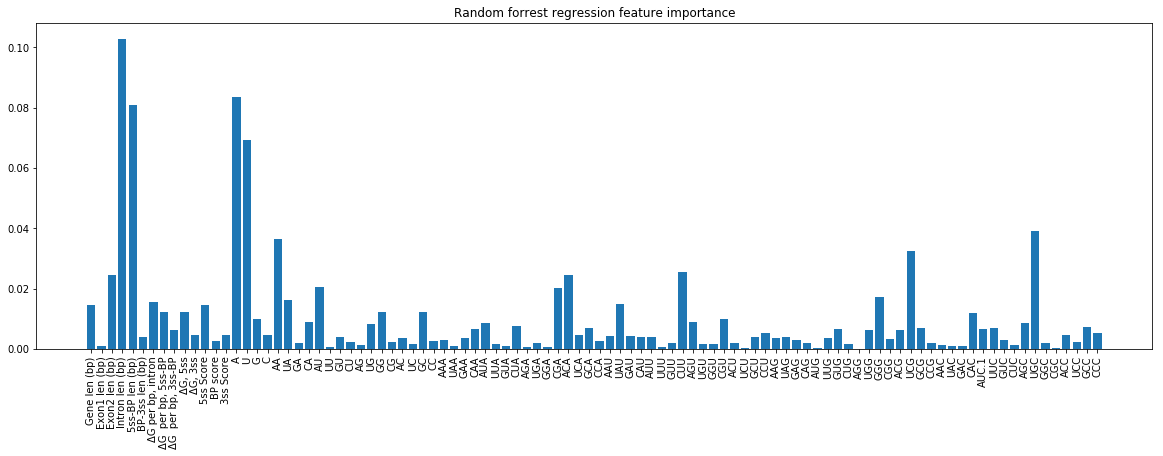

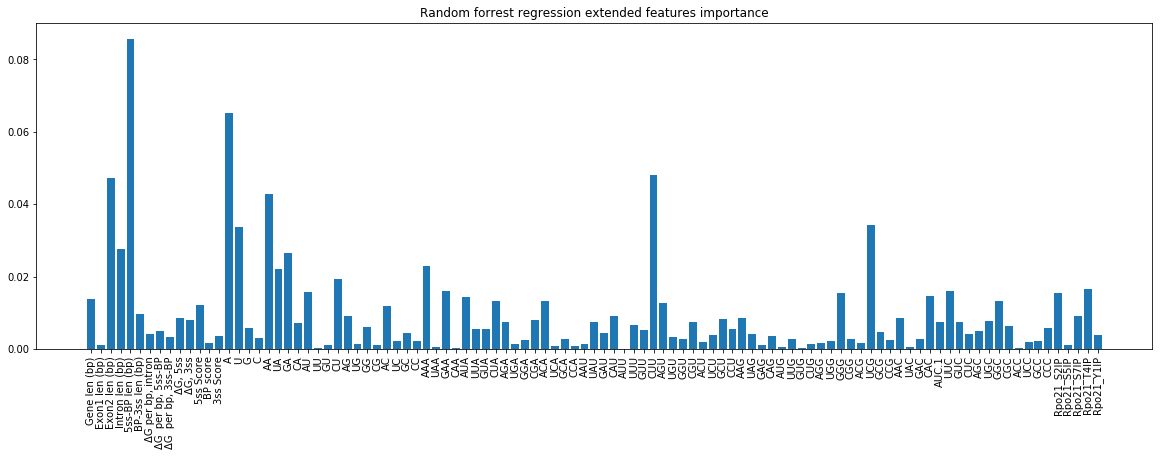

In [9]:
X,y,X2,y2 = get_data('full')

rfr1 = ExtraTreesRegressor(random_state=1337)
rfr2 = ExtraTreesRegressor(random_state=1337)

predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(rfr2,X2,y=y2,cv=kf)

print('Data')
print_stats(y,predictions_rfr1)
print('\n')
print('Extended Data')
print_stats(y2,predictions_rfr2)

rfr1.fit(X,y)
fig, ax1 = plt.subplots(figsize=(20,6))
xx = np.arange(len(rfr1.feature_importances_))
ax1.bar(xx, rfr1.feature_importances_)
ax1.set_xticks(xx)
ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
ax1.set_title('Random forrest regression feature importance')

rfr2.fit(X2,y2)
fig2, ax2 = plt.subplots(figsize=(20,6))
xx = np.arange(len(rfr2.feature_importances_))
ax2.bar(xx, rfr2.feature_importances_)
ax2.set_xticks(xx)
ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
ax2.set_title('Random forrest regression extended features importance')

# Full Set

In [9]:
def best_RFs(results1,results2,dataset):
     
    X,y,X2,y2 = get_data(dataset)
    mxf1, md1, n_est1, mxf2, md2, n_est2 = get_best_settings(results1,results2)
    
    kf = KFold(n_splits=5,shuffle=True,random_state=0)
    
    rfr1 = ExtraTreesRegressor(n_estimators=n_est1, 
                                criterion='mse', 
                                max_features=mxf1, 
                                max_depth=md1, 
                                n_jobs=2,
                                random_state=1337)

    rfr2 = ExtraTreesRegressor(n_estimators=n_est2, 
                                criterion='mse', 
                                max_features=mxf2, 
                                max_depth=md2, 
                                n_jobs=2,
                                random_state=1337)

    predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
    predictions_rfr2 = cross_val_predict(rfr2,X2,y=y2,cv=kf)

    print('Normal feature space')
    print_stats(y, predictions_rfr1)
    print('\n')
    print('Extended feature space')
    print_stats(y2, predictions_rfr2)
    print('-------------------------------------------------------\n')
         
    settings = 'max_features: {}; max_depth: {}; n_estimators: {};'.format(mxf1,md1,n_est1)
          
    rfr1.fit(X,y)
    fig, ax1 = plt.subplots(figsize=(20,6))
    xx = np.arange(len(rfr1.feature_importances_))
    ax1.bar(xx, rfr1.feature_importances_)
    ax1.set_xticks(xx)
    ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
    ax1.set_title('Normal RF: {} -- {}'.format(settings,np.corrcoef(y, predictions_rfr1)[0][1]))

    settings = 'max_features: {}; max_depth: {}; n_estimators: {};'.format(mxf2,md2,n_est2)
    rfr2.fit(X2,y2)
    fig2, ax2 = plt.subplots(figsize=(20,6))
    xx = np.arange(len(rfr2.feature_importances_))
    ax2.bar(xx, rfr2.feature_importances_)
    ax2.set_xticks(xx)
    ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
    ax2.set_title('Extended RF : {} -- {}'.format(settings,np.corrcoef(y2, predictions_rfr2)[0][1]))

In [13]:
X,y,X2,y2 = get_data('full')
print('echo')

mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
md = [5,7,10,12,15,18,20]
n_est = [10,20,30,40,50,100,140,160,200,300,400,500,600,800,1000,1200]

results_1_full = np.zeros((len(mxf),len(md),len(n_est)))
results_2_full = np.zeros((len(mxf),len(md),len(n_est)))

f = FloatProgress(min=0, max=(len(mxf)*len(md)*len(n_est)))
display(f)


i = 0
for max_features in mxf:
    j = 0
    for max_depth in md:
        k = 0
        for n_estimators in n_est:            
            
            kf = KFold(n_splits=5,shuffle=True,random_state=0)

            rfr1 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X=X,y=y,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X=X2,y=y2,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print_stats(y, predictions_rfr1)
            print('\n')
            print('Extended feature space')
            print_stats(y2, predictions_rfr2)
            print('-------------------------------------------------------\n')
            

            results_1_full[i][j][k]=np.corrcoef(y, predictions_rfr1)[0][1]
            results_2_full[i][j][k]=np.corrcoef(y2, predictions_rfr2)[0][1]
            
            f.value += 1
            
            k += 1
        j += 1
    i += 1

echo


FloatProgress(value=0.0, max=1344.0)

max_features: 5; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3264687991775198
Mean squared error:               0.03512784053467375
Mean absolute error:              0.14506464071325678
Root mean squared error:          0.18742422611464546
Correlation Coefficient:          0.5820723158917112


Extended feature space
Coefficient of determination R^2: 0.2484766451836291
Mean squared error:               0.03919550057047839
Mean absolute error:              0.15054458100512708
Root mean squared error:          0.19797853563070514
Correlation Coefficient:          0.524680408703562
-------------------------------------------------------

max_features: 5; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2840282678085726
Mean squared error:               0.03734131515368866
Mean absolute error:              0.14777029965909888
Root mean squared error:          0.19323901043445824
Correlation Coefficient:  

max_features: 5; max_depth: 5; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.2821155207944437
Mean squared error:               0.03744107396517868
Mean absolute error:              0.1485064757744615
Root mean squared error:          0.19349696112647008
Correlation Coefficient:          0.5753792861177168


Extended feature space
Coefficient of determination R^2: 0.2803890587585467
Mean squared error:               0.037531117133204304
Mean absolute error:              0.1496209145887251
Root mean squared error:          0.19372949474255155
Correlation Coefficient:          0.5804732239874753
-------------------------------------------------------

max_features: 5; max_depth: 5; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.2773156446214553
Mean squared error:               0.037691410229608625
Mean absolute error:              0.1489810677104133
Root mean squared error:          0.1941427573452294
Correlation Coefficient: 

max_features: 5; max_depth: 7; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.3252510752440809
Mean squared error:               0.03519135060235415
Mean absolute error:              0.14266420210291447
Root mean squared error:          0.1875935782545718
Correlation Coefficient:          0.6023440761566412


Extended feature space
Coefficient of determination R^2: 0.3059633018704033
Mean squared error:               0.03619729928967866
Mean absolute error:              0.14528454774536165
Root mean squared error:          0.1902558784628708
Correlation Coefficient:          0.5806518852042074
-------------------------------------------------------

max_features: 5; max_depth: 7; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.32051267409548756
Mean squared error:               0.03543848065324688
Mean absolute error:              0.14330956645320467
Root mean squared error:          0.18825111062951763
Correlation Coefficient:

max_features: 5; max_depth: 10; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.29844265188555974
Mean squared error:               0.03658953678819703
Mean absolute error:              0.14669332075359046
Root mean squared error:          0.19128391670027312
Correlation Coefficient:          0.5624208079756006


Extended feature space
Coefficient of determination R^2: 0.29779457173797974
Mean squared error:               0.03662333723582303
Mean absolute error:              0.1414639337831379
Root mean squared error:          0.191372247820375
Correlation Coefficient:          0.5594870372657298
-------------------------------------------------------

max_features: 5; max_depth: 10; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3171329583893566
Mean squared error:               0.03561474882646963
Mean absolute error:              0.14390738881757442
Root mean squared error:          0.18871870290585835
Correlation Coefficient

max_features: 5; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.28141230983152543
Mean squared error:               0.0374777497458069
Mean absolute error:              0.14577204259965057
Root mean squared error:          0.19359170887671534
Correlation Coefficient:          0.5310585022581763


Extended feature space
Coefficient of determination R^2: 0.2635713954802469
Mean squared error:               0.038408237885865115
Mean absolute error:              0.14589098627066496
Root mean squared error:          0.19598019768809583
Correlation Coefficient:          0.513955317825376
-------------------------------------------------------

max_features: 5; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.27448301843361134
Mean squared error:               0.0378391450945999
Mean absolute error:              0.14648471149937828
Root mean squared error:          0.19452286522308862
Correlation Coefficient

max_features: 5; max_depth: 12; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.3319702470264655
Mean squared error:               0.034840913986190776
Mean absolute error:              0.14091358885679447
Root mean squared error:          0.1866572098425099
Correlation Coefficient:          0.6024989755918408


Extended feature space
Coefficient of determination R^2: 0.3297421527864778
Mean squared error:               0.034957119648323334
Mean absolute error:              0.14165954476561526
Root mean squared error:          0.18696823165533585
Correlation Coefficient:          0.5995651874539992
-------------------------------------------------------

max_features: 5; max_depth: 12; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.33080933098091003
Mean squared error:               0.03490146125359667
Mean absolute error:              0.14075053094676462
Root mean squared error:          0.1868193278373431
Correlation Coeffici

max_features: 5; max_depth: 15; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.33605780916378747
Mean squared error:               0.03462772827072566
Mean absolute error:              0.14101561361223022
Root mean squared error:          0.1860852715040222
Correlation Coefficient:          0.6008336809655365


Extended feature space
Coefficient of determination R^2: 0.32217816593605697
Mean squared error:               0.03535161736953281
Mean absolute error:              0.14197686652827549
Root mean squared error:          0.1880202578700838
Correlation Coefficient:          0.5887702040945929
-------------------------------------------------------

max_features: 5; max_depth: 15; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.3299459097713656
Mean squared error:               0.034946492757001554
Mean absolute error:              0.14111857887156826
Root mean squared error:          0.18693981051932612
Correlation Coeffici

max_features: 5; max_depth: 18; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.32446771952466613
Mean squared error:               0.035232206311428836
Mean absolute error:              0.1408260275403609
Root mean squared error:          0.18770244087765303
Correlation Coefficient:          0.5900925943767531


Extended feature space
Coefficient of determination R^2: 0.27536476097688944
Mean squared error:               0.03779315804690993
Mean absolute error:              0.14759482259478413
Root mean squared error:          0.19440462455124344
Correlation Coefficient:          0.5362959498525205
-------------------------------------------------------

max_features: 5; max_depth: 18; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.32212834294625314
Mean squared error:               0.03535421587430683
Mean absolute error:              0.14181915167548498
Root mean squared error:          0.18802716791545532
Correlation Coeffic

max_features: 5; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.28994412466558117
Mean squared error:               0.03703277521367521
Mean absolute error:              0.14235384615384616
Root mean squared error:          0.19243901686943637
Correlation Coefficient:          0.5398777909872458


Extended feature space
Coefficient of determination R^2: 0.1595889192599782
Mean squared error:               0.04383141626068375
Mean absolute error:              0.15849273504273503
Root mean squared error:          0.20935953826058118
Correlation Coefficient:          0.41519045263548365
-------------------------------------------------------

max_features: 5; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3015991192533243
Mean squared error:               0.03642491207264957
Mean absolute error:              0.13988675213675214
Root mean squared error:          0.19085311648660488
Correlation Coefficie

max_features: 5; max_depth: 20; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.33053671793078965
Mean squared error:               0.034915679314676255
Mean absolute error:              0.14051249382716063
Root mean squared error:          0.186857376934057
Correlation Coefficient:          0.5994142907255319


Extended feature space
Coefficient of determination R^2: 0.3278308453339025
Mean squared error:               0.035056803379863624
Mean absolute error:              0.1414833230096116
Root mean squared error:          0.18723462121056464
Correlation Coefficient:          0.5961871295739075
-------------------------------------------------------

max_features: 5; max_depth: 20; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.326839667040309
Mean squared error:               0.03510849801998759
Mean absolute error:              0.14095825050875055
Root mean squared error:          0.18737261811691588
Correlation Coefficien

max_features: 7; max_depth: 5; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.30380483546432446
Mean squared error:               0.03630987353066348
Mean absolute error:              0.14597411232791693
Root mean squared error:          0.19055149836898025
Correlation Coefficient:          0.5898588572615558


Extended feature space
Coefficient of determination R^2: 0.2971863774801774
Mean squared error:               0.03665505744548235
Mean absolute error:              0.1462441369436633
Root mean squared error:          0.19145510556128387
Correlation Coefficient:          0.5818539323785031
-------------------------------------------------------

max_features: 7; max_depth: 5; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.29783765981798427
Mean squared error:               0.036621089988477254
Mean absolute error:              0.14680700422212495
Root mean squared error:          0.19136637632687006
Correlation Coefficie

max_features: 7; max_depth: 7; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3242922456373686
Mean squared error:               0.03524135810532266
Mean absolute error:              0.14304134603870586
Root mean squared error:          0.1877268177574069
Correlation Coefficient:          0.5871775715368899


Extended feature space
Coefficient of determination R^2: 0.32175670683134416
Mean squared error:               0.035373598456977844
Mean absolute error:              0.14287916148505334
Root mean squared error:          0.18807870282670988
Correlation Coefficient:          0.5841678261214073
-------------------------------------------------------

max_features: 7; max_depth: 7; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3340100727681772
Mean squared error:               0.03473452741748264
Mean absolute error:              0.14150146450335457
Root mean squared error:          0.1863720135038591
Correlation Coefficient:

max_features: 7; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30343754370145326
Mean squared error:               0.03632902953481011
Mean absolute error:              0.1443474463246771
Root mean squared error:          0.19060175637913232
Correlation Coefficient:          0.5513616874219517


Extended feature space
Coefficient of determination R^2: 0.1967520039379015
Mean squared error:               0.04189318546937296
Mean absolute error:              0.15161396909909922
Root mean squared error:          0.2046782486474148
Correlation Coefficient:          0.4532803442151841
-------------------------------------------------------

max_features: 7; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3877754218290288
Mean squared error:               0.03193040994557587
Mean absolute error:              0.13927358038075213
Root mean squared error:          0.17869082221976557
Correlation Coefficient:

max_features: 7; max_depth: 10; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.3247774229390771
Mean squared error:               0.035216053812270394
Mean absolute error:              0.14006336058836463
Root mean squared error:          0.18765940906938397
Correlation Coefficient:          0.5865101821198766


Extended feature space
Coefficient of determination R^2: 0.3368303819428575
Mean squared error:               0.03458743494303503
Mean absolute error:              0.14048100790684806
Root mean squared error:          0.18597697422808834
Correlation Coefficient:          0.6001633913402303
-------------------------------------------------------

max_features: 7; max_depth: 10; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.32550175666820014
Mean squared error:               0.03517827637939208
Mean absolute error:              0.13996543588066931
Root mean squared error:          0.1875587278144957
Correlation Coeffici

max_features: 7; max_depth: 12; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.3316744013412455
Mean squared error:               0.03485634373917117
Mean absolute error:              0.1382945293623777
Root mean squared error:          0.1866985370568585
Correlation Coefficient:          0.589762930645558


Extended feature space
Coefficient of determination R^2: 0.33809779683027463
Mean squared error:               0.034521333256873954
Mean absolute error:              0.13987365499993623
Root mean squared error:          0.18579917453227277
Correlation Coefficient:          0.5996071065609192
-------------------------------------------------------

max_features: 7; max_depth: 12; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.3303751271902059
Mean squared error:               0.03492410703674789
Mean absolute error:              0.13905242637108114
Root mean squared error:          0.1868799267892298
Correlation Coefficient

max_features: 7; max_depth: 15; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.32555206083342925
Mean squared error:               0.035175652779041805
Mean absolute error:              0.1408283053597075
Root mean squared error:          0.1875517336071352
Correlation Coefficient:          0.5800631126384002


Extended feature space
Coefficient of determination R^2: 0.31376355343800155
Mean squared error:               0.035790479245021
Mean absolute error:              0.14209172748471008
Root mean squared error:          0.18918371823447439
Correlation Coefficient:          0.5737175835303662
-------------------------------------------------------

max_features: 7; max_depth: 15; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3416576812800364
Mean squared error:               0.034335668430774756
Mean absolute error:              0.14032919107350264
Root mean squared error:          0.18529886246486985
Correlation Coefficien

max_features: 7; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3033442997782083
Mean squared error:               0.03633389264681231
Mean absolute error:              0.14169747863247867
Root mean squared error:          0.1906145132113825
Correlation Coefficient:          0.5513453233861487


Extended feature space
Coefficient of determination R^2: 0.22400855739866354
Mean squared error:               0.04047162717730682
Mean absolute error:              0.14442020757020757
Root mean squared error:          0.20117561277974727
Correlation Coefficient:          0.47800868124989737
-------------------------------------------------------

max_features: 7; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.36768115243921984
Mean squared error:               0.032978421217992084
Mean absolute error:              0.13378915954415957
Root mean squared error:          0.18159961789054535
Correlation Coeffici

max_features: 7; max_depth: 18; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.33183809191172586
Mean squared error:               0.034847806501030094
Mean absolute error:              0.1400631289670752
Root mean squared error:          0.18667567195815873
Correlation Coefficient:          0.5912583937382034


Extended feature space
Coefficient of determination R^2: 0.34759908921001204
Mean squared error:               0.03402579588135051
Mean absolute error:              0.13958131868238613
Root mean squared error:          0.1844608247876782
Correlation Coefficient:          0.6121259410318001
-------------------------------------------------------

max_features: 7; max_depth: 18; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.33670389536911116
Mean squared error:               0.034594031816627395
Mean absolute error:              0.13930852921835354
Root mean squared error:          0.18599470910923083
Correlation Coeffi

max_features: 7; max_depth: 20; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.32827386728919805
Mean squared error:               0.035033697687684884
Mean absolute error:              0.14045143783068784
Root mean squared error:          0.18717290853028085
Correlation Coefficient:          0.5867331570255225


Extended feature space
Coefficient of determination R^2: 0.3459090749680048
Mean squared error:               0.034113938124385526
Mean absolute error:              0.13885557905982918
Root mean squared error:          0.184699588858193
Correlation Coefficient:          0.6120040863400682
-------------------------------------------------------

max_features: 7; max_depth: 20; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.3290403226933599
Mean squared error:               0.0349937234100546
Mean absolute error:              0.1403138464930132
Root mean squared error:          0.18706609369432667
Correlation Coefficien

max_features: 10; max_depth: 5; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3026430711567879
Mean squared error:               0.03637046503894726
Mean absolute error:              0.1452495525502895
Root mean squared error:          0.1907104219463301
Correlation Coefficient:          0.5695787323891853


Extended feature space
Coefficient of determination R^2: 0.31440852373349937
Mean squared error:               0.035756840990902726
Mean absolute error:              0.1433171818984604
Root mean squared error:          0.18909479366419035
Correlation Coefficient:          0.5923567386028493
-------------------------------------------------------

max_features: 10; max_depth: 5; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3049685973152412
Mean squared error:               0.036249177841036304
Mean absolute error:              0.14433501660180567
Root mean squared error:          0.19039216853914004
Correlation Coefficien

max_features: 10; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.24711233132420285
Mean squared error:               0.03926665599673725
Mean absolute error:              0.1472071874368671
Root mean squared error:          0.19815815904659906
Correlation Coefficient:          0.49771999564667313


Extended feature space
Coefficient of determination R^2: 0.2834971274921604
Mean squared error:               0.03736901663554085
Mean absolute error:              0.14533574678098637
Root mean squared error:          0.19331067387896833
Correlation Coefficient:          0.5352202053980758
-------------------------------------------------------

max_features: 10; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.261566739965462
Mean squared error:               0.038512790160747594
Mean absolute error:              0.14717609356631114
Root mean squared error:          0.19624675834455862
Correlation Coefficien

max_features: 10; max_depth: 7; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.3333978075203208
Mean squared error:               0.03476645994854484
Mean absolute error:              0.13957539556192855
Root mean squared error:          0.1864576626168655
Correlation Coefficient:          0.5930303819996036


Extended feature space
Coefficient of determination R^2: 0.34383516858367325
Mean squared error:               0.034222102159939746
Mean absolute error:              0.13907502958395068
Root mean squared error:          0.18499216783404573
Correlation Coefficient:          0.6095009544598872
-------------------------------------------------------

max_features: 10; max_depth: 7; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.32927926617268366
Mean squared error:               0.03498126137647956
Mean absolute error:              0.14013500212410754
Root mean squared error:          0.18703278155574643
Correlation Coeffic

max_features: 10; max_depth: 10; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.33611157760251753
Mean squared error:               0.03462492399211288
Mean absolute error:              0.13746350114097403
Root mean squared error:          0.18607773642247716
Correlation Coefficient:          0.5890898794203113


Extended feature space
Coefficient of determination R^2: 0.3584309684351221
Mean squared error:               0.033460862103010525
Mean absolute error:              0.13630294835339402
Root mean squared error:          0.18292310434444994
Correlation Coefficient:          0.6152431836113296
-------------------------------------------------------

max_features: 10; max_depth: 10; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.3365922523125813
Mean squared error:               0.034599854530529585
Mean absolute error:              0.13838705378382674
Root mean squared error:          0.18601036135261279
Correlation Coef

max_features: 10; max_depth: 12; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.33508293822743296
Mean squared error:               0.034678572404972643
Mean absolute error:              0.13712052239266503
Root mean squared error:          0.1862218365417242
Correlation Coefficient:          0.5839721945765568


Extended feature space
Coefficient of determination R^2: 0.340477216721376
Mean squared error:               0.03439723524567927
Mean absolute error:              0.1402131257411356
Root mean squared error:          0.18546491648201086
Correlation Coefficient:          0.6011001562925096
-------------------------------------------------------

max_features: 10; max_depth: 12; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3383911187116875
Mean squared error:               0.03450603513220948
Mean absolute error:              0.13724613846529035
Root mean squared error:          0.18575800152943472
Correlation Coefficie

max_features: 10; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2476560896995611
Mean squared error:               0.039238296423378734
Mean absolute error:              0.1496596067228119
Root mean squared error:          0.1980865881966236
Correlation Coefficient:          0.5033979967085815


Extended feature space
Coefficient of determination R^2: 0.3353641021062531
Mean squared error:               0.034663908377697825
Mean absolute error:              0.14169986365486367
Root mean squared error:          0.18618245990881585
Correlation Coefficient:          0.5989965628114857
-------------------------------------------------------

max_features: 10; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.26495004096962627
Mean squared error:               0.03833633499726006
Mean absolute error:              0.149670271411874
Root mean squared error:          0.19579666748251887
Correlation Coefficien

max_features: 10; max_depth: 15; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.35061036021539227
Mean squared error:               0.03386874384344268
Mean absolute error:              0.13649911346270321
Root mean squared error:          0.1840346267511706
Correlation Coefficient:          0.6061055020425281


Extended feature space
Coefficient of determination R^2: 0.35762594030247985
Mean squared error:               0.033502848131029495
Mean absolute error:              0.13790652767065814
Root mean squared error:          0.18303783251292474
Correlation Coefficient:          0.6149676648344751
-------------------------------------------------------

max_features: 10; max_depth: 15; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.35305974336228396
Mean squared error:               0.03374099691726129
Mean absolute error:              0.13646084694589145
Root mean squared error:          0.18368722578682845
Correlation Coef

max_features: 10; max_depth: 18; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.32577452028927145
Mean squared error:               0.035164050465324614
Mean absolute error:              0.13893266467791474
Root mean squared error:          0.1875208000871493
Correlation Coefficient:          0.5781882789885193


Extended feature space
Coefficient of determination R^2: 0.3564948981426703
Mean squared error:               0.03356183733387454
Mean absolute error:              0.13741678054198891
Root mean squared error:          0.18319890101710365
Correlation Coefficient:          0.6140614168489025
-------------------------------------------------------

max_features: 10; max_depth: 18; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.3365783651907752
Mean squared error:               0.034600578809671656
Mean absolute error:              0.13834123107139776
Root mean squared error:          0.18601230822091225
Correlation Coeff

max_features: 10; max_depth: 20; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3149364067185676
Mean squared error:               0.03572930939429993
Mean absolute error:              0.13954627716727716
Root mean squared error:          0.18902198124636174
Correlation Coefficient:          0.565615499978753


Extended feature space
Coefficient of determination R^2: 0.3343180413271505
Mean squared error:               0.034718465399247854
Mean absolute error:              0.14141805128205126
Root mean squared error:          0.18632891723843578
Correlation Coefficient:          0.5923020437127275
-------------------------------------------------------

max_features: 10; max_depth: 20; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3255595356643127
Mean squared error:               0.035175262931226324
Mean absolute error:              0.1390212269027269
Root mean squared error:          0.1875506942968389
Correlation Coefficie

max_features: 12; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.231639566604382
Mean squared error:               0.040073633922993186
Mean absolute error:              0.15594509208731724
Root mean squared error:          0.200184000167329
Correlation Coefficient:          0.4858988381238325


Extended feature space
Coefficient of determination R^2: 0.294134341707605
Mean squared error:               0.03681423555897453
Mean absolute error:              0.14515515139396284
Root mean squared error:          0.19187036133539367
Correlation Coefficient:          0.551052708510826
-------------------------------------------------------

max_features: 12; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.30126121463688127
Mean squared error:               0.03644253539799493
Mean absolute error:              0.14590086620904832
Root mean squared error:          0.1908992807686685
Correlation Coefficient:   

max_features: 12; max_depth: 5; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.32570461864642064
Mean squared error:               0.035167696166904856
Mean absolute error:              0.14115585791297353
Root mean squared error:          0.18753052062772305
Correlation Coefficient:          0.5919389758106606


Extended feature space
Coefficient of determination R^2: 0.3215648994706861
Mean squared error:               0.03538360211882802
Mean absolute error:              0.1428467569034849
Root mean squared error:          0.18810529529715003
Correlation Coefficient:          0.5913563622914679
-------------------------------------------------------

max_features: 12; max_depth: 5; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.3238478631611621
Mean squared error:               0.035264534755107435
Mean absolute error:              0.14119529377264983
Root mean squared error:          0.18778853733683384
Correlation Coeffic

max_features: 12; max_depth: 7; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.3371423549543803
Mean squared error:               0.034571164073643225
Mean absolute error:              0.13901112091517254
Root mean squared error:          0.18593322477073113
Correlation Coefficient:          0.5916363395679082


Extended feature space
Coefficient of determination R^2: 0.34720604619862216
Mean squared error:               0.03404629493501055
Mean absolute error:              0.13922197536279712
Root mean squared error:          0.1845163812104783
Correlation Coefficient:          0.604637990025451
-------------------------------------------------------

max_features: 12; max_depth: 7; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.34437191094927777
Mean squared error:               0.03419410850470279
Mean absolute error:              0.1383045529340627
Root mean squared error:          0.1849164906240187
Correlation Coefficien

max_features: 12; max_depth: 10; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.35716985452625316
Mean squared error:               0.03352663516331227
Mean absolute error:              0.13719825772301125
Root mean squared error:          0.18310279944149482
Correlation Coefficient:          0.6063370086611677


Extended feature space
Coefficient of determination R^2: 0.3506116586315067
Mean squared error:               0.03386867612489577
Mean absolute error:              0.13753034994867297
Root mean squared error:          0.1840344427679117
Correlation Coefficient:          0.6022282333507476
-------------------------------------------------------

max_features: 12; max_depth: 10; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.36245240296401915
Mean squared error:               0.033251125255364535
Mean absolute error:              0.13548424939948817
Root mean squared error:          0.1823489107600167
Correlation Coeffic

max_features: 12; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3337860158560899
Mean squared error:               0.03474621304610516
Mean absolute error:              0.13897844608459803
Root mean squared error:          0.18640336114487088
Correlation Coefficient:          0.578062758084954


Extended feature space
Coefficient of determination R^2: 0.1782647234176119
Mean squared error:               0.04285738466496104
Mean absolute error:              0.15355652830313085
Root mean squared error:          0.20702025182324807
Correlation Coefficient:          0.4334853021243917
-------------------------------------------------------

max_features: 12; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.38784917221712
Mean squared error:               0.03192656351371188
Mean absolute error:              0.1322392781320336
Root mean squared error:          0.17868005908246135
Correlation Coefficient: 

max_features: 12; max_depth: 12; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.35937180298670945
Mean squared error:               0.0334117931273531
Mean absolute error:              0.13544330506165084
Root mean squared error:          0.18278893053834824
Correlation Coefficient:          0.611937016087796


Extended feature space
Coefficient of determination R^2: 0.34116886013736636
Mean squared error:               0.03436116276738265
Mean absolute error:              0.13786484082822967
Root mean squared error:          0.18536764218002735
Correlation Coefficient:          0.5948074603692023
-------------------------------------------------------

max_features: 12; max_depth: 12; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.3605038986548227
Mean squared error:               0.03335274897906285
Mean absolute error:              0.13525756434045033
Root mean squared error:          0.18262735003022645
Correlation Coeffic

max_features: 12; max_depth: 15; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.35646778798512047
Mean squared error:               0.03356325125692683
Mean absolute error:              0.13648578319751245
Root mean squared error:          0.1832027599599057
Correlation Coefficient:          0.6068922932423446


Extended feature space
Coefficient of determination R^2: 0.34763587824942443
Mean squared error:               0.03402387715879048
Mean absolute error:              0.13769980650501149
Root mean squared error:          0.1844556238199055
Correlation Coefficient:          0.601562825234848
-------------------------------------------------------

max_features: 12; max_depth: 15; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.35755147613563587
Mean squared error:               0.03350673178983439
Mean absolute error:              0.13539653492135442
Root mean squared error:          0.18304844110189628
Correlation Coeffic

max_features: 12; max_depth: 18; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3714585596056428
Mean squared error:               0.03278141155249388
Mean absolute error:              0.13622219495319493
Root mean squared error:          0.18105637672419572
Correlation Coefficient:          0.6197804323224727


Extended feature space
Coefficient of determination R^2: 0.33933586962741136
Mean squared error:               0.03445676189962276
Mean absolute error:              0.1388384852801519
Root mean squared error:          0.1856253266653631
Correlation Coefficient:          0.5925778043639226
-------------------------------------------------------

max_features: 12; max_depth: 18; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.36670923198764493
Mean squared error:               0.033029111470490584
Mean absolute error:              0.13636194647944647
Root mean squared error:          0.18173913026778407
Correlation Coeffic

max_features: 12; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2740532086515117
Mean squared error:               0.03786156170940171
Mean absolute error:              0.1460444444444445
Root mean squared error:          0.19458047617734342
Correlation Coefficient:          0.5277079720003364


Extended feature space
Coefficient of determination R^2: 0.26086591713642315
Mean squared error:               0.03854934138888887
Mean absolute error:              0.14713119658119658
Root mean squared error:          0.19633986194578235
Correlation Coefficient:          0.5117076591856936
-------------------------------------------------------

max_features: 12; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3603576055647332
Mean squared error:               0.033360378856244065
Mean absolute error:              0.13661688034188035
Root mean squared error:          0.1826482380321367
Correlation Coefficie

max_features: 12; max_depth: 20; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.3592210131949689
Mean squared error:               0.033419657528812236
Mean absolute error:              0.13545359576879204
Root mean squared error:          0.18281044152020484
Correlation Coefficient:          0.6118839721318665


Extended feature space
Coefficient of determination R^2: 0.3477943829250414
Mean squared error:               0.034015610389615904
Mean absolute error:              0.13804197003459515
Root mean squared error:          0.18443321390035988
Correlation Coefficient:          0.6012269148059457
-------------------------------------------------------

max_features: 12; max_depth: 20; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.35887792435412036
Mean squared error:               0.0334375512360018
Mean absolute error:              0.1353494106798704
Root mean squared error:          0.1828593755758829
Correlation Coeffic

max_features: 15; max_depth: 5; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.3272495454398062
Mean squared error:               0.03508712092114115
Mean absolute error:              0.13987430845648713
Root mean squared error:          0.1873155650797369
Correlation Coefficient:          0.5850283436084714


Extended feature space
Coefficient of determination R^2: 0.33603181153799877
Mean squared error:               0.03462908416998003
Mean absolute error:              0.14127029603681268
Root mean squared error:          0.18608891468859726
Correlation Coefficient:          0.598381527122557
-------------------------------------------------------

max_features: 15; max_depth: 5; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.3282219237360433
Mean squared error:               0.035036406789876136
Mean absolute error:              0.14095102799295786
Root mean squared error:          0.18718014528757085
Correlation Coefficie

max_features: 15; max_depth: 7; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.32792075605184157
Mean squared error:               0.0350521141102971
Mean absolute error:              0.1406602886319669
Root mean squared error:          0.1872220983492523
Correlation Coefficient:          0.5799989815583387


Extended feature space
Coefficient of determination R^2: 0.3258433822152932
Mean squared error:               0.03516045898989891
Mean absolute error:              0.13946717987605148
Root mean squared error:          0.18751122363714368
Correlation Coefficient:          0.5746892809888303
-------------------------------------------------------

max_features: 15; max_depth: 7; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3464693335399549
Mean squared error:               0.03408471798766489
Mean absolute error:              0.13623711157023521
Root mean squared error:          0.18462047012090746
Correlation Coefficient:

max_features: 15; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.23439211518073133
Mean squared error:               0.03993007548451867
Mean absolute error:              0.15054216779533153
Root mean squared error:          0.1998251122469813
Correlation Coefficient:          0.496147844808406


Extended feature space
Coefficient of determination R^2: 0.2512363054929664
Mean squared error:               0.0390515712214625
Mean absolute error:              0.1463228274666548
Root mean squared error:          0.19761470396066813
Correlation Coefficient:          0.5061106607854546
-------------------------------------------------------

max_features: 15; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2653828971923241
Mean squared error:               0.03831375949615959
Mean absolute error:              0.14630514370070194
Root mean squared error:          0.19573900862158158
Correlation Coefficient:

max_features: 15; max_depth: 10; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.3547588191650799
Mean squared error:               0.033652382070934864
Mean absolute error:              0.1364996681615369
Root mean squared error:          0.1834458559655542
Correlation Coefficient:          0.6046070644935702


Extended feature space
Coefficient of determination R^2: 0.36317268847183026
Mean squared error:               0.03321355895639141
Mean absolute error:              0.13619624280088646
Root mean squared error:          0.1822458750051463
Correlation Coefficient:          0.6145077610369686
-------------------------------------------------------

max_features: 15; max_depth: 10; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.35180295420822916
Mean squared error:               0.03380654442112664
Mean absolute error:              0.13680581736750402
Root mean squared error:          0.18386556072610946
Correlation Coeffic

max_features: 15; max_depth: 12; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.3540519438104458
Mean squared error:               0.03368924896693783
Mean absolute error:              0.13615207896318704
Root mean squared error:          0.1835463128666382
Correlation Coefficient:          0.6037248424217708


Extended feature space
Coefficient of determination R^2: 0.34920547030305504
Mean squared error:               0.03394201550294277
Mean absolute error:              0.13724362018241393
Root mean squared error:          0.18423358950783858
Correlation Coefficient:          0.5995402097883508
-------------------------------------------------------

max_features: 15; max_depth: 12; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.36028822673473104
Mean squared error:               0.03336399729065931
Mean absolute error:              0.1361485790418141
Root mean squared error:          0.18265814323664661
Correlation Coeffic

max_features: 15; max_depth: 15; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3405680239529074
Mean squared error:               0.034392499218684924
Mean absolute error:              0.1394123323443937
Root mean squared error:          0.18545214805627064
Correlation Coefficient:          0.5902183112909791


Extended feature space
Coefficient of determination R^2: 0.3203179577862374
Mean squared error:               0.03544863603053673
Mean absolute error:              0.13897357112840172
Root mean squared error:          0.1882780816519457
Correlation Coefficient:          0.5701404586447018
-------------------------------------------------------

max_features: 15; max_depth: 15; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3519790841446697
Mean squared error:               0.03379735841116435
Mean absolute error:              0.13791060237796637
Root mean squared error:          0.18384057879359592
Correlation Coefficie

max_features: 15; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2689036026583628
Mean squared error:               0.03813013803952991
Mean absolute error:              0.14932884615384617
Root mean squared error:          0.19526939862541162
Correlation Coefficient:          0.5255446680853808


Extended feature space
Coefficient of determination R^2: 0.29992454384711065
Mean squared error:               0.03651224910731244
Mean absolute error:              0.13558062678062677
Root mean squared error:          0.1910817864353179
Correlation Coefficient:          0.5529351381263348
-------------------------------------------------------

max_features: 15; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3100604182925829
Mean squared error:               0.035983615273029436
Mean absolute error:              0.14283618233618234
Root mean squared error:          0.18969347714939866
Correlation Coeffici

max_features: 15; max_depth: 18; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.34639440640935115
Mean squared error:               0.03408862579222146
Mean absolute error:              0.13804558785765533
Root mean squared error:          0.18463105316338707
Correlation Coefficient:          0.596063335217701


Extended feature space
Coefficient of determination R^2: 0.35954004695089503
Mean squared error:               0.03340301840817511
Mean absolute error:              0.13668102795540574
Root mean squared error:          0.18276492663576102
Correlation Coefficient:          0.6113793209762171
-------------------------------------------------------

max_features: 15; max_depth: 18; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.3454173771895881
Mean squared error:               0.03413958249116524
Mean absolute error:              0.13793565489182016
Root mean squared error:          0.18476899764615612
Correlation Coeffi

max_features: 15; max_depth: 20; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.3483112558153024
Mean squared error:               0.033988653021577706
Mean absolute error:              0.13715080009496686
Root mean squared error:          0.18436011776297417
Correlation Coefficient:          0.5981311969075427


Extended feature space
Coefficient of determination R^2: 0.35263686555396145
Mean squared error:               0.033763051996815535
Mean absolute error:              0.13693488176638186
Root mean squared error:          0.18374725031089725
Correlation Coefficient:          0.6017948746327685
-------------------------------------------------------

max_features: 15; max_depth: 20; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.35031264972725185
Mean squared error:               0.03388427085472311
Mean absolute error:              0.13789536055713839
Root mean squared error:          0.18407680694406645
Correlation Coe

max_features: 18; max_depth: 5; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3280155189136946
Mean squared error:               0.035047171778456024
Mean absolute error:              0.14275475875173438
Root mean squared error:          0.18720889876941219
Correlation Coefficient:          0.5828379798113001


Extended feature space
Coefficient of determination R^2: 0.3255610470567043
Mean squared error:               0.03517518410495836
Mean absolute error:              0.13992129078135088
Root mean squared error:          0.18755048415015718
Correlation Coefficient:          0.577321073868634
-------------------------------------------------------

max_features: 18; max_depth: 5; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3339958913821104
Mean squared error:               0.03473526704389892
Mean absolute error:              0.1416444492363624
Root mean squared error:          0.1863739977676578
Correlation Coefficient:

max_features: 18; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3865853042342414
Mean squared error:               0.03199248021201066
Mean absolute error:              0.1368907392822868
Root mean squared error:          0.17886441851863846
Correlation Coefficient:          0.626683967561346


Extended feature space
Coefficient of determination R^2: 0.2600291671789696
Mean squared error:               0.03859298186023887
Mean absolute error:              0.14396999559844195
Root mean squared error:          0.19645096553654012
Correlation Coefficient:          0.5110751433369214
-------------------------------------------------------

max_features: 18; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.36379839239836964
Mean squared error:               0.033180925534618884
Mean absolute error:              0.13706350112703614
Root mean squared error:          0.18215632169820206
Correlation Coefficient

max_features: 18; max_depth: 7; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.34992619983828066
Mean squared error:               0.03390442604583801
Mean absolute error:              0.13695430166341238
Root mean squared error:          0.1841315454935357
Correlation Coefficient:          0.6003215947598993


Extended feature space
Coefficient of determination R^2: 0.35893214523441275
Mean squared error:               0.03343472336041974
Mean absolute error:              0.13540293801012906
Root mean squared error:          0.18285164303450965
Correlation Coefficient:          0.610285133036844
-------------------------------------------------------

max_features: 18; max_depth: 7; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.35010486045483613
Mean squared error:               0.033895108048927806
Mean absolute error:              0.13695543653748946
Root mean squared error:          0.18410624120036725
Correlation Coeffic

max_features: 18; max_depth: 10; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.3674354130722146
Mean squared error:               0.032991237689280584
Mean absolute error:              0.13596306859961738
Root mean squared error:          0.1816349021781898
Correlation Coefficient:          0.6154927462310837


Extended feature space
Coefficient of determination R^2: 0.33979284170423574
Mean squared error:               0.03443292864256818
Mean absolute error:              0.13885579494827022
Root mean squared error:          0.1855611183480208
Correlation Coefficient:          0.5884282962653543
-------------------------------------------------------

max_features: 18; max_depth: 10; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.37180000433919136
Mean squared error:               0.032763603593283
Mean absolute error:              0.1352003097426718
Root mean squared error:          0.18100719210374763
Correlation Coefficie

max_features: 18; max_depth: 12; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.325216178111554
Mean squared error:               0.035193170653014055
Mean absolute error:              0.14206893787724478
Root mean squared error:          0.18759842923919715
Correlation Coefficient:          0.5733384427854968


Extended feature space
Coefficient of determination R^2: 0.34201960947895504
Mean squared error:               0.03431679216187868
Mean absolute error:              0.13770299532573876
Root mean squared error:          0.18524792080311908
Correlation Coefficient:          0.5894510786977062
-------------------------------------------------------

max_features: 18; max_depth: 12; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.35544062456995895
Mean squared error:               0.0336168226914896
Mean absolute error:              0.13809212815258662
Root mean squared error:          0.1833489097090288
Correlation Coeffici

max_features: 18; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.261101746853977
Mean squared error:               0.038537041752730296
Mean absolute error:              0.14930009971509978
Root mean squared error:          0.19630853713664695
Correlation Coefficient:          0.5168220195448867


Extended feature space
Coefficient of determination R^2: 0.17241976285193406
Mean squared error:               0.04316222702776749
Mean absolute error:              0.14737720150220152
Root mean squared error:          0.20775520938779726
Correlation Coefficient:          0.4376394431092595
-------------------------------------------------------

max_features: 18; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.28126671733484965
Mean squared error:               0.03748534308372506
Mean absolute error:              0.1472064957264957
Root mean squared error:          0.19361131961671316
Correlation Coeffici

max_features: 18; max_depth: 15; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.3574778497097738
Mean squared error:               0.03351057175648131
Mean absolute error:              0.1356674697629978
Root mean squared error:          0.1830589297370694
Correlation Coefficient:          0.6048120397221944


Extended feature space
Coefficient of determination R^2: 0.37049181865378555
Mean squared error:               0.032831831669563
Mean absolute error:              0.13466821059847814
Root mean squared error:          0.18119556194775577
Correlation Coefficient:          0.6206025960957774
-------------------------------------------------------

max_features: 18; max_depth: 15; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.35580202289367047
Mean squared error:               0.03359797405809395
Mean absolute error:              0.13588283866668732
Root mean squared error:          0.18329750150532317
Correlation Coefficie

max_features: 18; max_depth: 18; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.3531054126543305
Mean squared error:               0.033738615047488395
Mean absolute error:              0.13647857452732465
Root mean squared error:          0.18368074217916366
Correlation Coefficient:          0.5998488193916907


Extended feature space
Coefficient of determination R^2: 0.35566698312043366
Mean squared error:               0.0336050170215295
Mean absolute error:              0.13619979743513574
Root mean squared error:          0.18331671233559013
Correlation Coefficient:          0.6053034627285693
-------------------------------------------------------

max_features: 18; max_depth: 18; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.36531522894807344
Mean squared error:               0.03310181532803886
Mean absolute error:              0.13537082777921675
Root mean squared error:          0.18193904289085083
Correlation Coeff

max_features: 18; max_depth: 20; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3241166651197248
Mean squared error:               0.03525051546049381
Mean absolute error:              0.14071176638176633
Root mean squared error:          0.18775120628239333
Correlation Coefficient:          0.5717826989275064


Extended feature space
Coefficient of determination R^2: 0.33904948337714413
Mean squared error:               0.034471698298290596
Mean absolute error:              0.1389568376068376
Root mean squared error:          0.1856655549591539
Correlation Coefficient:          0.5891430092704992
-------------------------------------------------------

max_features: 18; max_depth: 20; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.34589927024092737
Mean squared error:               0.034114449487316956
Mean absolute error:              0.13677431196581194
Root mean squared error:          0.18470097316288553
Correlation Coeffi

max_features: 20; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3066093740601129
Mean squared error:               0.036163603566561016
Mean absolute error:              0.1433915970474189
Root mean squared error:          0.19016730414706157
Correlation Coefficient:          0.5538134447624624


Extended feature space
Coefficient of determination R^2: 0.29384501514625305
Mean squared error:               0.036829325308784494
Mean absolute error:              0.14517428129933901
Root mean squared error:          0.19190968008098105
Correlation Coefficient:          0.54502129139861
-------------------------------------------------------

max_features: 20; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2973856849631763
Mean squared error:               0.03664466261674746
Mean absolute error:              0.13945436929713853
Root mean squared error:          0.1914279567271914
Correlation Coefficient:

max_features: 20; max_depth: 5; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.326859050356447
Mean squared error:               0.035107487088292824
Mean absolute error:              0.14013923886744906
Root mean squared error:          0.18736992044694054
Correlation Coefficient:          0.5825599378114553


Extended feature space
Coefficient of determination R^2: 0.3400795727105612
Mean squared error:               0.03441797426323987
Mean absolute error:              0.139100332926887
Root mean squared error:          0.18552081894827835
Correlation Coefficient:          0.5964205408722099
-------------------------------------------------------

max_features: 20; max_depth: 5; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.3263929290471136
Mean squared error:               0.03513179752113406
Mean absolute error:              0.14006445563138092
Root mean squared error:          0.18743478204734057
Correlation Coefficient

max_features: 20; max_depth: 7; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.3528251003523697
Mean squared error:               0.03375323466099874
Mean absolute error:              0.13499770981580764
Root mean squared error:          0.18372053412996256
Correlation Coefficient:          0.6007072375170999


Extended feature space
Coefficient of determination R^2: 0.36076564990681603
Mean squared error:               0.033339097412173974
Mean absolute error:              0.13581414989494003
Root mean squared error:          0.18258997073271568
Correlation Coefficient:          0.6104663235924397
-------------------------------------------------------

max_features: 20; max_depth: 7; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.34952712661038565
Mean squared error:               0.033925239603835075
Mean absolute error:              0.13550093186365256
Root mean squared error:          0.18418805499769814
Correlation Coeff

max_features: 20; max_depth: 10; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.34044617169907354
Mean squared error:               0.03439885439055556
Mean absolute error:              0.13586164230962097
Root mean squared error:          0.18546928152811604
Correlation Coefficient:          0.5857856864150499


Extended feature space
Coefficient of determination R^2: 0.3794634367338846
Mean squared error:               0.03236391931617705
Mean absolute error:              0.13447628838812334
Root mean squared error:          0.1798997479602933
Correlation Coefficient:          0.6242250035538903
-------------------------------------------------------

max_features: 20; max_depth: 10; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3602864184944462
Mean squared error:               0.033364091598950145
Mean absolute error:              0.13385845465964774
Root mean squared error:          0.18265840139164183
Correlation Coeffic

max_features: 20; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.31255165199470203
Mean squared error:               0.03585368564227769
Mean absolute error:              0.13929139287856393
Root mean squared error:          0.18935069485554493
Correlation Coefficient:          0.5601363703249236


Extended feature space
Coefficient of determination R^2: 0.3125234941978572
Mean squared error:               0.03585515420467861
Mean absolute error:              0.14491012774928724
Root mean squared error:          0.18935457270601788
Correlation Coefficient:          0.5592236517836582
-------------------------------------------------------

max_features: 20; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.34700097493789117
Mean squared error:               0.034056990372039166
Mean absolute error:              0.13556222421705974
Root mean squared error:          0.18454536128561772
Correlation Coeffi

max_features: 20; max_depth: 12; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.3585444742773899
Mean squared error:               0.03345494223601392
Mean absolute error:              0.13479281470729218
Root mean squared error:          0.18290692232940206
Correlation Coefficient:          0.6058535264840716


Extended feature space
Coefficient of determination R^2: 0.3648694401613817
Mean squared error:               0.03312506532357274
Mean absolute error:              0.1348551597100769
Root mean squared error:          0.1820029266895803
Correlation Coefficient:          0.6124158192401239
-------------------------------------------------------

max_features: 20; max_depth: 12; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.35653166706101536
Mean squared error:               0.03355991966072342
Mean absolute error:              0.13491206488003865
Root mean squared error:          0.1831936670868385
Correlation Coefficie

max_features: 20; max_depth: 15; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.3564379488177992
Mean squared error:               0.03356480751075749
Mean absolute error:              0.13490857843737664
Root mean squared error:          0.18320700726434425
Correlation Coefficient:          0.60254724492411


Extended feature space
Coefficient of determination R^2: 0.36101849897963945
Mean squared error:               0.0333259101360706
Mean absolute error:              0.1357866036460666
Root mean squared error:          0.1825538554401703
Correlation Coefficient:          0.6067748417831765
-------------------------------------------------------

max_features: 20; max_depth: 15; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.3586885325053554
Mean squared error:               0.03344742891747203
Mean absolute error:              0.13503573768209098
Root mean squared error:          0.18288638253700581
Correlation Coefficient

max_features: 20; max_depth: 18; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.34198495966578646
Mean squared error:               0.034318599313663274
Mean absolute error:              0.1372811470628137
Root mean squared error:          0.18525279839630837
Correlation Coefficient:          0.5884324241247422


Extended feature space
Coefficient of determination R^2: 0.3838610423429911
Mean squared error:               0.03213456336595167
Mean absolute error:              0.13552894776828106
Root mean squared error:          0.17926115966921466
Correlation Coefficient:          0.6281174837043318
-------------------------------------------------------

max_features: 20; max_depth: 18; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.36521780094396805
Mean squared error:               0.03310689665966484
Mean absolute error:              0.1342051404829738
Root mean squared error:          0.18195300673433468
Correlation Coeffic

max_features: 20; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2814159122404305
Mean squared error:               0.03747756186312915
Mean absolute error:              0.1449084757834758
Root mean squared error:          0.1935912236211372
Correlation Coefficient:          0.5344094029827774


Extended feature space
Coefficient of determination R^2: 0.3288804284920358
Mean squared error:               0.03500206264957264
Mean absolute error:              0.13926239316239314
Root mean squared error:          0.18708838192034438
Correlation Coefficient:          0.5752104887267191
-------------------------------------------------------

max_features: 20; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3249930536368817
Mean squared error:               0.03520480765061135
Mean absolute error:              0.13853051994301996
Root mean squared error:          0.1876294423874125
Correlation Coefficient:

max_features: 20; max_depth: 20; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.3610093010030724
Mean squared error:               0.033326389854090636
Mean absolute error:              0.13498296275946287
Root mean squared error:          0.18255516934365523
Correlation Coefficient:          0.6077983753413403


Extended feature space
Coefficient of determination R^2: 0.36463990490463416
Mean squared error:               0.03313703667380309
Mean absolute error:              0.13532009574000717
Root mean squared error:          0.18203581151466625
Correlation Coefficient:          0.6114948880071336
-------------------------------------------------------

max_features: 20; max_depth: 20; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.35951912556689836
Mean squared error:               0.03340410955738973
Mean absolute error:              0.13465901355820117
Root mean squared error:          0.1827679117279336
Correlation Coeff

max_features: 25; max_depth: 5; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.3433666374794814
Mean squared error:               0.03424653827499052
Mean absolute error:              0.137832328801751
Root mean squared error:          0.18505820239857115
Correlation Coefficient:          0.5942584456081832


Extended feature space
Coefficient of determination R^2: 0.35583659522254063
Mean squared error:               0.03359617094748232
Mean absolute error:              0.13628241623904133
Root mean squared error:          0.1832925829036252
Correlation Coefficient:          0.6104118128809192
-------------------------------------------------------

max_features: 25; max_depth: 5; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.3463073992578414
Mean squared error:               0.03409316362705358
Mean absolute error:              0.136617765457341
Root mean squared error:          0.18464334168080251
Correlation Coefficient: 

max_features: 25; max_depth: 7; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.30800999124824513
Mean squared error:               0.03609055474985475
Mean absolute error:              0.1388353443979639
Root mean squared error:          0.18997514245251865
Correlation Coefficient:          0.5551621508425546


Extended feature space
Coefficient of determination R^2: 0.33145345461918896
Mean squared error:               0.034867867156660334
Mean absolute error:              0.14057711490485486
Root mean squared error:          0.186729395534448
Correlation Coefficient:          0.580099094870191
-------------------------------------------------------

max_features: 25; max_depth: 7; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3286465202030955
Mean squared error:               0.035014262074133225
Mean absolute error:              0.13673489941042835
Root mean squared error:          0.1871209824528859
Correlation Coefficient

max_features: 25; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.29922098911365713
Mean squared error:               0.03654894281720144
Mean absolute error:              0.13628574981002528
Root mean squared error:          0.1911777780423275
Correlation Coefficient:          0.5493172547126961


Extended feature space
Coefficient of determination R^2: 0.28460339283768266
Mean squared error:               0.0373113196608512
Mean absolute error:              0.14283726613927628
Root mean squared error:          0.19316138242633077
Correlation Coefficient:          0.5343865327655428
-------------------------------------------------------

max_features: 25; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3343025400648668
Mean squared error:               0.03471927386345697
Mean absolute error:              0.1362704926792424
Root mean squared error:          0.18633108668028792
Correlation Coefficien

max_features: 25; max_depth: 10; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.3649135394436386
Mean squared error:               0.0331227653372426
Mean absolute error:              0.1335183053167514
Root mean squared error:          0.18199660803773954
Correlation Coefficient:          0.6102784711868424


Extended feature space
Coefficient of determination R^2: 0.37361675186127785
Mean squared error:               0.03266885160975249
Mean absolute error:              0.13371673123211408
Root mean squared error:          0.18074526718493208
Correlation Coefficient:          0.6187815028208201
-------------------------------------------------------

max_features: 25; max_depth: 10; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.36180751110402853
Mean squared error:               0.033284759418699794
Mean absolute error:              0.13362513572112023
Root mean squared error:          0.1824411121943182
Correlation Coeffic

max_features: 25; max_depth: 12; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.3590833044942746
Mean squared error:               0.03342683968944907
Mean absolute error:              0.13308337279276736
Root mean squared error:          0.1828300842023792
Correlation Coefficient:          0.6029408688840959


Extended feature space
Coefficient of determination R^2: 0.37042496975819894
Mean squared error:               0.03283531815592209
Mean absolute error:              0.1335090414060828
Root mean squared error:          0.18120518247534226
Correlation Coefficient:          0.6155414940985511
-------------------------------------------------------

max_features: 25; max_depth: 12; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.3652201318995483
Mean squared error:               0.03310677508929688
Mean absolute error:              0.132497683693711
Root mean squared error:          0.18195267266324197
Correlation Coefficien

max_features: 25; max_depth: 15; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.35616738043468965
Mean squared error:               0.03357891893277327
Mean absolute error:              0.13510970709537376
Root mean squared error:          0.18324551545064688
Correlation Coefficient:          0.601036236189115


Extended feature space
Coefficient of determination R^2: 0.3299651546386204
Mean squared error:               0.03494548904607145
Mean absolute error:              0.13977697125764454
Root mean squared error:          0.1869371259169014
Correlation Coefficient:          0.5772865575141061
-------------------------------------------------------

max_features: 25; max_depth: 15; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3517446836140805
Mean squared error:               0.033809583508457135
Mean absolute error:              0.1340302975392436
Root mean squared error:          0.1838738249682568
Correlation Coefficien

max_features: 25; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.25548591734688697
Mean squared error:               0.03882993384615384
Mean absolute error:              0.14052478632478632
Root mean squared error:          0.19705312442626693
Correlation Coefficient:          0.5135257124255639


Extended feature space
Coefficient of determination R^2: 0.32487409918998644
Mean squared error:               0.03521101168813229
Mean absolute error:              0.1400240352240352
Root mean squared error:          0.18764597434566052
Correlation Coefficient:          0.5700758361563686
-------------------------------------------------------

max_features: 25; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3265352287345894
Mean squared error:               0.03512437591880342
Mean absolute error:              0.13448333333333334
Root mean squared error:          0.1874149831758481
Correlation Coefficie

max_features: 25; max_depth: 18; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.3598983512326207
Mean squared error:               0.03338433114371583
Mean absolute error:              0.13393071159674277
Root mean squared error:          0.18271379571262764
Correlation Coefficient:          0.6050020659469935


Extended feature space
Coefficient of determination R^2: 0.36787744027828406
Mean squared error:               0.032968183877983004
Mean absolute error:              0.1342596964537521
Root mean squared error:          0.18157142913460533
Correlation Coefficient:          0.6127244463694873
-------------------------------------------------------

max_features: 25; max_depth: 18; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.36032510775171234
Mean squared error:               0.033362073771033646
Mean absolute error:              0.1339573907779767
Root mean squared error:          0.18265287780660244
Correlation Coeff

max_features: 25; max_depth: 20; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.3394823944009082
Mean squared error:               0.0344491199390551
Mean absolute error:              0.13566898860398868
Root mean squared error:          0.18560474115457046
Correlation Coefficient:          0.5852154731477544


Extended feature space
Coefficient of determination R^2: 0.3659916958345061
Mean squared error:               0.03306653437760245
Mean absolute error:              0.13397553947903956
Root mean squared error:          0.18184205887968397
Correlation Coefficient:          0.6107929358713534
-------------------------------------------------------

max_features: 25; max_depth: 20; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.35022109608704555
Mean squared error:               0.03388904581046326
Mean absolute error:              0.13463500902184244
Root mean squared error:          0.18408977649631514
Correlation Coeffic

max_features: 30; max_depth: 5; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.30830048854148984
Mean squared error:               0.03607540394083448
Mean absolute error:              0.14197194490232315
Root mean squared error:          0.18993526249971193
Correlation Coefficient:          0.5603836469807533


Extended feature space
Coefficient of determination R^2: 0.3366354797145167
Mean squared error:               0.03459760001688558
Mean absolute error:              0.1375171300088329
Root mean squared error:          0.1860043010709311
Correlation Coefficient:          0.5879834749780294
-------------------------------------------------------

max_features: 30; max_depth: 5; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.33793171928308674
Mean squared error:               0.034529994987149974
Mean absolute error:              0.13897402763110092
Root mean squared error:          0.18582248245879715
Correlation Coefficie

max_features: 30; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.22085844499184548
Mean squared error:               0.040635920451557325
Mean absolute error:              0.14956189915369306
Root mean squared error:          0.2015835321933747
Correlation Coefficient:          0.4818269133292922


Extended feature space
Coefficient of determination R^2: 0.3532109467576746
Mean squared error:               0.03373311094441386
Mean absolute error:              0.13771504693303435
Root mean squared error:          0.18366575876960262
Correlation Coefficient:          0.5955942434157596
-------------------------------------------------------

max_features: 30; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2931262458307812
Mean squared error:               0.036866812531149665
Mean absolute error:              0.14169008174111786
Root mean squared error:          0.19200732416017277
Correlation Coefficie

max_features: 30; max_depth: 7; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.3446931164264192
Mean squared error:               0.03417735611852363
Mean absolute error:              0.13701608249421424
Root mean squared error:          0.1848711879080232
Correlation Coefficient:          0.5912487960197469


Extended feature space
Coefficient of determination R^2: 0.3780453822484757
Mean squared error:               0.03243787757048226
Mean absolute error:              0.13384821928331442
Root mean squared error:          0.18010518474070164
Correlation Coefficient:          0.623478623142177
-------------------------------------------------------

max_features: 30; max_depth: 7; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.34946090481805214
Mean squared error:               0.033928693383790884
Mean absolute error:              0.1362411928817217
Root mean squared error:          0.18419743044839385
Correlation Coefficien

max_features: 30; max_depth: 10; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.35442241890539117
Mean squared error:               0.033669926936954045
Mean absolute error:              0.1357085732074334
Root mean squared error:          0.18349367001876127
Correlation Coefficient:          0.5987724943811569


Extended feature space
Coefficient of determination R^2: 0.3871853009552906
Mean squared error:               0.031961187542699124
Mean absolute error:              0.13143662070649362
Root mean squared error:          0.1787769211690903
Correlation Coefficient:          0.6296249582936275
-------------------------------------------------------

max_features: 30; max_depth: 10; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.35591794467162297
Mean squared error:               0.033591928188614645
Mean absolute error:              0.13553732757602918
Root mean squared error:          0.18328100880509865
Correlation Coef

max_features: 30; max_depth: 12; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.31999214000784537
Mean squared error:               0.03546562897006016
Mean absolute error:              0.13757165391706247
Root mean squared error:          0.18832320348289577
Correlation Coefficient:          0.5662829609836442


Extended feature space
Coefficient of determination R^2: 0.3472057286422011
Mean squared error:               0.034046311497081184
Mean absolute error:              0.13673212997549125
Root mean squared error:          0.18451642609014837
Correlation Coefficient:          0.5921128484559154
-------------------------------------------------------

max_features: 30; max_depth: 12; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3481340433356708
Mean squared error:               0.03399789549129203
Mean absolute error:              0.13659152907996028
Root mean squared error:          0.18438518240707963
Correlation Coeffi

max_features: 30; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.24056331029130096
Mean squared error:               0.03960821844584291
Mean absolute error:              0.14684125423958758
Root mean squared error:          0.19901813597218448
Correlation Coefficient:          0.49940007592457775


Extended feature space
Coefficient of determination R^2: 0.32846902340689677
Mean squared error:               0.03502351937230244
Mean absolute error:              0.13958189746981411
Root mean squared error:          0.18714571694885898
Correlation Coefficient:          0.5736363070090149
-------------------------------------------------------

max_features: 30; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.31330496730490165
Mean squared error:               0.03581439668275109
Mean absolute error:              0.13764989350156018
Root mean squared error:          0.18924691987652292
Correlation Coeff

max_features: 30; max_depth: 15; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.3584611231770227
Mean squared error:               0.033459289390471665
Mean absolute error:              0.1355232905288886
Root mean squared error:          0.18291880545879274
Correlation Coefficient:          0.6027047752769753


Extended feature space
Coefficient of determination R^2: 0.3780398139005874
Mean squared error:               0.03243816798618449
Mean absolute error:              0.1334077134827259
Root mean squared error:          0.18010599097804741
Correlation Coefficient:          0.6220009586972529
-------------------------------------------------------

max_features: 30; max_depth: 15; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.3631511394761444
Mean squared error:               0.03321468283852666
Mean absolute error:              0.13461501230687997
Root mean squared error:          0.18224895840176059
Correlation Coeffici

max_features: 30; max_depth: 18; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.36507281696707417
Mean squared error:               0.033114458260395725
Mean absolute error:              0.135615319144175
Root mean squared error:          0.18197378454160842
Correlation Coefficient:          0.6082141828593596


Extended feature space
Coefficient of determination R^2: 0.38407751930715395
Mean squared error:               0.032123273067495926
Mean absolute error:              0.13289755199430203
Root mean squared error:          0.17922966570156829
Correlation Coefficient:          0.6269897485630511
-------------------------------------------------------

max_features: 30; max_depth: 18; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.36936829488685674
Mean squared error:               0.03289042875262819
Mean absolute error:              0.13469126391533448
Root mean squared error:          0.18135718555554448
Correlation Coef

max_features: 30; max_depth: 20; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3248588609691171
Mean squared error:               0.03521180643348644
Mean absolute error:              0.13917895807895805
Root mean squared error:          0.18764809200598453
Correlation Coefficient:          0.5710562571320948


Extended feature space
Coefficient of determination R^2: 0.34446986831396487
Mean squared error:               0.03418899956441654
Mean absolute error:              0.13778129426129423
Root mean squared error:          0.1849026759255164
Correlation Coefficient:          0.5905732399041849
-------------------------------------------------------

max_features: 30; max_depth: 20; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3465649070214486
Mean squared error:               0.03407973337817218
Mean absolute error:              0.13877956450956447
Root mean squared error:          0.18460697001514376
Correlation Coeffici

max_features: 50; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3098091334980855
Mean squared error:               0.03599672096461302
Mean absolute error:              0.13950451216141652
Root mean squared error:          0.1897280183963692
Correlation Coefficient:          0.5574880756854237


Extended feature space
Coefficient of determination R^2: 0.3579927417450671
Mean squared error:               0.03348371769940679
Mean absolute error:              0.1330099070919101
Root mean squared error:          0.1829855669155543
Correlation Coefficient:          0.6000771671407766
-------------------------------------------------------

max_features: 50; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3464274329518946
Mean squared error:               0.03408690330168433
Mean absolute error:              0.1371338268333111
Root mean squared error:          0.18462638842181886
Correlation Coefficient:   

max_features: 50; max_depth: 5; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.36261126198023974
Mean squared error:               0.03324284000565007
Mean absolute error:              0.1344586659278711
Root mean squared error:          0.1823261912223531
Correlation Coefficient:          0.6063961461569017


Extended feature space
Coefficient of determination R^2: 0.37244704295237674
Mean squared error:               0.03272985746660617
Mean absolute error:              0.13424256129716208
Root mean squared error:          0.1809139504477368
Correlation Coefficient:          0.6166358139398547
-------------------------------------------------------

max_features: 50; max_depth: 5; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.361200707664615
Mean squared error:               0.03331640709059619
Mean absolute error:              0.13454479851884366
Root mean squared error:          0.1825278255242093
Correlation Coefficient:

max_features: 50; max_depth: 7; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.35290818429726767
Mean squared error:               0.0337489014399634
Mean absolute error:              0.1343584592480753
Root mean squared error:          0.18370874078269492
Correlation Coefficient:          0.5954668374387785


Extended feature space
Coefficient of determination R^2: 0.3754823791611366
Mean squared error:               0.03257155031442045
Mean absolute error:              0.1330798842858251
Root mean squared error:          0.18047589953902557
Correlation Coefficient:          0.6159032163608597
-------------------------------------------------------

max_features: 50; max_depth: 7; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.3616303386461105
Mean squared error:               0.0332939998010923
Mean absolute error:              0.1329300650840962
Root mean squared error:          0.1824664347245605
Correlation Coefficient:  

max_features: 50; max_depth: 10; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.354227641418539
Mean squared error:               0.033680085504945445
Mean absolute error:              0.1344123372211279
Root mean squared error:          0.18352134890781902
Correlation Coefficient:          0.5960348107792779


Extended feature space
Coefficient of determination R^2: 0.37309166949379513
Mean squared error:               0.032696237140890434
Mean absolute error:              0.12929699003498352
Root mean squared error:          0.18082100857171005
Correlation Coefficient:          0.6119918665645588
-------------------------------------------------------

max_features: 50; max_depth: 10; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3601873778356297
Mean squared error:               0.03336925703815341
Mean absolute error:              0.13369917980970097
Root mean squared error:          0.1826725404601179
Correlation Coeffici

max_features: 50; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.28919119228407064
Mean squared error:               0.03707204420165795
Mean absolute error:              0.13782202365298518
Root mean squared error:          0.19254101953001587
Correlation Coefficient:          0.5450978108834627


Extended feature space
Coefficient of determination R^2: 0.3185932033114295
Mean squared error:               0.03553859014116818
Mean absolute error:              0.1371248432241453
Root mean squared error:          0.18851681660045128
Correlation Coefficient:          0.5663115303993663
-------------------------------------------------------

max_features: 50; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3401498796817024
Mean squared error:               0.03441430742187052
Mean absolute error:              0.13199408646336627
Root mean squared error:          0.18551093612472155
Correlation Coefficie

max_features: 50; max_depth: 12; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.3706495526764748
Mean squared error:               0.03282360509358678
Mean absolute error:              0.13194742306553678
Root mean squared error:          0.18117285970472172
Correlation Coefficient:          0.6116911158276477


Extended feature space
Coefficient of determination R^2: 0.3724410671741073
Mean squared error:               0.032730169131731504
Mean absolute error:              0.13261363057973766
Root mean squared error:          0.18091481180857333
Correlation Coefficient:          0.6130758371929788
-------------------------------------------------------

max_features: 50; max_depth: 12; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.37156742815982213
Mean squared error:               0.032775733542023414
Mean absolute error:              0.13185369377319342
Root mean squared error:          0.18104069581733112
Correlation Coef

max_features: 50; max_depth: 15; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.3686060215180432
Mean squared error:               0.032930184917317834
Mean absolute error:              0.13221431573329337
Root mean squared error:          0.18146675981379573
Correlation Coefficient:          0.6104708952654043


Extended feature space
Coefficient of determination R^2: 0.39292527846155834
Mean squared error:               0.031661820543417485
Mean absolute error:              0.1298603068861966
Root mean squared error:          0.17793768724870368
Correlation Coefficient:          0.630920939433403
-------------------------------------------------------

max_features: 50; max_depth: 15; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.3680334315366578
Mean squared error:               0.03296004819541586
Mean absolute error:              0.13194771052483445
Root mean squared error:          0.18154902422050045
Correlation Coeffi

max_features: 50; max_depth: 18; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3266699654697991
Mean squared error:               0.03511734876023552
Mean absolute error:              0.13747294586894587
Root mean squared error:          0.18739623464796595
Correlation Coefficient:          0.572116718988465


Extended feature space
Coefficient of determination R^2: 0.3677141190094614
Mean squared error:               0.032976701855294395
Mean absolute error:              0.1319475641025641
Root mean squared error:          0.1815948838907484
Correlation Coefficient:          0.6074032920415219
-------------------------------------------------------

max_features: 50; max_depth: 18; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.34243887323208055
Mean squared error:               0.03429492557241144
Mean absolute error:              0.13485407549857545
Root mean squared error:          0.18518889160101218
Correlation Coefficie

max_features: 50; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2578824481709653
Mean squared error:               0.038704943418803414
Mean absolute error:              0.14155555555555555
Root mean squared error:          0.1967357197328523
Correlation Coefficient:          0.5158164095450968


Extended feature space
Coefficient of determination R^2: 0.31800486098495007
Mean squared error:               0.03556927497863248
Mean absolute error:              0.13460213675213675
Root mean squared error:          0.18859818392188318
Correlation Coefficient:          0.5672322561633828
-------------------------------------------------------

max_features: 50; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.317515883319727
Mean squared error:               0.035594777478632475
Mean absolute error:              0.1357717948717949
Root mean squared error:          0.18866578247958074
Correlation Coefficie

max_features: 50; max_depth: 20; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.36591671493793276
Mean squared error:               0.03307044498630886
Mean absolute error:              0.13234343138651475
Root mean squared error:          0.18185281132363298
Correlation Coefficient:          0.607560039188219


Extended feature space
Coefficient of determination R^2: 0.3737922021374397
Mean squared error:               0.03265970104729116
Mean absolute error:              0.1326246861348528
Root mean squared error:          0.18071995199006435
Correlation Coefficient:          0.6149987780872783
-------------------------------------------------------

max_features: 50; max_depth: 20; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.36538018116225235
Mean squared error:               0.033098427762593835
Mean absolute error:              0.1323643603988605
Root mean squared error:          0.18192973303611984
Correlation Coeffic

max_features: 80; max_depth: 5; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.37489912573034934
Mean squared error:               0.03260196974188421
Mean absolute error:              0.1330805602528921
Root mean squared error:          0.1805601554659394
Correlation Coefficient:          0.6136010677906059


Extended feature space
Coefficient of determination R^2: 0.3723008305207548
Mean squared error:               0.032737483137066474
Mean absolute error:              0.13332384953731788
Root mean squared error:          0.18093502462781072
Correlation Coefficient:          0.6126628411489988
-------------------------------------------------------

max_features: 80; max_depth: 5; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.37019079581506287
Mean squared error:               0.03284753143560656
Mean absolute error:              0.1338386439318444
Root mean squared error:          0.1812388794812155
Correlation Coefficien

max_features: 80; max_depth: 7; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.37268002704250225
Mean squared error:               0.03271770624338882
Mean absolute error:              0.1347166671613846
Root mean squared error:          0.1808803644495135
Correlation Coefficient:          0.6113695772993752


Extended feature space
Coefficient of determination R^2: 0.33661451210237636
Mean squared error:               0.03459869357711673
Mean absolute error:              0.13445597300632195
Root mean squared error:          0.18600724065776775
Correlation Coefficient:          0.5801979286595139
-------------------------------------------------------

max_features: 80; max_depth: 7; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.36978745406990754
Mean squared error:               0.032868567616985374
Mean absolute error:              0.1336492946770136
Root mean squared error:          0.18129690459846626
Correlation Coefficie

max_features: 80; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3027170098251746
Mean squared error:               0.03636660878737456
Mean absolute error:              0.1428547945648327
Root mean squared error:          0.19070031145064908
Correlation Coefficient:          0.5601869335702655


Extended feature space
Coefficient of determination R^2: 0.2087573733092335
Mean squared error:               0.041267048624753104
Mean absolute error:              0.15019999420495336
Root mean squared error:          0.2031429265929609
Correlation Coefficient:          0.48052350821167233
-------------------------------------------------------

max_features: 80; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3883668726189041
Mean squared error:               0.03189956298703041
Mean absolute error:              0.13423121188492665
Root mean squared error:          0.17860448758928318
Correlation Coefficie

max_features: 80; max_depth: 10; n_estimators: 600;

Normal feature space
Coefficient of determination R^2: 0.38382303411612095
Mean squared error:               0.0321365456749091
Mean absolute error:              0.1315471643221318
Root mean squared error:          0.17926668869287765
Correlation Coefficient:          0.6215802294352833


Extended feature space
Coefficient of determination R^2: 0.3787406803928295
Mean squared error:               0.032401614480800464
Mean absolute error:              0.13176174961623446
Root mean squared error:          0.1800044846130242
Correlation Coefficient:          0.6174904345348207
-------------------------------------------------------

max_features: 80; max_depth: 10; n_estimators: 800;

Normal feature space
Coefficient of determination R^2: 0.38076584301774663
Mean squared error:               0.032295992663046516
Mean absolute error:              0.13172794620108205
Root mean squared error:          0.17971085850066634
Correlation Coeffi

max_features: 80; max_depth: 12; n_estimators: 200;

Normal feature space
Coefficient of determination R^2: 0.38921912702537254
Mean squared error:               0.031855113885268176
Mean absolute error:              0.13115360197958742
Root mean squared error:          0.17848000976374967
Correlation Coefficient:          0.6256943883386128


Extended feature space
Coefficient of determination R^2: 0.3786858072255054
Mean squared error:               0.03240447637623907
Mean absolute error:              0.13147320173433533
Root mean squared error:          0.18001243394898883
Correlation Coefficient:          0.6168950875113813
-------------------------------------------------------

max_features: 80; max_depth: 12; n_estimators: 300;

Normal feature space
Coefficient of determination R^2: 0.386776824872632
Mean squared error:               0.03198249150408405
Mean absolute error:              0.13114830546646322
Root mean squared error:          0.17883649377038247
Correlation Coeffi

max_features: 80; max_depth: 15; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.37755551074553495
Mean squared error:               0.03246342668835055
Mean absolute error:              0.13310422059422058
Root mean squared error:          0.18017609910404472
Correlation Coefficient:          0.6151820615343585


Extended feature space
Coefficient of determination R^2: 0.3068971704547828
Mean squared error:               0.036148593622187135
Mean absolute error:              0.1390402312440646
Root mean squared error:          0.1901278349484555
Correlation Coefficient:          0.5546555765725806
-------------------------------------------------------

max_features: 80; max_depth: 15; n_estimators: 100;

Normal feature space
Coefficient of determination R^2: 0.3708204898031814
Mean squared error:               0.03281468991323423
Mean absolute error:              0.13330764458381122
Root mean squared error:          0.1811482539613182
Correlation Coefficie

max_features: 80; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2794452551532206
Mean squared error:               0.03758034095906932
Mean absolute error:              0.142167150997151
Root mean squared error:          0.19385649578765557
Correlation Coefficient:          0.5405530540237453


Extended feature space
Coefficient of determination R^2: 0.26555414812857026
Mean squared error:               0.03830482794915401
Mean absolute error:              0.13877136752136754
Root mean squared error:          0.19571619235299365
Correlation Coefficient:          0.5277525456341045
-------------------------------------------------------

max_features: 80; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.38110518459076315
Mean squared error:               0.03227829439361348
Mean absolute error:              0.13299092592592593
Root mean squared error:          0.17966161079544368
Correlation Coefficie

KeyboardInterrupt: 

In [14]:
get_best_settings(results_1_full,results_2_full)

Normal best: 0.656753357271128 | max_features: 12; max_depth: 12; n_estimators: 40;
Extended best: 0.6469918336286258 | max_features: 20; max_depth: 18; n_estimators: 20;
Best difference: 0.18599801098035934 | max_features: 25; max_depth: 5; n_estimators: 10;


(12, 12, 40, 20, 18, 20)

Normal best: 0.6606799891294596 | max_features: 50; max_depth: 12; n_estimators: 20;

Extended best: 0.643178381615747 | max_features: 20; max_depth: 7; n_estimators: 100;

Best difference: 0.0855855290853309 | max_features: 12; max_depth: 12; n_estimators: 10;

Normal best: 0.656753357271128 | max_features: 12; max_depth: 12; n_estimators: 40;
Extended best: 0.6469918336286258 | max_features: 20; max_depth: 18; n_estimators: 20;
Best difference: 0.18599801098035934 | max_features: 25; max_depth: 5; n_estimators: 10;
Normal feature space
Coefficient of determination R^2: 0.4088825365042926
Mean squared error:               0.030829573996841313
Mean absolute error:              0.13158937717690877
Root mean squared error:          0.1755835242750336
Correlation Coefficient:          0.656753357271128


Extended feature space
Coefficient of determination R^2: 0.41094146679533605
Mean squared error:               0.030722191035447002
Mean absolute error:              0.13179640788224123
Root mean squared error:          0.17527746870447156
Correlation Coefficient:          0.6469918336286258
-------------------------------------------------------



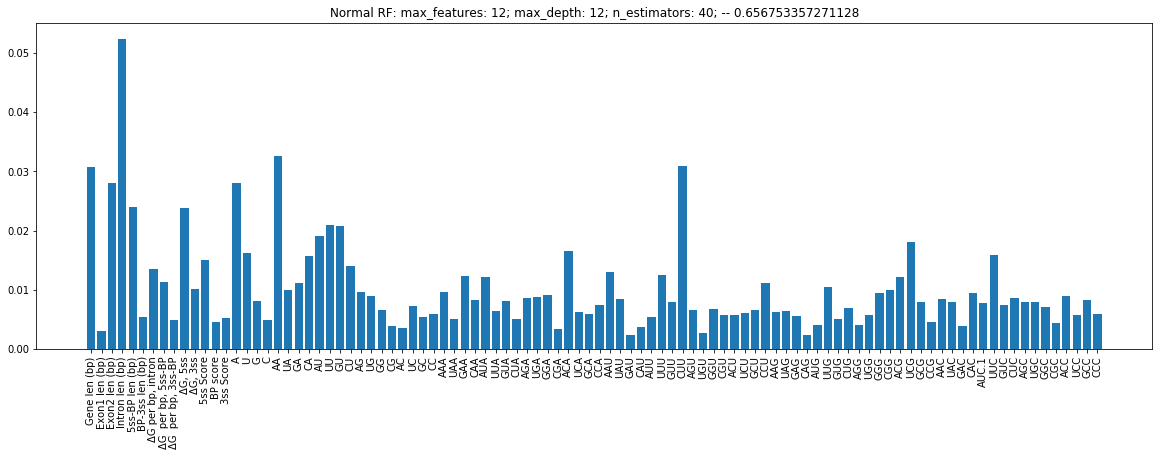

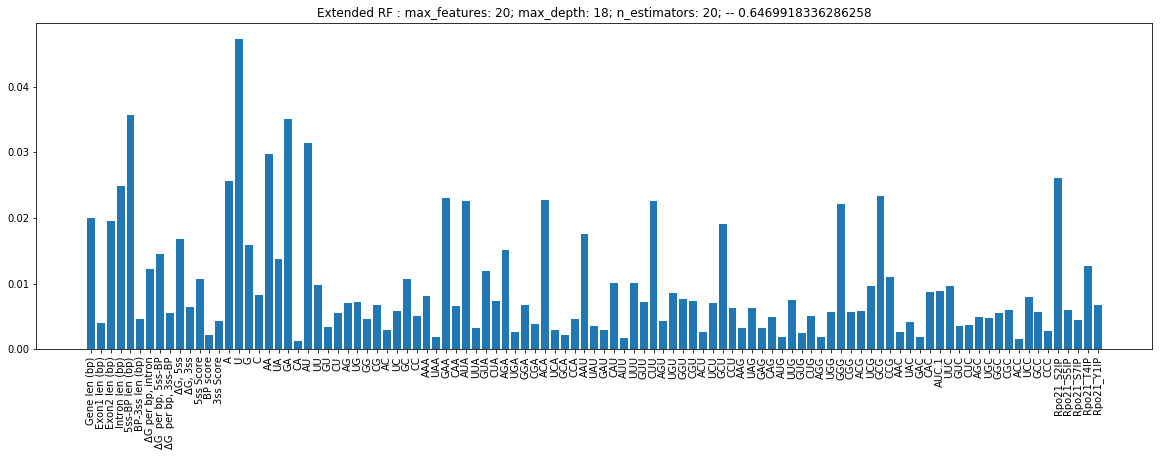

In [15]:
best_RFs(results_1_full,results_2_full,'full')

max_features: 80; max_depth: 18; n_estimators: 140;

Normal feature space
Coefficient of determination R^2: 0.3268145719369372
Mean squared error:               0.03510980684842549
Mean absolute error:              0.1408455669447836
Root mean squared error:          0.1873761106662893
Correlation Coefficient:          0.5943887690561563


Extended feature space
Coefficient of determination R^2: 0.33027678291052864
Mean squared error:               0.03492923615648248
Mean absolute error:              0.14119929337841644
Root mean squared error:          0.18689364932089716
Correlation Coefficient:          0.5995146762547735
-------------------------------------------------------



Text(0.5,1,'Extended RF : 0.5995146762547735')

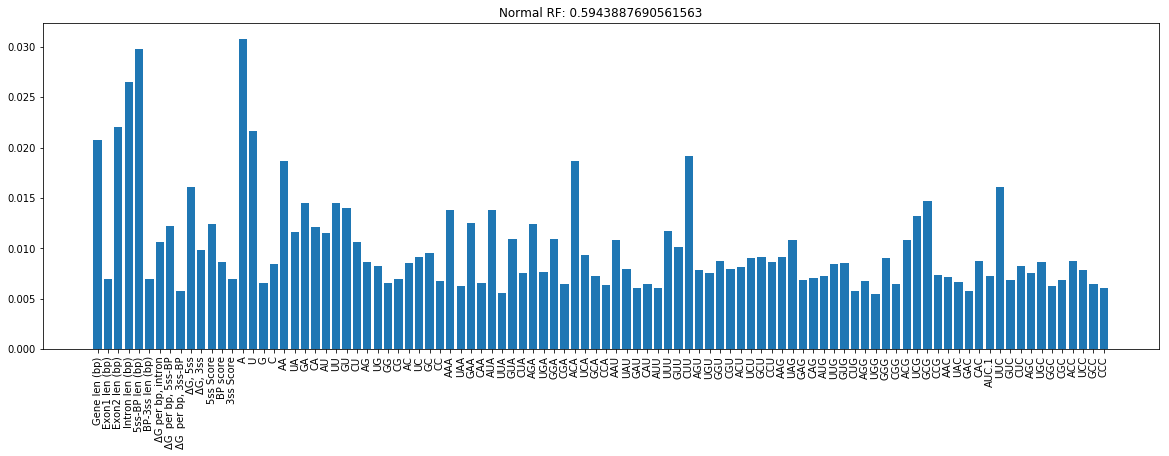

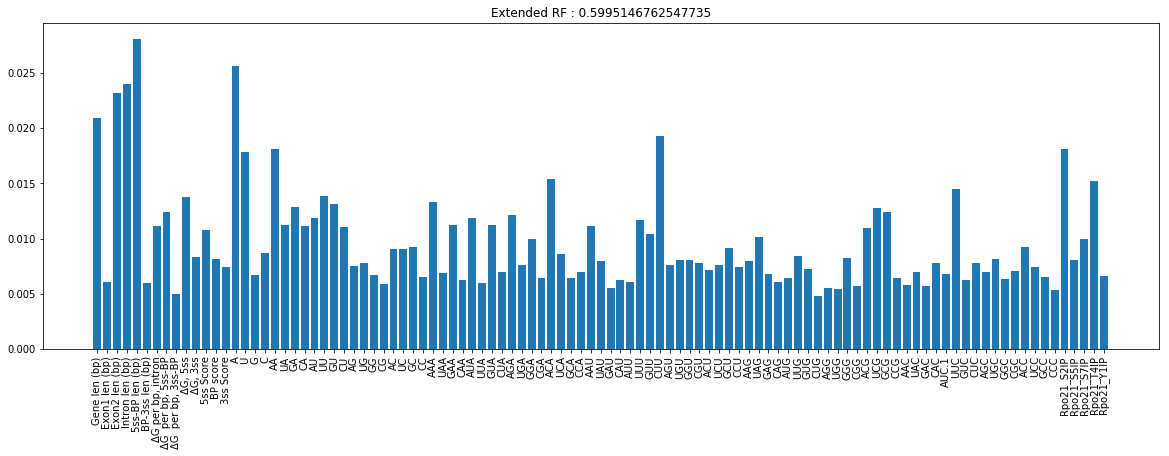

In [18]:
X,y,X2,y2 = get_data('full')
kf = KFold(n_splits=5,shuffle=True,random_state=0)

rfr1 = ExtraTreesRegressor(n_estimators=1000, 
                            criterion='mse', 
                            max_features=5, 
                            max_depth=20, 
                            n_jobs=2,
                            random_state=1337)

rfr2 = ExtraTreesRegressor(n_estimators=1000, 
                            criterion='mse', 
                            max_features=5, 
                            max_depth=20, 
                            n_jobs=2,
                            random_state=1337)

predictions_rfr1 = cross_val_predict(rfr1,X=X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(rfr2,X=X2,y=y2,cv=kf)

print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

print('Normal feature space')
print_stats(y, predictions_rfr1)
print('\n')
print('Extended feature space')
print_stats(y2, predictions_rfr2)
print('-------------------------------------------------------\n')

rfr1.fit(X,y)
fig, ax1 = plt.subplots(figsize=(20,6))
xx = np.arange(len(rfr1.feature_importances_))
ax1.bar(xx, rfr1.feature_importances_)
ax1.set_xticks(xx)
ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
ax1.set_title('Normal RF: {}'.format(np.corrcoef(y, predictions_rfr1)[0][1]))

rfr2.fit(X2,y2)
fig2, ax2 = plt.subplots(figsize=(20,6))
xx = np.arange(len(rfr2.feature_importances_))
ax2.bar(xx, rfr2.feature_importances_)
ax2.set_xticks(xx)
ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
ax2.set_title('Extended RF : {}'.format(np.corrcoef(y2, predictions_rfr2)[0][1]))

## MAE Results

Normal best: 0.6485849616979102 | max_features: 50; max_depth: 7; n_estimators: 10;

Extended best: 0.6406053037479402 | max_features: 5; max_depth: 20; n_estimators: 50;

Best difference: 0.10009093774816558 | max_features: 20; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.41756892464489404
Mean squared error:               0.03037653773504273
Mean absolute error:              0.1291034188034188
Root mean squared error:          0.1742886620955096
Correlation Coefficient:          0.6485849616979102


Extended feature space
Coefficient of determination R^2: 0.38691168381575647
Mean squared error:               0.03197545797179487
Mean absolute error:              0.13664094017094014
Root mean squared error:          0.1788168279882933
Correlation Coefficient:          0.6406053037479402


# RP Genes

In [16]:
X,y,X2,y2 = get_data('rp')

mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
md = [5,7,10,12,15,18,20]
n_est = [10,20,30,40,50,60,80,90,100,120,140,160]

results_1_rp = np.zeros((len(mxf),len(md),len(n_est)))
results_2_rp = np.zeros((len(mxf),len(md),len(n_est)))

f = FloatProgress(min=0, max=(len(mxf)*len(md)*len(n_est)))
display(f)


i = 0
for max_features in mxf:
    j = 0
    for max_depth in md:
        k = 0
        for n_estimators in n_est:            
            
            kf = KFold(n_splits=5,shuffle=True,random_state=0)

            rfr1 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X=X,y=y,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X=X2,y=y2,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print_stats(y, predictions_rfr1)
            print('\n')
            print('Extended feature space')
            print_stats(y2, predictions_rfr2)
            print('-------------------------------------------------------\n')
            

            results_1_rp[i][j][k]=np.corrcoef(y, predictions_rfr1)[0][1]
            results_2_rp[i][j][k]=np.corrcoef(y2, predictions_rfr2)[0][1]
            
            f.value += 1
            
            k += 1
        j += 1
    i += 1

FloatProgress(value=0.0, max=1008.0)

max_features: 5; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.10027375795449478
Mean squared error:               0.02665153606954605
Mean absolute error:              0.11646231505372565
Root mean squared error:          0.16325298180905012
Correlation Coefficient:          0.31914159548480064


Extended feature space
Coefficient of determination R^2: 0.2527228987345569
Mean squared error:               0.022135713828956523
Mean absolute error:              0.1107549838325703
Root mean squared error:          0.14878075758967127
Correlation Coefficient:          0.5441958462229596
-------------------------------------------------------

max_features: 5; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.1323152260784799
Mean squared error:               0.02570240920903995
Mean absolute error:              0.11636439120923
Root mean squared error:          0.16031970935926734
Correlation Coefficient:  

max_features: 5; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1994661881615608
Mean squared error:               0.023713274954165753
Mean absolute error:              0.11244071451686265
Root mean squared error:          0.15399115219442236
Correlation Coefficient:          0.45757579327382153


Extended feature space
Coefficient of determination R^2: 0.2343847871164031
Mean squared error:               0.022678922218796804
Mean absolute error:              0.1065922471937519
Root mean squared error:          0.15059522641437478
Correlation Coefficient:          0.4956794910129566
-------------------------------------------------------

max_features: 5; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.20978842574934808
Mean squared error:               0.02340751140684063
Mean absolute error:              0.10998267599039983
Root mean squared error:          0.1529951352391331
Correlation Coefficient

max_features: 5; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.19679634507157362
Mean squared error:               0.02379236058720348
Mean absolute error:              0.10573773929443574
Root mean squared error:          0.1542477247391464
Correlation Coefficient:          0.4473067875637104


Extended feature space
Coefficient of determination R^2: 0.2515213551022658
Mean squared error:               0.022171305747874365
Mean absolute error:              0.10553708803704076
Root mean squared error:          0.14890032151702817
Correlation Coefficient:          0.5096475321357073
-------------------------------------------------------

max_features: 5; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2249601325085614
Mean squared error:               0.02295809771739386
Mean absolute error:              0.10449145648437472
Root mean squared error:          0.15151929816823287
Correlation Coefficien

max_features: 5; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.19345257695498452
Mean squared error:               0.023891409111524462
Mean absolute error:              0.10622940476190475
Root mean squared error:          0.15456846092112214
Correlation Coefficient:          0.4580466207496567


Extended feature space
Coefficient of determination R^2: 0.2157265129825613
Mean squared error:               0.023231614407637522
Mean absolute error:              0.10913847349409848
Root mean squared error:          0.15241920616391336
Correlation Coefficient:          0.4674294364601481
-------------------------------------------------------

max_features: 5; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.21617179440851209
Mean squared error:               0.02321842435778653
Mean absolute error:              0.10643054647237686
Root mean squared error:          0.15237593103172997
Correlation Coeffic

max_features: 5; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1832049698474737
Mean squared error:               0.024194961967592594
Mean absolute error:              0.10589424603174605
Root mean squared error:          0.15554729816873256
Correlation Coefficient:          0.42866534157301167


Extended feature space
Coefficient of determination R^2: 0.22130783005656707
Mean squared error:               0.023066285592757946
Mean absolute error:              0.10879117063492062
Root mean squared error:          0.1518758887801416
Correlation Coefficient:          0.4708069017274088
-------------------------------------------------------

max_features: 5; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2127259468754903
Mean squared error:               0.02332049666103257
Mean absolute error:              0.1051879464285714
Root mean squared error:          0.1527104995114369
Correlation Coefficien

max_features: 5; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1813235046995164
Mean squared error:               0.0242506944047619
Mean absolute error:              0.10530357142857143
Root mean squared error:          0.15572634460733323
Correlation Coefficient:          0.42651160722481685


Extended feature space
Coefficient of determination R^2: 0.20363643018333855
Mean squared error:               0.023589744761904757
Mean absolute error:              0.11027619047619049
Root mean squared error:          0.15358953337354977
Correlation Coefficient:          0.45212408579541663
-------------------------------------------------------

max_features: 5; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.202167069776633
Mean squared error:               0.02363326990327381
Mean absolute error:              0.10607886904761903
Root mean squared error:          0.1537311611329135
Correlation Coefficien

max_features: 5; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.18142582628384907
Mean squared error:               0.024247663452380948
Mean absolute error:              0.1052892857142857
Root mean squared error:          0.1557166126409798
Correlation Coefficient:          0.42663368997100376


Extended feature space
Coefficient of determination R^2: 0.2139698813586054
Mean squared error:               0.023283649047619044
Mean absolute error:              0.10956190476190475
Root mean squared error:          0.15258980649971035
Correlation Coefficient:          0.46280760639265367
-------------------------------------------------------

max_features: 5; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.21336991607629252
Mean squared error:               0.023301421116071426
Mean absolute error:              0.10515476190476189
Root mean squared error:          0.15264803017422604
Correlation Coeffi

max_features: 7; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.06244681644320571
Mean squared error:               0.027772039228147645
Mean absolute error:              0.11717668514178667
Root mean squared error:          0.1666494501285487
Correlation Coefficient:          0.260345329106521


Extended feature space
Coefficient of determination R^2: -0.05496415353408235
Mean squared error:               0.03124996679664444
Mean absolute error:              0.12549569849642933
Root mean squared error:          0.17677660138334042
Correlation Coefficient:          0.10725956063281357
-------------------------------------------------------

max_features: 7; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.15113651906652847
Mean squared error:               0.025144888103724564
Mean absolute error:              0.11040270754927548
Root mean squared error:          0.15857139749565355
Correlation Coeffici

max_features: 7; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.14739228729867282
Mean squared error:               0.025255799093479487
Mean absolute error:              0.11159172578278863
Root mean squared error:          0.15892073210717186
Correlation Coefficient:          0.384210822980101


Extended feature space
Coefficient of determination R^2: 0.0446871844802601
Mean squared error:               0.028298111993088033
Mean absolute error:              0.11669161377270047
Root mean squared error:          0.16822042680093294
Correlation Coefficient:          0.24756469354578384
-------------------------------------------------------

max_features: 7; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.17119782334739764
Mean squared error:               0.02455063559706412
Mean absolute error:              0.10929520428477431
Root mean squared error:          0.1566864244185313
Correlation Coefficien

max_features: 7; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.22801774021599708
Mean squared error:               0.022867525787518855
Mean absolute error:              0.10926999064903738
Root mean squared error:          0.1512201236195727
Correlation Coefficient:          0.4825348636931735


Extended feature space
Coefficient of determination R^2: 0.09730394692926081
Mean squared error:               0.026739507301194038
Mean absolute error:              0.11862655919749407
Root mean squared error:          0.16352219207555296
Correlation Coefficient:          0.3178319348279617
-------------------------------------------------------

max_features: 7; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.22912607378413996
Mean squared error:               0.022834694921097427
Mean absolute error:              0.10581601119296764
Root mean squared error:          0.15111153139683756
Correlation Coeffi

max_features: 7; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1174314522666382
Mean squared error:               0.026143293798218357
Mean absolute error:              0.1126804655612245
Root mean squared error:          0.16168887963684564
Correlation Coefficient:          0.3451806119580347


Extended feature space
Coefficient of determination R^2: 0.05647627461739002
Mean squared error:               0.027948897591713536
Mean absolute error:              0.12132102324263042
Root mean squared error:          0.16717923792060285
Correlation Coefficient:          0.27600472637660023
-------------------------------------------------------

max_features: 7; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.20488497343098322
Mean squared error:               0.023552760628460633
Mean absolute error:              0.10830359611205594
Root mean squared error:          0.15346908688221428
Correlation Coeffi

max_features: 7; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.13462592955976627
Mean squared error:               0.02563396194775132
Mean absolute error:              0.11332918650793648
Root mean squared error:          0.1601060959106533
Correlation Coefficient:          0.36776245043211303


Extended feature space
Coefficient of determination R^2: 0.08579427863864364
Mean squared error:               0.027080444716666666
Mean absolute error:              0.11578
Root mean squared error:          0.1645613706696279
Correlation Coefficient:          0.3121218315854931
-------------------------------------------------------

max_features: 7; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.1969566936549909
Mean squared error:               0.023787610769031083
Mean absolute error:              0.11083590277777777
Root mean squared error:          0.15423232725025932
Correlation Coefficient:        

max_features: 7; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1257866002495619
Mean squared error:               0.025895799041005283
Mean absolute error:              0.1141793650793651
Root mean squared error:          0.16092171712048464
Correlation Coefficient:          0.3556442837324944


Extended feature space
Coefficient of determination R^2: 0.08201382814033875
Mean squared error:               0.02719242857142858
Mean absolute error:              0.11617857142857144
Root mean squared error:          0.16490126916257672
Correlation Coefficient:          0.29536115811395663
-------------------------------------------------------

max_features: 7; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.18328733031663047
Mean squared error:               0.024192522299933857
Mean absolute error:              0.11079980158730156
Root mean squared error:          0.15553945576584052
Correlation Coeffic

max_features: 7; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.11971649863159062
Mean squared error:               0.02607560654761904
Mean absolute error:              0.11436785714285713
Root mean squared error:          0.16147943072608054
Correlation Coefficient:          0.34850191629979355


Extended feature space
Coefficient of determination R^2: 0.08199685224198006
Mean squared error:               0.027192931428571425
Mean absolute error:              0.11617857142857141
Root mean squared error:          0.16490279387739742
Correlation Coefficient:          0.29541088067582605
-------------------------------------------------------

max_features: 7; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.18262604520564985
Mean squared error:               0.02421211077380952
Mean absolute error:              0.11052023809523807
Root mean squared error:          0.15560241249353918
Correlation Coeff

max_features: 10; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.19535657974944176
Mean squared error:               0.02383500906806499
Mean absolute error:              0.10914821895676415
Root mean squared error:          0.15438590955156817
Correlation Coefficient:          0.4518873531546675


Extended feature space
Coefficient of determination R^2: 0.22062934165714732
Mean squared error:               0.023086383659486325
Mean absolute error:              0.10904256371493769
Root mean squared error:          0.15194204046111243
Correlation Coefficient:          0.5052132164194366
-------------------------------------------------------

max_features: 10; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.23280253509765314
Mean squared error:               0.022725791416090588
Mean absolute error:              0.10577814504075941
Root mean squared error:          0.15075075925543654
Correlation Coeffi

max_features: 10; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1994354754754979
Mean squared error:               0.02371418472007248
Mean absolute error:              0.11026192336987932
Root mean squared error:          0.15399410612121647
Correlation Coefficient:          0.4473673987909237


Extended feature space
Coefficient of determination R^2: 0.1884721689177179
Mean squared error:               0.024038937902220284
Mean absolute error:              0.11218572760844109
Root mean squared error:          0.1550449544558619
Correlation Coefficient:          0.4446537956308312
-------------------------------------------------------

max_features: 10; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.25598561082623417
Mean squared error:               0.0220390663322711
Mean absolute error:              0.10589950999639143
Root mean squared error:          0.14845560390996057
Correlation Coefficient

max_features: 10; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.20618462627892375
Mean squared error:               0.02351426253522282
Mean absolute error:              0.11353332891645392
Root mean squared error:          0.15334360937196834
Correlation Coefficient:          0.45492135139623724


Extended feature space
Coefficient of determination R^2: 0.158769483711239
Mean squared error:               0.02491878573720519
Mean absolute error:              0.11730012886506071
Root mean squared error:          0.1578568520438856
Correlation Coefficient:          0.3994754340479921
-------------------------------------------------------

max_features: 10; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.29054854208903924
Mean squared error:               0.02101524912413269
Mean absolute error:              0.10552037249952428
Root mean squared error:          0.14496637239074686
Correlation Coeffici

max_features: 10; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.22597335067015
Mean squared error:               0.02292808434319405
Mean absolute error:              0.10671843065003779
Root mean squared error:          0.15142022435326813
Correlation Coefficient:          0.47661956158777463


Extended feature space
Coefficient of determination R^2: 0.22567949673548704
Mean squared error:               0.02293678883393008
Mean absolute error:              0.11354744472789113
Root mean squared error:          0.15144896445314535
Correlation Coefficient:          0.4878812338481948
-------------------------------------------------------

max_features: 10; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2695377810366022
Mean squared error:               0.021637626276059
Mean absolute error:              0.10706035052910053
Root mean squared error:          0.14709733606037534
Correlation Coefficient

max_features: 10; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.20936927952555595
Mean squared error:               0.02341992728422619
Mean absolute error:              0.11502470238095237
Root mean squared error:          0.15303570591279078
Correlation Coefficient:          0.4585959729277691


Extended feature space
Coefficient of determination R^2: 0.16299419249064195
Mean squared error:               0.02479364214001322
Mean absolute error:              0.11870738095238095
Root mean squared error:          0.15745996996066403
Correlation Coefficient:          0.40802195909224237
-------------------------------------------------------

max_features: 10; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.23029776516024703
Mean squared error:               0.022799987280580355
Mean absolute error:              0.11285413690476193
Root mean squared error:          0.1509966465872019
Correlation Coeff

max_features: 10; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1643766872118242
Mean squared error:               0.024752690119047623
Mean absolute error:              0.11832499999999999
Root mean squared error:          0.1573298767527885
Correlation Coefficient:          0.4140405793085182


Extended feature space
Coefficient of determination R^2: 0.17645525666924788
Mean squared error:               0.0243949008110119
Mean absolute error:              0.1193217261904762
Root mean squared error:          0.15618867055907704
Correlation Coefficient:          0.42696944094615713
-------------------------------------------------------

max_features: 10; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.21039733288702955
Mean squared error:               0.023389474464285714
Mean absolute error:              0.11465595238095239
Root mean squared error:          0.15293617774838533
Correlation Coeffic

max_features: 10; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.16733223773554895
Mean squared error:               0.024665141309523814
Mean absolute error:              0.1181035714285714
Root mean squared error:          0.15705139703142987
Correlation Coefficient:          0.41707346580445503


Extended feature space
Coefficient of determination R^2: 0.1596131952238501
Mean squared error:               0.024893793459821435
Mean absolute error:              0.11969315476190474
Root mean squared error:          0.15777767097983617
Correlation Coefficient:          0.4096517193719012
-------------------------------------------------------

max_features: 10; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2116642537465825
Mean squared error:               0.02335194595238095
Mean absolute error:              0.11446666666666665
Root mean squared error:          0.1528134351174037
Correlation Coeffic

max_features: 12; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.15628077805829288
Mean squared error:               0.0249925057482223
Mean absolute error:              0.1126872318940881
Root mean squared error:          0.1580901823271208
Correlation Coefficient:          0.40061065006002583


Extended feature space
Coefficient of determination R^2: 0.1543786625399961
Mean squared error:               0.02504884988711179
Mean absolute error:              0.1132607042102426
Root mean squared error:          0.15826828452697586
Correlation Coefficient:          0.39384978005903964
-------------------------------------------------------

max_features: 12; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.25120176777131487
Mean squared error:               0.022180772508851396
Mean absolute error:              0.10376710081578282
Root mean squared error:          0.1489321070449599
Correlation Coefficient

max_features: 12; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.21690808711007004
Mean squared error:               0.023196614021957378
Mean absolute error:              0.10851743080086373
Root mean squared error:          0.15230434669423384
Correlation Coefficient:          0.46682564860088344


Extended feature space
Coefficient of determination R^2: 0.24075920732075484
Mean squared error:               0.02249010023933282
Mean absolute error:              0.10207688872115574
Root mean squared error:          0.1499669971671528
Correlation Coefficient:          0.5049594032018812
-------------------------------------------------------

max_features: 12; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2903467510786577
Mean squared error:               0.021021226542752233
Mean absolute error:              0.10254296531151127
Root mean squared error:          0.14498698749457564
Correlation Coeffic

max_features: 12; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.21780081478594082
Mean squared error:               0.02317016979621193
Mean absolute error:              0.10813530899325541
Root mean squared error:          0.15221750817896057
Correlation Coefficient:          0.47052131789458745


Extended feature space
Coefficient of determination R^2: 0.20710954706615936
Mean squared error:               0.023486864690666857
Mean absolute error:              0.11252918318978718
Root mean squared error:          0.15325424852403557
Correlation Coefficient:          0.4601064765178343
-------------------------------------------------------

max_features: 12; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2948244513524213
Mean squared error:               0.020888588875006192
Mean absolute error:              0.10445704842941451
Root mean squared error:          0.14452885135849586
Correlation Coef

max_features: 12; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.16873700574413808
Mean squared error:               0.02462352951306766
Mean absolute error:              0.10873727277021918
Root mean squared error:          0.1569188628338469
Correlation Coefficient:          0.4196305553748804


Extended feature space
Coefficient of determination R^2: 0.1828843993180158
Mean squared error:               0.02420445785270678
Mean absolute error:              0.11022146258503404
Root mean squared error:          0.15557781928252748
Correlation Coefficient:          0.4290679790894983
-------------------------------------------------------

max_features: 12; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.30168283354702186
Mean squared error:               0.020685431056665173
Mean absolute error:              0.10330077758881331
Root mean squared error:          0.14382430620957354
Correlation Coeffic

max_features: 12; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1746178023560816
Mean squared error:               0.024449329566798947
Mean absolute error:              0.10821527777777781
Root mean squared error:          0.1563628138874424
Correlation Coefficient:          0.4275406610830053


Extended feature space
Coefficient of determination R^2: 0.20066192031490215
Mean squared error:               0.023677855181878305
Mean absolute error:              0.11118551587301585
Root mean squared error:          0.15387610334902008
Correlation Coefficient:          0.4502749195775218
-------------------------------------------------------

max_features: 12; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.29710549865355074
Mean squared error:               0.02082102008398796
Mean absolute error:              0.10206816893424038
Root mean squared error:          0.14429490664603503
Correlation Coeffi

max_features: 12; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.18389079986983858
Mean squared error:               0.024174646428571436
Mean absolute error:              0.10719285714285716
Root mean squared error:          0.15548198104144234
Correlation Coefficient:          0.4359045828059363


Extended feature space
Coefficient of determination R^2: 0.17260660997032917
Mean squared error:               0.024508904761904756
Mean absolute error:              0.1141047619047619
Root mean squared error:          0.15655320105927173
Correlation Coefficient:          0.41665130047555365
-------------------------------------------------------

max_features: 12; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.30174807210119736
Mean squared error:               0.020683498571428573
Mean absolute error:              0.10098809523809527
Root mean squared error:          0.14381758783760967
Correlation Coe

max_features: 12; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.18389079986983858
Mean squared error:               0.024174646428571436
Mean absolute error:              0.10719285714285716
Root mean squared error:          0.15548198104144234
Correlation Coefficient:          0.4359045828059363


Extended feature space
Coefficient of determination R^2: 0.17260660997032895
Mean squared error:               0.024508904761904763
Mean absolute error:              0.1141047619047619
Root mean squared error:          0.15655320105927173
Correlation Coefficient:          0.41665130047555365
-------------------------------------------------------

max_features: 12; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3037929133021069
Mean squared error:               0.020622926636904765
Mean absolute error:              0.10051964285714285
Root mean squared error:          0.14360684745827673
Correlation Coef

max_features: 15; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.05736569970685301
Mean squared error:               0.027922551194614915
Mean absolute error:              0.11582926927595147
Root mean squared error:          0.16710042248484866
Correlation Coefficient:          0.2866302462983005


Extended feature space
Coefficient of determination R^2: 0.2594738769167493
Mean squared error:               0.021935737513807188
Mean absolute error:              0.10473038449133448
Root mean squared error:          0.14810718251930657
Correlation Coefficient:          0.5334128464382352
-------------------------------------------------------

max_features: 15; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.11712033322703497
Mean squared error:               0.02615250971292488
Mean absolute error:              0.1130563431880203
Root mean squared error:          0.1617173760389553
Correlation Coefficie

max_features: 15; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.10128494862923987
Mean squared error:               0.026621582753212976
Mean absolute error:              0.1153774966118071
Root mean squared error:          0.16316121706218356
Correlation Coefficient:          0.3401149777491008


Extended feature space
Coefficient of determination R^2: 0.2547448092810468
Mean squared error:               0.02207582114233591
Mean absolute error:              0.10841254834071881
Root mean squared error:          0.1485793429193167
Correlation Coefficient:          0.5100762331207386
-------------------------------------------------------

max_features: 15; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.18555311658875795
Mean squared error:               0.024125405568493193
Mean absolute error:              0.11028539838857962
Root mean squared error:          0.15532355123577749
Correlation Coefficie

max_features: 15; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1924388345370669
Mean squared error:               0.023921438015155123
Mean absolute error:              0.11062952022679699
Root mean squared error:          0.1546655682922192
Correlation Coefficient:          0.4397947676509744


Extended feature space
Coefficient of determination R^2: 0.28077000558547793
Mean squared error:               0.02130490725140876
Mean absolute error:              0.10662353669478666
Root mean squared error:          0.14596200619136734
Correlation Coefficient:          0.5460841464926228
-------------------------------------------------------

max_features: 15; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.201816745154752
Mean squared error:               0.02364364715899871
Mean absolute error:              0.10771160525928514
Root mean squared error:          0.15376490873732768
Correlation Coefficie

max_features: 15; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1030203702825695
Mean squared error:               0.02657017639133513
Mean absolute error:              0.11544304185563112
Root mean squared error:          0.16300360852243465
Correlation Coefficient:          0.34855697281921644


Extended feature space
Coefficient of determination R^2: 0.30060069510669507
Mean squared error:               0.020717485975513646
Mean absolute error:              0.09981165431129721
Root mean squared error:          0.1439357008372615
Correlation Coefficient:          0.5510717432807553
-------------------------------------------------------

max_features: 15; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.192935267692806
Mean squared error:               0.023906732757557857
Mean absolute error:              0.10833731127173094
Root mean squared error:          0.1546180220981948
Correlation Coeffici

max_features: 15; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.14832771864040895
Mean squared error:               0.025228089907084986
Mean absolute error:              0.11361618055555558
Root mean squared error:          0.1588335289134035
Correlation Coefficient:          0.3967328011228928


Extended feature space
Coefficient of determination R^2: 0.2440094015379436
Mean squared error:               0.022393823544973542
Mean absolute error:              0.10818075396825395
Root mean squared error:          0.1496456599603662
Correlation Coefficient:          0.4943575429134714
-------------------------------------------------------

max_features: 15; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.23385544695198035
Mean squared error:               0.022694602242148237
Mean absolute error:              0.1053945783730159
Root mean squared error:          0.15064727757961058
Correlation Coeffic

max_features: 15; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.11382869925523154
Mean squared error:               0.026250013928571424
Mean absolute error:              0.11468690476190477
Root mean squared error:          0.16201856044469543
Correlation Coefficient:          0.3590584898444411


Extended feature space
Coefficient of determination R^2: 0.20307292500327456
Mean squared error:               0.02360643681547619
Mean absolute error:              0.11065773809523809
Root mean squared error:          0.1536438635789799
Correlation Coefficient:          0.4568437553192596
-------------------------------------------------------

max_features: 15; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.21653714889888487
Mean squared error:               0.023207601889880955
Mean absolute error:              0.10511369047619051
Root mean squared error:          0.15234041449950486
Correlation Coeff

max_features: 15; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.12525204409808455
Mean squared error:               0.025911633571428568
Mean absolute error:              0.11294285714285714
Root mean squared error:          0.16097090908430806
Correlation Coefficient:          0.3688381400874429


Extended feature space
Coefficient of determination R^2: 0.22248089911212077
Mean squared error:               0.02303153714285714
Mean absolute error:              0.10921190476190476
Root mean squared error:          0.15176144814430687
Correlation Coefficient:          0.4765221846423877
-------------------------------------------------------

max_features: 15; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.21816329296985149
Mean squared error:               0.02315943252976191
Mean absolute error:              0.1043077380952381
Root mean squared error:          0.1521822346062835
Correlation Coeffic

max_features: 18; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1878889773877147
Mean squared error:               0.02405621310146533
Mean absolute error:              0.10937746722188668
Root mean squared error:          0.15510065474221998
Correlation Coefficient:          0.4335538168483867


Extended feature space
Coefficient of determination R^2: 0.31519161320536593
Mean squared error:               0.020285276307925836
Mean absolute error:              0.10357667355812093
Root mean squared error:          0.1424263890854705
Correlation Coefficient:          0.5988040574971333
-------------------------------------------------------

max_features: 18; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.24339316863075167
Mean squared error:               0.022412077490213518
Mean absolute error:              0.10890686074228312
Root mean squared error:          0.1497066380966907
Correlation Coefficie

max_features: 18; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2828380907190218
Mean squared error:               0.021243646789108332
Mean absolute error:              0.10635527021009338
Root mean squared error:          0.14575200440854436
Correlation Coefficient:          0.539024675294934


Extended feature space
Coefficient of determination R^2: 0.30624489155177514
Mean squared error:               0.020550294558713728
Mean absolute error:              0.10365647631092675
Root mean squared error:          0.1433537392561273
Correlation Coefficient:          0.5756839164270079
-------------------------------------------------------

max_features: 18; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2741410042087734
Mean squared error:               0.02150127039059502
Mean absolute error:              0.10483192875204203
Root mean squared error:          0.14663311491813513
Correlation Coefficien

max_features: 18; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2128443117641
Mean squared error:               0.02331699047665033
Mean absolute error:              0.10750619606097052
Root mean squared error:          0.15269901923932036
Correlation Coefficient:          0.462385910809306


Extended feature space
Coefficient of determination R^2: 0.32685831304164903
Mean squared error:               0.019939687331002855
Mean absolute error:              0.1064542373669911
Root mean squared error:          0.141207957746732
Correlation Coefficient:          0.5871708494091683
-------------------------------------------------------

max_features: 18; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.23047271527866586
Mean squared error:               0.0227948049382483
Mean absolute error:              0.10624508504628694
Root mean squared error:          0.15097948515691892
Correlation Coefficient:  

max_features: 18; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.28183879791691857
Mean squared error:               0.02127324766870338
Mean absolute error:              0.10698845457617778
Root mean squared error:          0.14585351442013106
Correlation Coefficient:          0.5320275002779874


Extended feature space
Coefficient of determination R^2: 0.3402737547133169
Mean squared error:               0.019542297424059066
Mean absolute error:              0.09795832431457431
Root mean squared error:          0.13979376747215544
Correlation Coefficient:          0.6025847787591601
-------------------------------------------------------

max_features: 18; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2956739460673815
Mean squared error:               0.020863425288596645
Mean absolute error:              0.10425268385467046
Root mean squared error:          0.14444177127339808
Correlation Coeffi

max_features: 18; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.27226161047885744
Mean squared error:               0.021556941468575203
Mean absolute error:              0.10744753401360545
Root mean squared error:          0.14682282339123984
Correlation Coefficient:          0.5257923420526116


Extended feature space
Coefficient of determination R^2: 0.3165803881964596
Mean squared error:               0.020244138253884564
Mean absolute error:              0.10556931405895692
Root mean squared error:          0.1422818971404464
Correlation Coefficient:          0.5761877641233526
-------------------------------------------------------

max_features: 18; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3126538807665121
Mean squared error:               0.020360448581966888
Mean absolute error:              0.1013282383786848
Root mean squared error:          0.14269004373805094
Correlation Coeffic

max_features: 18; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.28338854358139776
Mean squared error:               0.02122734136904762
Mean absolute error:              0.10597738095238096
Root mean squared error:          0.14569605817951156
Correlation Coefficient:          0.5348992522659215


Extended feature space
Coefficient of determination R^2: 0.2801635790400726
Mean squared error:               0.021322870714285708
Mean absolute error:              0.10600238095238095
Root mean squared error:          0.14602352794767598
Correlation Coefficient:          0.5400698132778798
-------------------------------------------------------

max_features: 18; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3222824713156258
Mean squared error:               0.02007523212797619
Mean absolute error:              0.09935773809523811
Root mean squared error:          0.1416870923125187
Correlation Coeffici

max_features: 18; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2730417275031968
Mean squared error:               0.02153383297619048
Mean absolute error:              0.107175
Root mean squared error:          0.14674410712594382
Correlation Coefficient:          0.5249846916637477


Extended feature space
Coefficient of determination R^2: 0.27159552082126126
Mean squared error:               0.02157667226190476
Mean absolute error:              0.10714642857142856
Root mean squared error:          0.14689000055110885
Correlation Coefficient:          0.5302282305722751
-------------------------------------------------------

max_features: 18; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.31800614897873225
Mean squared error:               0.020201904613095237
Mean absolute error:              0.09995654761904764
Root mean squared error:          0.14213340428307217
Correlation Coefficient:     

max_features: 20; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.16895094881259842
Mean squared error:               0.024617192128272774
Mean absolute error:              0.11391077302374507
Root mean squared error:          0.15689866834448524
Correlation Coefficient:          0.41173435708956374


Extended feature space
Coefficient of determination R^2: 0.22378163284081298
Mean squared error:               0.022993007031955517
Mean absolute error:              0.10577035227952167
Root mean squared error:          0.1516344519954338
Correlation Coefficient:          0.4838697154756385
-------------------------------------------------------

max_features: 20; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.20908429856884503
Mean squared error:               0.023428368941134682
Mean absolute error:              0.10889309538957821
Root mean squared error:          0.153063284105414
Correlation Coeffic

max_features: 20; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.16145002373557904
Mean squared error:               0.02483938324141698
Mean absolute error:              0.11404457458962652
Root mean squared error:          0.1576051497934537
Correlation Coefficient:          0.4079562575743991


Extended feature space
Coefficient of determination R^2: 0.2105666116631304
Mean squared error:               0.023384460117480844
Mean absolute error:              0.10729849472657527
Root mean squared error:          0.15291978327698755
Correlation Coefficient:          0.4698949624162152
-------------------------------------------------------

max_features: 20; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.25871274895496643
Mean squared error:               0.021958283515445282
Mean absolute error:              0.10258456749682152
Root mean squared error:          0.14818327677388324
Correlation Coeffici

max_features: 20; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1620138674554763
Mean squared error:               0.024822681159676802
Mean absolute error:              0.109005913793142
Root mean squared error:          0.15755215377669962
Correlation Coefficient:          0.40715861636961187


Extended feature space
Coefficient of determination R^2: 0.1988255572940696
Mean squared error:               0.02373225161159145
Mean absolute error:              0.10815300671783866
Root mean squared error:          0.15405275593637216
Correlation Coefficient:          0.4503838938409262
-------------------------------------------------------

max_features: 20; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.22472397757503826
Mean squared error:               0.022965093058237185
Mean absolute error:              0.10248267229876606
Root mean squared error:          0.15154238040309775
Correlation Coeffic

max_features: 20; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.14766384416239609
Mean squared error:               0.025247755082745734
Mean absolute error:              0.11371234682761996
Root mean squared error:          0.1588954218432543
Correlation Coefficient:          0.3877505705438388


Extended feature space
Coefficient of determination R^2: 0.24806048224418897
Mean squared error:               0.02227382312871617
Mean absolute error:              0.10141078852753224
Root mean squared error:          0.1492441728467687
Correlation Coefficient:          0.5122688180816979
-------------------------------------------------------

max_features: 20; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2482506198831277
Mean squared error:               0.022268190904262172
Mean absolute error:              0.10232914097204539
Root mean squared error:          0.14922530249345173
Correlation Coeffic

max_features: 20; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.11187365260114235
Mean squared error:               0.026307925984465942
Mean absolute error:              0.114166875
Root mean squared error:          0.1621971824183945
Correlation Coefficient:          0.3503692988254594


Extended feature space
Coefficient of determination R^2: 0.2171269016417695
Mean squared error:               0.023190132335515874
Mean absolute error:              0.10578242063492065
Root mean squared error:          0.1522830664765977
Correlation Coefficient:          0.47321228343739513
-------------------------------------------------------

max_features: 20; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.20598849756929272
Mean squared error:               0.023520072226142937
Mean absolute error:              0.1057347867063492
Root mean squared error:          0.15336255157678794
Correlation Coefficient:  

max_features: 20; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1639854777323806
Mean squared error:               0.02476427845899471
Mean absolute error:              0.11352579365079365
Root mean squared error:          0.15736670060401822
Correlation Coefficient:          0.40951838797231566


Extended feature space
Coefficient of determination R^2: 0.21808056058357228
Mean squared error:               0.023161883214285712
Mean absolute error:              0.10605833333333332
Root mean squared error:          0.15219028620212827
Correlation Coefficient:          0.47558447460700787
-------------------------------------------------------

max_features: 20; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.23843811984841567
Mean squared error:               0.022558855093419306
Mean absolute error:              0.10439474206349206
Root mean squared error:          0.1501960555188428
Correlation Coef

max_features: 20; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.15939160454041534
Mean squared error:               0.02490035738095239
Mean absolute error:              0.11434047619047619
Root mean squared error:          0.1577984707814128
Correlation Coefficient:          0.4038201390945876


Extended feature space
Coefficient of determination R^2: 0.21982278851205872
Mean squared error:               0.02311027523809524
Mean absolute error:              0.1062809523809524
Root mean squared error:          0.15202064082911648
Correlation Coefficient:          0.4771872589586375
-------------------------------------------------------

max_features: 20; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.23479285326238253
Mean squared error:               0.02266683455357143
Mean absolute error:              0.10503392857142856
Root mean squared error:          0.15055508810256607
Correlation Coeffici

max_features: 25; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.28574018804047274
Mean squared error:               0.021157681361153112
Mean absolute error:              0.10127066575564651
Root mean squared error:          0.14545680238872677
Correlation Coefficient:          0.5345895165201918


Extended feature space
Coefficient of determination R^2: 0.293779446192009
Mean squared error:               0.020919543838220638
Mean absolute error:              0.10279618744736094
Root mean squared error:          0.14463590093134082
Correlation Coefficient:          0.5549295088725567
-------------------------------------------------------

max_features: 25; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.32350734748615606
Mean squared error:               0.020038949056621732
Mean absolute error:              0.09954244403913376
Root mean squared error:          0.1415589949689589
Correlation Coeffici

max_features: 25; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.23309945856975534
Mean squared error:               0.02271699600004422
Mean absolute error:              0.10321597130890121
Root mean squared error:          0.15072158438672353
Correlation Coefficient:          0.4853499057291747


Extended feature space
Coefficient of determination R^2: 0.3050263036685674
Mean squared error:               0.02058639135950214
Mean absolute error:              0.10217426882257155
Root mean squared error:          0.14347958516632997
Correlation Coefficient:          0.5588594901913315
-------------------------------------------------------

max_features: 25; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.29275873871200586
Mean squared error:               0.020949779059723027
Mean absolute error:              0.10045790453959709
Root mean squared error:          0.14474038503376668
Correlation Coeffici

max_features: 25; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.16301005076825248
Mean squared error:               0.024793172388840046
Mean absolute error:              0.10960149221833777
Root mean squared error:          0.15745847830091603
Correlation Coefficient:          0.4147428706187149


Extended feature space
Coefficient of determination R^2: 0.2982215937275159
Mean squared error:               0.02078795930757535
Mean absolute error:              0.1019862563611997
Root mean squared error:          0.1441803013853673
Correlation Coefficient:          0.5542707261679126
-------------------------------------------------------

max_features: 25; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2614354976247979
Mean squared error:               0.021877630722416434
Mean absolute error:              0.10387651519723388
Root mean squared error:          0.14791088777509395
Correlation Coeffici

max_features: 25; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2481116358711858
Mean squared error:               0.022272307864771117
Mean absolute error:              0.10502370017451425
Root mean squared error:          0.1492390963011071
Correlation Coefficient:          0.5007786655258839


Extended feature space
Coefficient of determination R^2: 0.2896694405923874
Mean squared error:               0.021041289717539796
Mean absolute error:              0.10356894982993198
Root mean squared error:          0.1450561605638995
Correlation Coefficient:          0.5412098457419953
-------------------------------------------------------

max_features: 25; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3145590285524674
Mean squared error:               0.020304014621766096
Mean absolute error:              0.1008570116733562
Root mean squared error:          0.1424921563517308
Correlation Coefficien

max_features: 25; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2657158180593956
Mean squared error:               0.021750839806334507
Mean absolute error:              0.10416130952380952
Root mean squared error:          0.1474816592201705
Correlation Coefficient:          0.5154928439269526


Extended feature space
Coefficient of determination R^2: 0.3780251677099349
Mean squared error:               0.01842403155813492
Mean absolute error:              0.09373063492063494
Root mean squared error:          0.13573515225664617
Correlation Coefficient:          0.6313689899700217
-------------------------------------------------------

max_features: 25; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2823437455734267
Mean squared error:               0.021258290196028064
Mean absolute error:              0.1043067857142857
Root mean squared error:          0.14580222973613285
Correlation Coefficie

max_features: 25; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.25699492299516624
Mean squared error:               0.022009168660714284
Mean absolute error:              0.10353988095238091
Root mean squared error:          0.14835487407131012
Correlation Coefficient:          0.5078323805205988


Extended feature space
Coefficient of determination R^2: 0.37144356725929206
Mean squared error:               0.01861899059523809
Mean absolute error:              0.09307738095238095
Root mean squared error:          0.1364514221077893
Correlation Coefficient:          0.6272377282698791
-------------------------------------------------------

max_features: 25; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.29609386841073193
Mean squared error:               0.020850986421130948
Mean absolute error:              0.10249434523809525
Root mean squared error:          0.14439870643856526
Correlation Coeff

max_features: 25; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.23715178475317222
Mean squared error:               0.022596958690476183
Mean absolute error:              0.10433928571428569
Root mean squared error:          0.15032284819838992
Correlation Coefficient:          0.48743662155962136


Extended feature space
Coefficient of determination R^2: 0.3676354802074425
Mean squared error:               0.018731793095238095
Mean absolute error:              0.09425714285714284
Root mean squared error:          0.13686414101304292
Correlation Coefficient:          0.6235116385273863
-------------------------------------------------------

max_features: 25; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2848863420841694
Mean squared error:               0.021182973839285704
Mean absolute error:              0.10301369047619048
Root mean squared error:          0.14554371796572227
Correlation Coef

max_features: 30; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.17388052335696524
Mean squared error:               0.024471169118564822
Mean absolute error:              0.11115344300738654
Root mean squared error:          0.15643263444232097
Correlation Coefficient:          0.420020379890694


Extended feature space
Coefficient of determination R^2: 0.28953467987935355
Mean squared error:               0.021045281576214513
Mean absolute error:              0.10249980795195207
Root mean squared error:          0.14506991961193924
Correlation Coefficient:          0.5452993042128162
-------------------------------------------------------

max_features: 30; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.25987948822430207
Mean squared error:               0.021923722565383674
Mean absolute error:              0.10195721586767985
Root mean squared error:          0.1480666152965741
Correlation Coeffic

max_features: 30; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.18036726738388842
Mean squared error:               0.024279019902138262
Mean absolute error:              0.11025406037718719
Root mean squared error:          0.15581726445467545
Correlation Coefficient:          0.4260128529408673


Extended feature space
Coefficient of determination R^2: 0.27524523583498794
Mean squared error:               0.02146856103119223
Mean absolute error:              0.10474329757288786
Root mean squared error:          0.14652153777241156
Correlation Coefficient:          0.5321674234525413
-------------------------------------------------------

max_features: 30; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.28720520503812597
Mean squared error:               0.02111428487950033
Mean absolute error:              0.0999229751849668
Root mean squared error:          0.14530755272696713
Correlation Coeffici

max_features: 30; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.24660828248703603
Mean squared error:               0.022316839940274273
Mean absolute error:              0.10750709052434104
Root mean squared error:          0.14938821888045348
Correlation Coefficient:          0.5002920883697779


Extended feature space
Coefficient of determination R^2: 0.296431931470052
Mean squared error:               0.020840972375304335
Mean absolute error:              0.10666636593826145
Root mean squared error:          0.1443640272897107
Correlation Coefficient:          0.5452669958625955
-------------------------------------------------------

max_features: 30; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3119551091387476
Mean squared error:               0.020381147474998397
Mean absolute error:              0.09992962658339366
Root mean squared error:          0.14276255627789242
Correlation Coeffic

max_features: 30; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2872595969299856
Mean squared error:               0.0211126736922302
Mean absolute error:              0.10870712750856078
Root mean squared error:          0.14530200856227074
Correlation Coefficient:          0.5420540034881869


Extended feature space
Coefficient of determination R^2: 0.270306813620953
Mean squared error:               0.02161484612505008
Mean absolute error:              0.1074146052076926
Root mean squared error:          0.14701988343435074
Correlation Coefficient:          0.5206246833797346
-------------------------------------------------------

max_features: 30; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.351921058142452
Mean squared error:               0.019197283004174177
Mean absolute error:              0.10109407394845128
Root mean squared error:          0.1385542601444437
Correlation Coefficient: 

max_features: 30; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.22257653262942068
Mean squared error:               0.023028704303248083
Mean absolute error:              0.11014496031746028
Root mean squared error:          0.15175211465824154
Correlation Coefficient:          0.4734006297142422


Extended feature space
Coefficient of determination R^2: 0.3682680353765406
Mean squared error:               0.0187130556547619
Mean absolute error:              0.10067857142857142
Root mean squared error:          0.13679567118429553
Correlation Coefficient:          0.6158158693260749
-------------------------------------------------------

max_features: 30; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3131515399274065
Mean squared error:               0.020345707007855672
Mean absolute error:              0.10232238095238097
Root mean squared error:          0.1426383784535413
Correlation Coeffici

max_features: 30; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.20035347090759903
Mean squared error:               0.02368699201719577
Mean absolute error:              0.11247420634920635
Root mean squared error:          0.1539057894206575
Correlation Coefficient:          0.4498718145820198


Extended feature space
Coefficient of determination R^2: 0.3326017955011392
Mean squared error:               0.01976955488095238
Mean absolute error:              0.10150357142857142
Root mean squared error:          0.14060424915681738
Correlation Coefficient:          0.5847498107954482
-------------------------------------------------------

max_features: 30; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3006323529395113
Mean squared error:               0.020716548212632274
Mean absolute error:              0.10386507936507935
Root mean squared error:          0.14393244322470272
Correlation Coeffici

max_features: 30; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1865189645270392
Mean squared error:               0.02409679538690476
Mean absolute error:              0.11312797619047618
Root mean squared error:          0.15523142525566386
Correlation Coefficient:          0.4356330617622285


Extended feature space
Coefficient of determination R^2: 0.3353228945611869
Mean squared error:               0.019688950952380956
Mean absolute error:              0.1011690476190476
Root mean squared error:          0.1403173223532325
Correlation Coefficient:          0.5876953040176583
-------------------------------------------------------

max_features: 30; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.291486102107558
Mean squared error:               0.020987476882440476
Mean absolute error:              0.10445386904761904
Root mean squared error:          0.14487055215757438
Correlation Coefficien

max_features: 50; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2710322001170765
Mean squared error:               0.021593358850963414
Mean absolute error:              0.09953980030160071
Root mean squared error:          0.14694678918221865
Correlation Coefficient:          0.5220805620109958


Extended feature space
Coefficient of determination R^2: 0.29094803331959795
Mean squared error:               0.02100341546357779
Mean absolute error:              0.10210791823271743
Root mean squared error:          0.14492555145169464
Correlation Coefficient:          0.5411661046730859
-------------------------------------------------------

max_features: 50; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3211594013339554
Mean squared error:               0.020108499513905788
Mean absolute error:              0.09952351704168425
Root mean squared error:          0.14180444109373228
Correlation Coeffici

max_features: 50; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.28822542203026835
Mean squared error:               0.02108406418714503
Mean absolute error:              0.10088007973449617
Root mean squared error:          0.14520352677240672
Correlation Coefficient:          0.5379277565237403


Extended feature space
Coefficient of determination R^2: 0.2516930343066267
Mean squared error:               0.022166220295996235
Mean absolute error:              0.10186597131658906
Root mean squared error:          0.14888324383890966
Correlation Coefficient:          0.5034448484773751
-------------------------------------------------------

max_features: 50; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3815532081648191
Mean squared error:               0.018319524550287295
Mean absolute error:              0.09682856929124162
Root mean squared error:          0.13534963816090273
Correlation Coeffici

max_features: 50; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.34732219281722465
Mean squared error:               0.01933350980224514
Mean absolute error:              0.0966903766230473
Root mean squared error:          0.13904499200706633
Correlation Coefficient:          0.5923249634234461


Extended feature space
Coefficient of determination R^2: 0.3079315120387327
Mean squared error:               0.020500333776596727
Mean absolute error:              0.09962684717068647
Root mean squared error:          0.14317937622645494
Correlation Coefficient:          0.5555450224104785
-------------------------------------------------------

max_features: 50; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3862422460222351
Mean squared error:               0.018180626676969437
Mean absolute error:              0.09668807270295453
Root mean squared error:          0.13483555420203322
Correlation Coeffic

max_features: 50; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2706815338404941
Mean squared error:               0.02160374622712515
Mean absolute error:              0.09962506553631553
Root mean squared error:          0.14698212893792614
Correlation Coefficient:          0.5212576352786735


Extended feature space
Coefficient of determination R^2: 0.28779102327468953
Mean squared error:               0.021096931872405113
Mean absolute error:              0.10155382369614514
Root mean squared error:          0.14524782914868337
Correlation Coefficient:          0.5376046697616298
-------------------------------------------------------

max_features: 50; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3547951556886172
Mean squared error:               0.019112146980749017
Mean absolute error:              0.09844111600700886
Root mean squared error:          0.13824668885998326
Correlation Coeffi

max_features: 50; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.27995672662840576
Mean squared error:               0.021328998060864017
Mean absolute error:              0.09897325727513231
Root mean squared error:          0.14604450712321917
Correlation Coefficient:          0.5295600058843218


Extended feature space
Coefficient of determination R^2: 0.27135154129078987
Mean squared error:               0.021583899381613755
Mean absolute error:              0.1040474206349206
Root mean squared error:          0.1469145989397029
Correlation Coefficient:          0.5215466166898981
-------------------------------------------------------

max_features: 50; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3644746883953658
Mean squared error:               0.018825421526922348
Mean absolute error:              0.09756642361111112
Root mean squared error:          0.13720576346102356
Correlation Coeffi

max_features: 50; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.29216043337571584
Mean squared error:               0.020967501957539682
Mean absolute error:              0.09818265873015875
Root mean squared error:          0.14480159514846402
Correlation Coefficient:          0.5406853708529523


Extended feature space
Coefficient of determination R^2: 0.25572331708506624
Mean squared error:               0.022046835952380946
Mean absolute error:              0.10496666666666667
Root mean squared error:          0.1484817697644426
Correlation Coefficient:          0.5062781084708751
-------------------------------------------------------

max_features: 50; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.36942315351808297
Mean squared error:               0.01867883894374999
Mean absolute error:              0.0968639484126984
Root mean squared error:          0.13667054892605793
Correlation Coeffi

max_features: 50; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.28742530390140664
Mean squared error:               0.021107765148809524
Mean absolute error:              0.0986125
Root mean squared error:          0.1452851167491341
Correlation Coefficient:          0.5362741355354693


Extended feature space
Coefficient of determination R^2: 0.2557233170850661
Mean squared error:               0.02204683595238095
Mean absolute error:              0.10496666666666667
Root mean squared error:          0.14848176976444263
Correlation Coefficient:          0.5062781084708748
-------------------------------------------------------

max_features: 50; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3673507980793166
Mean squared error:               0.018740225900297613
Mean absolute error:              0.09721696428571429
Root mean squared error:          0.13689494475800637
Correlation Coefficient:     

max_features: 80; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3308025542643007
Mean squared error:               0.019822851695561673
Mean absolute error:              0.09401317860925827
Root mean squared error:          0.14079364934385952
Correlation Coefficient:          0.5784773216060846


Extended feature space
Coefficient of determination R^2: 0.2805507192324751
Mean squared error:               0.0213114029140598
Mean absolute error:              0.10184738425543728
Root mean squared error:          0.14598425570608564
Correlation Coefficient:          0.5302089061936617
-------------------------------------------------------

max_features: 80; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.35407060457588013
Mean squared error:               0.01913360950925262
Mean absolute error:              0.0944768373464105
Root mean squared error:          0.13832429110338001
Correlation Coefficient

max_features: 80; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.33605994638656433
Mean squared error:               0.019667118129916523
Mean absolute error:              0.09398434350775499
Root mean squared error:          0.1402395027441146
Correlation Coefficient:          0.5807505257904046


Extended feature space
Coefficient of determination R^2: 0.3001168941594994
Mean squared error:               0.02073181704400105
Mean absolute error:              0.10090912428680228
Root mean squared error:          0.14398547511468318
Correlation Coefficient:          0.5490365049148955
-------------------------------------------------------

max_features: 80; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.39059253101076985
Mean squared error:               0.018051763282898425
Mean absolute error:              0.09339284264422783
Root mean squared error:          0.13435685052463245
Correlation Coeffici

max_features: 80; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2592681274400439
Mean squared error:               0.021941832189435673
Mean absolute error:              0.09965281864866651
Root mean squared error:          0.14812775631000313
Correlation Coefficient:          0.5114915201902785


Extended feature space
Coefficient of determination R^2: 0.2958899322062959
Mean squared error:               0.020857027384319993
Mean absolute error:              0.09891587241423885
Root mean squared error:          0.1444196225736655
Correlation Coefficient:          0.5474482258324198
-------------------------------------------------------

max_features: 80; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3202668704986599
Mean squared error:               0.020134937908873548
Mean absolute error:              0.09790889071411141
Root mean squared error:          0.14189763179445083
Correlation Coeffic

max_features: 80; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.32548504419078705
Mean squared error:               0.019980366064823847
Mean absolute error:              0.09542135564831994
Root mean squared error:          0.14135192274894548
Correlation Coefficient:          0.5708953160396475


Extended feature space
Coefficient of determination R^2: 0.27742440436501703
Mean squared error:               0.021404010075617506
Mean absolute error:              0.09894693594104309
Root mean squared error:          0.14630109389754237
Correlation Coefficient:          0.5284259748482625
-------------------------------------------------------

max_features: 80; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3390149063350695
Mean squared error:               0.01957958681431034
Mean absolute error:              0.09620386866110082
Root mean squared error:          0.13992707677326194
Correlation Coeff

max_features: 80; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.27921768308759287
Mean squared error:               0.021350889881580685
Mean absolute error:              0.09834311507936506
Root mean squared error:          0.14611943704237532
Correlation Coefficient:          0.5291210238994388


Extended feature space
Coefficient of determination R^2: 0.3184260781927517
Mean squared error:               0.020189465542107765
Mean absolute error:              0.09532007215007214
Root mean squared error:          0.14208963910893632
Correlation Coefficient:          0.5687411877008125
-------------------------------------------------------

max_features: 80; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3390576520097274
Mean squared error:               0.019578320609284057
Mean absolute error:              0.09491749007936508
Root mean squared error:          0.1399225521825701
Correlation Coeffi

max_features: 80; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2881888576251831
Mean squared error:               0.02108514729166667
Mean absolute error:              0.09780773809523807
Root mean squared error:          0.145207256332687
Correlation Coefficient:          0.538681146204421


Extended feature space
Coefficient of determination R^2: 0.30677077382956386
Mean squared error:               0.02053471696428572
Mean absolute error:              0.09422857142857145
Root mean squared error:          0.14329939624536356
Correlation Coefficient:          0.5597375873428766
-------------------------------------------------------

max_features: 80; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3414249350295686
Mean squared error:               0.01950819735863096
Mean absolute error:              0.09554255952380956
Root mean squared error:          0.1396717486059044
Correlation Coefficient:

max_features: 80; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2882369690653418
Mean squared error:               0.021083722142857145
Mean absolute error:              0.09765714285714286
Root mean squared error:          0.1452023489577808
Correlation Coefficient:          0.5389456343994818


Extended feature space
Coefficient of determination R^2: 0.31035570056035977
Mean squared error:               0.02042852488095238
Mean absolute error:              0.09403928571428573
Root mean squared error:          0.14292839074498942
Correlation Coefficient:          0.5622582053473564
-------------------------------------------------------

max_features: 80; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3420943519412669
Mean squared error:               0.019488368005952383
Mean absolute error:              0.09546726190476192
Root mean squared error:          0.13960074500500483
Correlation Coeffic

max_features: 10; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.19535657974944176
Mean squared error:               0.02383500906806499
Mean absolute error:              0.10914821895676412
Root mean squared error:          0.15438590955156817
Correlation Coefficient:          0.45188735315466755


Extended feature space
Coefficient of determination R^2: 0.22062934165714754
Mean squared error:               0.023086383659486318
Mean absolute error:              0.10904256371493769
Root mean squared error:          0.1519420404611124
Correlation Coefficient:          0.5052132164194366
-------------------------------------------------------

max_features: 10; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.23280253509765336
Mean squared error:               0.022725791416090584
Mean absolute error:              0.10577814504075941
Root mean squared error:          0.15075075925543654
Correlation Coeffi

max_features: 10; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1994354754754979
Mean squared error:               0.023714184720072477
Mean absolute error:              0.11026192336987928
Root mean squared error:          0.15399410612121647
Correlation Coefficient:          0.4473673987909237


Extended feature space
Coefficient of determination R^2: 0.18847216891771745
Mean squared error:               0.024038937902220295
Mean absolute error:              0.11218572760844106
Root mean squared error:          0.15504495445586192
Correlation Coefficient:          0.4446537956308308
-------------------------------------------------------

max_features: 10; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.25598561082623406
Mean squared error:               0.022039066332271103
Mean absolute error:              0.10589950999639143
Root mean squared error:          0.14845560390996057
Correlation Coeffi

max_features: 10; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.20618462627892375
Mean squared error:               0.02351426253522282
Mean absolute error:              0.11353332891645392
Root mean squared error:          0.15334360937196834
Correlation Coefficient:          0.45492135139623696


Extended feature space
Coefficient of determination R^2: 0.15876948371123878
Mean squared error:               0.024918785737205195
Mean absolute error:              0.11730012886506071
Root mean squared error:          0.1578568520438856
Correlation Coefficient:          0.3994754340479919
-------------------------------------------------------

max_features: 10; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.29054854208903924
Mean squared error:               0.02101524912413269
Mean absolute error:              0.10552037249952431
Root mean squared error:          0.14496637239074686
Correlation Coeff

max_features: 10; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.22597335067015
Mean squared error:               0.02292808434319405
Mean absolute error:              0.10671843065003779
Root mean squared error:          0.15142022435326813
Correlation Coefficient:          0.47661956158777447


Extended feature space
Coefficient of determination R^2: 0.22567949673548682
Mean squared error:               0.022936788833930084
Mean absolute error:              0.11354744472789115
Root mean squared error:          0.15144896445314535
Correlation Coefficient:          0.4878812338481945
-------------------------------------------------------

max_features: 10; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2695377810366022
Mean squared error:               0.021637626276058995
Mean absolute error:              0.10706035052910053
Root mean squared error:          0.14709733606037534
Correlation Coeffic

max_features: 10; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.20936927952555606
Mean squared error:               0.023419927284226188
Mean absolute error:              0.11502470238095237
Root mean squared error:          0.15303570591279078
Correlation Coefficient:          0.45859597292776916


Extended feature space
Coefficient of determination R^2: 0.16299419249064173
Mean squared error:               0.024793642140013228
Mean absolute error:              0.11870738095238095
Root mean squared error:          0.15745996996066405
Correlation Coefficient:          0.40802195909224226
-------------------------------------------------------

max_features: 10; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.23029776516024703
Mean squared error:               0.022799987280580355
Mean absolute error:              0.11285413690476195
Root mean squared error:          0.1509966465872019
Correlation Co

max_features: 10; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1643766872118242
Mean squared error:               0.024752690119047623
Mean absolute error:              0.11832500000000001
Root mean squared error:          0.1573298767527885
Correlation Coefficient:          0.41404057930851806


Extended feature space
Coefficient of determination R^2: 0.17645525666924766
Mean squared error:               0.024394900811011904
Mean absolute error:              0.1193217261904762
Root mean squared error:          0.15618867055907706
Correlation Coefficient:          0.42696944094615696
-------------------------------------------------------

max_features: 10; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.21039733288702955
Mean squared error:               0.023389474464285714
Mean absolute error:              0.11465595238095236
Root mean squared error:          0.15293617774838533
Correlation Coef

max_features: 10; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.16733223773554917
Mean squared error:               0.024665141309523807
Mean absolute error:              0.1181035714285714
Root mean squared error:          0.15705139703142984
Correlation Coefficient:          0.41707346580445526


Extended feature space
Coefficient of determination R^2: 0.1596131952238501
Mean squared error:               0.024893793459821435
Mean absolute error:              0.11969315476190477
Root mean squared error:          0.15777767097983617
Correlation Coefficient:          0.4096517193719012
-------------------------------------------------------

max_features: 10; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2116642537465826
Mean squared error:               0.023351945952380947
Mean absolute error:              0.11446666666666665
Root mean squared error:          0.1528134351174037
Correlation Coeffi

In [17]:
get_best_settings(results_1_rp,results_2_rp)

Normal best: 0.6686151985008865 | max_features: 5; max_depth: 12; n_estimators: 140;
Extended best: 0.6750835594373263 | max_features: 18; max_depth: 18; n_estimators: 90;
Best difference: 0.24783162603570857 | max_features: 15; max_depth: 5; n_estimators: 20;


(5, 12, 140, 18, 18, 90)

Normal best: 0.6686151985008865 | max_features: 5; max_depth: 12; n_estimators: 140;
Extended best: 0.6750835594373263 | max_features: 18; max_depth: 18; n_estimators: 90;
Best difference: 0.24783162603570857 | max_features: 15; max_depth: 5; n_estimators: 20;
Normal feature space
Coefficient of determination R^2: 0.30689238223978865
Mean squared error:               0.020531114700863794
Mean absolute error:              0.09984394095554235
Root mean squared error:          0.14328682668292922
Correlation Coefficient:          0.6686151985008864


Extended feature space
Coefficient of determination R^2: 0.3841484986201381
Mean squared error:               0.018242647302577335
Mean absolute error:              0.09664412477954147
Root mean squared error:          0.13506534456542632
Correlation Coefficient:          0.6750835594373266
-------------------------------------------------------



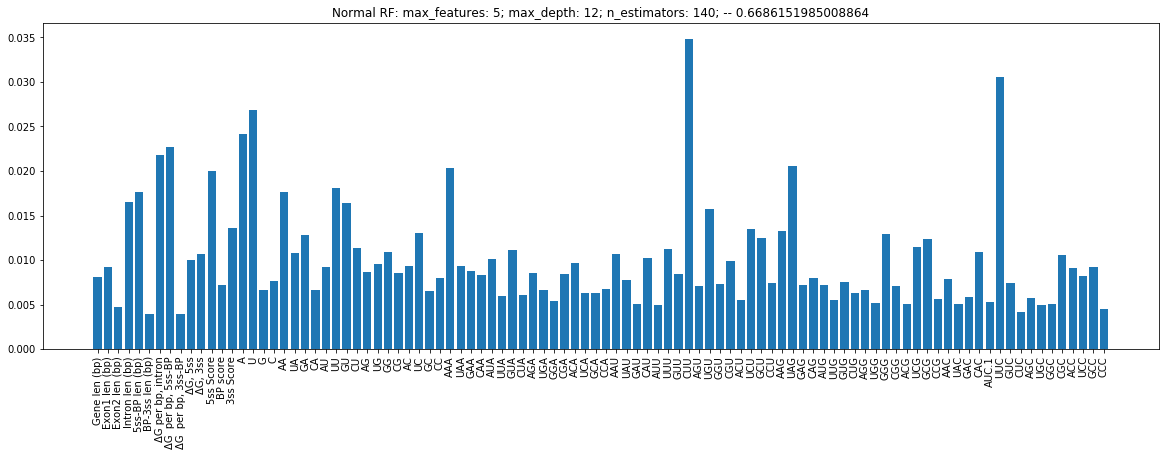

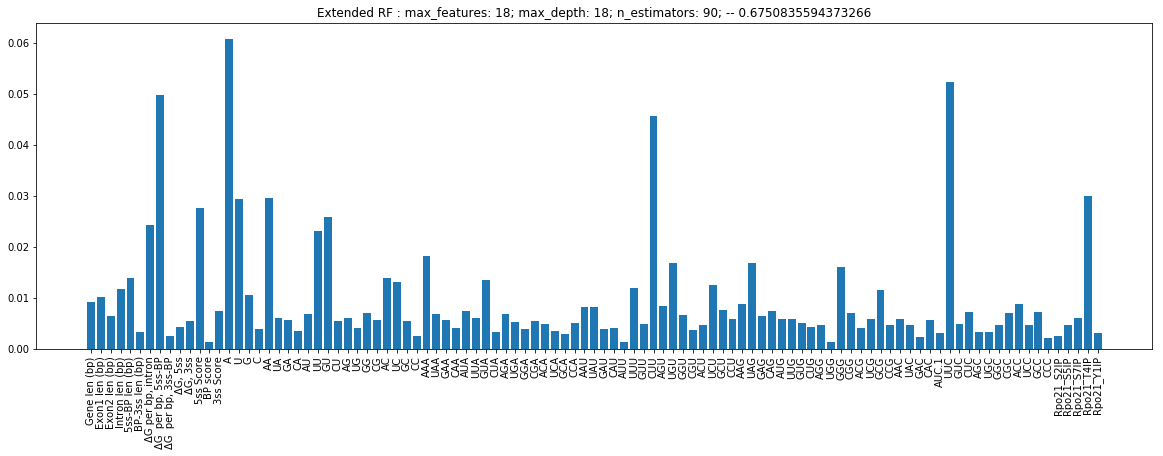

In [18]:
best_RFs(results_1_rp,results_2_rp,'rp')

Normal best: 0.683828520812472 | max_features: 80; max_depth: 12; n_estimators: 10;
Extended best: 0.6995253307038448 | max_features: 25; max_depth: 5; n_estimators: 10;
Best difference: 0.178522036722764 | max_features: 7; max_depth: 5; n_estimators: 20;
Normal feature space
Coefficient of determination R^2: 0.3526340326994295
Mean squared error:               0.03376319974358975
Mean absolute error:              0.13876153846153846
Root mean squared error:          0.18374765234851234
Correlation Coefficient:          0.5972822538667238


Extended feature space
Coefficient of determination R^2: 0.32708078033033505
Mean squared error:               0.03509592282051282
Mean absolute error:              0.14166068376068375
Root mean squared error:          0.18733905844887985
Correlation Coefficient:          0.5756356719726347

# Non-RP Genes

In [20]:
X,y,X2,y2 = get_data('nrp')

mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
md = [5,7,10,12,15,18,20]
n_est = [10,20,30,40,50,60,80,90,100,120,140,160]

results_1_nrp = np.zeros((len(mxf),len(md),len(n_est)))
results_2_nrp = np.zeros((len(mxf),len(md),len(n_est)))

f = FloatProgress(min=0, max=(len(mxf)*len(md)*len(n_est)))
display(f)


i = 0
for max_features in mxf:
    j = 0
    for max_depth in md:
        k = 0
        for n_estimators in n_est:            
            
            kf = KFold(n_splits=5,shuffle=True,random_state=0)

            rfr1 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X=X,y=y,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X=X2,y=y2,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print_stats(y, predictions_rfr1)
            print('\n')
            print('Extended feature space')
            print_stats(y2, predictions_rfr2)
            print('-------------------------------------------------------\n')
            

            results_1_nrp[i][j][k]=np.corrcoef(y, predictions_rfr1)[0][1]
            results_2_nrp[i][j][k]=np.corrcoef(y2, predictions_rfr2)[0][1]
            
            f.value += 1
            
            k += 1
        j += 1
    i += 1

FloatProgress(value=0.0, max=1008.0)

max_features: 5; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.1673302248928763
Mean squared error:               0.0682904775016769
Mean absolute error:              0.20986044191919193
Root mean squared error:          0.2613244678587845
Correlation Coefficient:          0.03098926649382055


Extended feature space
Coefficient of determination R^2: -0.022674628420537246
Mean squared error:               0.05982791948190794
Mean absolute error:              0.1950962416035143
Root mean squared error:          0.24459746417718223
Correlation Coefficient:          0.11850561029557957
-------------------------------------------------------

max_features: 5; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.024977752888470928
Mean squared error:               0.057040187438061656
Mean absolute error:              0.1946474464025032
Root mean squared error:          0.238830876224289
Correlation Coefficien

max_features: 5; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.06386205544972956
Mean squared error:               0.06223744251053263
Mean absolute error:              0.20597675685425682
Root mean squared error:          0.2494743323681469
Correlation Coefficient:          0.18705559527490045


Extended feature space
Coefficient of determination R^2: -0.18382740650730778
Mean squared error:               0.06925558607666031
Mean absolute error:              0.21916868686868687
Root mean squared error:          0.26316456082964573
Correlation Coefficient:          -0.027720721328391134
-------------------------------------------------------

max_features: 5; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.05094020328556914
Mean squared error:               0.05552134718453003
Mean absolute error:              0.19261350288600287
Root mean squared error:          0.23562968230791728
Correlation Coeff

max_features: 5; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.07326533105362154
Mean squared error:               0.0627875475
Mean absolute error:              0.20763030303030303
Root mean squared error:          0.25057443504874954
Correlation Coefficient:          0.15920767160541524


Extended feature space
Coefficient of determination R^2: -0.14905182415100837
Mean squared error:               0.06722116507575757
Mean absolute error:              0.21581969696969694
Root mean squared error:          0.2592704477485962
Correlation Coefficient:          -0.014683507687038595
-------------------------------------------------------

max_features: 5; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.05102526071107594
Mean squared error:               0.0555163712042298
Mean absolute error:              0.18847411616161613
Root mean squared error:          0.23561912317176167
Correlation Coefficient

max_features: 5; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.08171995726505377
Mean squared error:               0.06328215515151514
Mean absolute error:              0.2081333333333333
Root mean squared error:          0.2515594465559088
Correlation Coefficient:          0.1430168060997249


Extended feature space
Coefficient of determination R^2: -0.16418814762618372
Mean squared error:               0.06810666151515152
Mean absolute error:              0.2148090909090909
Root mean squared error:          0.260972530192646
Correlation Coefficient:          -0.044141584549573856
-------------------------------------------------------

max_features: 5; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.023155919605452935
Mean squared error:               0.057146767274831645
Mean absolute error:              0.19282449494949494
Root mean squared error:          0.239053900354777
Correlation Coeffici

max_features: 5; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.09207590350280404
Mean squared error:               0.06388799272727273
Mean absolute error:              0.20953939393939391
Root mean squared error:          0.2527607420610897
Correlation Coefficient:          0.13817619871599593


Extended feature space
Coefficient of determination R^2: -0.16418814762618372
Mean squared error:               0.06810666151515152
Mean absolute error:              0.2148090909090909
Root mean squared error:          0.260972530192646
Correlation Coefficient:          -0.044141584549573856
-------------------------------------------------------

max_features: 5; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.02388472348108983
Mean squared error:               0.057104131212121205
Mean absolute error:              0.1926363636363636
Root mean squared error:          0.23896470704294642
Correlation Coeffi

max_features: 5; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.09207590350280404
Mean squared error:               0.06388799272727273
Mean absolute error:              0.20953939393939391
Root mean squared error:          0.2527607420610897
Correlation Coefficient:          0.1381761987159959


Extended feature space
Coefficient of determination R^2: -0.16418814762618372
Mean squared error:               0.06810666151515152
Mean absolute error:              0.21480909090909092
Root mean squared error:          0.260972530192646
Correlation Coefficient:          -0.04414158454957398
-------------------------------------------------------

max_features: 5; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.02388472348108983
Mean squared error:               0.057104131212121205
Mean absolute error:              0.1926363636363636
Root mean squared error:          0.23896470704294642
Correlation Coeffic

max_features: 5; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.09207590350280404
Mean squared error:               0.06388799272727273
Mean absolute error:              0.20953939393939391
Root mean squared error:          0.2527607420610897
Correlation Coefficient:          0.13817619871599587


Extended feature space
Coefficient of determination R^2: -0.16418814762618372
Mean squared error:               0.06810666151515152
Mean absolute error:              0.2148090909090909
Root mean squared error:          0.260972530192646
Correlation Coefficient:          -0.04414158454957383
-------------------------------------------------------

max_features: 5; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.02388472348108972
Mean squared error:               0.05710413121212121
Mean absolute error:              0.1926363636363636
Root mean squared error:          0.23896470704294642
Correlation Coeffici

max_features: 7; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.08146396034816461
Mean squared error:               0.05373566400722592
Mean absolute error:              0.18514465229215227
Root mean squared error:          0.23180954252839964
Correlation Coefficient:          0.2937821495172713


Extended feature space
Coefficient of determination R^2: -0.26540172038938903
Mean squared error:               0.07402779939563797
Mean absolute error:              0.22377432242247747
Root mean squared error:          0.2720805016822006
Correlation Coefficient:          -0.1802816154306083
-------------------------------------------------------

max_features: 7; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.07264655536001352
Mean squared error:               0.05425149473286464
Mean absolute error:              0.18870446903265087
Root mean squared error:          0.23291950268894324
Correlation Coefficie

max_features: 7; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.045222508532012706
Mean squared error:               0.05585584045524528
Mean absolute error:              0.19159003673094582
Root mean squared error:          0.23633840241324575
Correlation Coefficient:          0.2939293085210957


Extended feature space
Coefficient of determination R^2: -0.37630139888978476
Mean squared error:               0.08051558823042933
Mean absolute error:              0.22930434146661421
Root mean squared error:          0.2837526884990331
Correlation Coefficient:          -0.2635035730987384
-------------------------------------------------------

max_features: 7; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.01281061048685983
Mean squared error:               0.057751982563998
Mean absolute error:              0.19334483378153833
Root mean squared error:          0.24031642175265094
Correlation Coefficien

max_features: 7; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.00021521975223803835
Mean squared error:               0.058514012149041436
Mean absolute error:              0.20491774891774892
Root mean squared error:          0.24189669726774163
Correlation Coefficient:          0.28505352529701733


Extended feature space
Coefficient of determination R^2: -0.361874730999449
Mean squared error:               0.07967160765151513
Mean absolute error:              0.22775303030303026
Root mean squared error:          0.2822615943615339
Correlation Coefficient:          -0.21206449368743197
-------------------------------------------------------

max_features: 7; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.007512235594101524
Mean squared error:               0.058061945026798595
Mean absolute error:              0.20065331890331892
Root mean squared error:          0.24096046361757897
Correlation 

max_features: 7; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.007593722028651606
Mean squared error:               0.05805717795454546
Mean absolute error:              0.20138636363636359
Root mean squared error:          0.2409505716003709
Correlation Coefficient:          0.3009393003577718


Extended feature space
Coefficient of determination R^2: -0.37418413792869587
Mean squared error:               0.08039172545454543
Mean absolute error:              0.22836363636363635
Root mean squared error:          0.2835343461638209
Correlation Coefficient:          -0.22236705445335342
-------------------------------------------------------

max_features: 7; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.03562339026420969
Mean squared error:               0.05641740251893938
Mean absolute error:              0.19751590909090908
Root mean squared error:          0.23752347782680217
Correlation Coeffi

max_features: 7; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.009294396839783836
Mean squared error:               0.057957686060606056
Mean absolute error:              0.20137575757575757
Root mean squared error:          0.24074402601228978
Correlation Coefficient:          0.29524514278150793


Extended feature space
Coefficient of determination R^2: -0.37418413792869587
Mean squared error:               0.08039172545454543
Mean absolute error:              0.22836363636363635
Root mean squared error:          0.2835343461638209
Correlation Coefficient:          -0.22236705445335345
-------------------------------------------------------

max_features: 7; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.024270598590620862
Mean squared error:               0.05708155696969696
Mean absolute error:              0.19838787878787878
Root mean squared error:          0.23891746895046614
Correlation Co

max_features: 7; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.009294396839783836
Mean squared error:               0.057957686060606056
Mean absolute error:              0.20137575757575757
Root mean squared error:          0.24074402601228978
Correlation Coefficient:          0.29524514278150793


Extended feature space
Coefficient of determination R^2: -0.37418413792869587
Mean squared error:               0.08039172545454543
Mean absolute error:              0.22836363636363635
Root mean squared error:          0.2835343461638209
Correlation Coefficient:          -0.22236705445335342
-------------------------------------------------------

max_features: 7; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.024270598590620862
Mean squared error:               0.05708155696969696
Mean absolute error:              0.19838787878787878
Root mean squared error:          0.23891746895046614
Correlation Co

max_features: 7; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.009294396839783836
Mean squared error:               0.057957686060606056
Mean absolute error:              0.20137575757575757
Root mean squared error:          0.24074402601228978
Correlation Coefficient:          0.29524514278150793


Extended feature space
Coefficient of determination R^2: -0.3741841379286961
Mean squared error:               0.08039172545454544
Mean absolute error:              0.22836363636363635
Root mean squared error:          0.28353434616382095
Correlation Coefficient:          -0.22236705445335342
-------------------------------------------------------

max_features: 7; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.024270598590620862
Mean squared error:               0.05708155696969696
Mean absolute error:              0.19838787878787878
Root mean squared error:          0.23891746895046614
Correlation Co

max_features: 10; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.01718361404868618
Mean squared error:               0.057496155639460804
Mean absolute error:              0.1966045203918888
Root mean squared error:          0.23978355998579387
Correlation Coefficient:          0.19369748257975164


Extended feature space
Coefficient of determination R^2: 0.02737731693074985
Mean squared error:               0.0568998095306378
Mean absolute error:              0.19154747420088328
Root mean squared error:          0.23853680959264506
Correlation Coefficient:          0.21395629325217497
-------------------------------------------------------

max_features: 10; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.03137732225582801
Mean squared error:               0.06033703944204385
Mean absolute error:              0.2056429793736522
Root mean squared error:          0.24563598971250905
Correlation Coeffic

max_features: 10; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.015625485812290285
Mean squared error:               0.05758730835614994
Mean absolute error:              0.19710502164502164
Root mean squared error:          0.2399735576186467
Correlation Coefficient:          0.20850413941414056


Extended feature space
Coefficient of determination R^2: -0.168290134649689
Mean squared error:               0.06834663358695026
Mean absolute error:              0.21431198412698416
Root mean squared error:          0.26143189091415425
Correlation Coefficient:          0.01139410317028202
-------------------------------------------------------

max_features: 10; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.07816230665713131
Mean squared error:               0.06307402753379543
Mean absolute error:              0.207270101010101
Root mean squared error:          0.25114543104304216
Correlation Coeffici

max_features: 10; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.04971779677728727
Mean squared error:               0.061409983272306394
Mean absolute error:              0.19365782828282826
Root mean squared error:          0.247810377652564
Correlation Coefficient:          0.15611529592364848


Extended feature space
Coefficient of determination R^2: -0.22270014911093594
Mean squared error:               0.07152969677609428
Mean absolute error:              0.22189747474747476
Root mean squared error:          0.2674503632005279
Correlation Coefficient:          -0.12316601345017195
-------------------------------------------------------

max_features: 10; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.09681364500071354
Mean squared error:               0.06416515733954123
Mean absolute error:              0.20674659090909087
Root mean squared error:          0.2533084233489704
Correlation Coe

max_features: 10; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.028508118942837557
Mean squared error:               0.06016918696969696
Mean absolute error:              0.18978484848484847
Root mean squared error:          0.24529408262266938
Correlation Coefficient:          0.19152671643917224


Extended feature space
Coefficient of determination R^2: -0.19286064438828832
Mean squared error:               0.06978404333333334
Mean absolute error:              0.21862727272727273
Root mean squared error:          0.26416669610935695
Correlation Coefficient:          -0.0826404241260586
-------------------------------------------------------

max_features: 10; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.08494868971133229
Mean squared error:               0.06347104058922558
Mean absolute error:              0.20626161616161615
Root mean squared error:          0.25193459585619754
Correlation 

max_features: 10; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.0388802937424797
Mean squared error:               0.06077597393939393
Mean absolute error:              0.19087272727272725
Root mean squared error:          0.2465278360335683
Correlation Coefficient:          0.18164810926170294


Extended feature space
Coefficient of determination R^2: -0.1905001889243254
Mean squared error:               0.06964595333333333
Mean absolute error:              0.21693939393939393
Root mean squared error:          0.2639051976247026
Correlation Coefficient:          -0.07090063656118904
-------------------------------------------------------

max_features: 10; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.0915532718095522
Mean squared error:               0.06385741803030302
Mean absolute error:              0.20680606060606058
Root mean squared error:          0.2527002533245723
Correlation Coeffi

max_features: 10; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.0388802937424797
Mean squared error:               0.06077597393939393
Mean absolute error:              0.19087272727272725
Root mean squared error:          0.2465278360335683
Correlation Coefficient:          0.181648109261703


Extended feature space
Coefficient of determination R^2: -0.19050018892432563
Mean squared error:               0.06964595333333334
Mean absolute error:              0.21693939393939393
Root mean squared error:          0.2639051976247026
Correlation Coefficient:          -0.07090063656118924
-------------------------------------------------------

max_features: 10; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.0915532718095522
Mean squared error:               0.06385741803030302
Mean absolute error:              0.20680606060606058
Root mean squared error:          0.2527002533245723
Correlation Coeffic

max_features: 10; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.0388802937424797
Mean squared error:               0.06077597393939393
Mean absolute error:              0.19087272727272725
Root mean squared error:          0.2465278360335683
Correlation Coefficient:          0.18164810926170288


Extended feature space
Coefficient of determination R^2: -0.1905001889243254
Mean squared error:               0.06964595333333333
Mean absolute error:              0.21693939393939393
Root mean squared error:          0.2639051976247026
Correlation Coefficient:          -0.0709006365611889
-------------------------------------------------------

max_features: 10; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.0915532718095522
Mean squared error:               0.06385741803030302
Mean absolute error:              0.20680606060606058
Root mean squared error:          0.2527002533245723
Correlation Coeffic

max_features: 12; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.10098935858689062
Mean squared error:               0.06440944252005769
Mean absolute error:              0.2066775095299828
Root mean squared error:          0.2537901544978798
Correlation Coefficient:          0.09897499836876168


Extended feature space
Coefficient of determination R^2: -0.1278980862036594
Mean squared error:               0.0659836413360614
Mean absolute error:              0.21163536736411734
Root mean squared error:          0.25687281159371733
Correlation Coefficient:          -0.051246657216437196
-------------------------------------------------------

max_features: 12; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.13935550999948343
Mean squared error:               0.066653916914703
Mean absolute error:              0.20835167041700128
Root mean squared error:          0.2581741987780789
Correlation Coeffici

max_features: 12; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.16654452474060788
Mean squared error:               0.06824451292590618
Mean absolute error:              0.21939515129651493
Root mean squared error:          0.261236507643756
Correlation Coefficient:          -0.0117219745871451


Extended feature space
Coefficient of determination R^2: -0.1329274691808633
Mean squared error:               0.06627786738943338
Mean absolute error:              0.2131387193362193
Root mean squared error:          0.25744488223585527
Correlation Coefficient:          0.01671952718365928
-------------------------------------------------------

max_features: 12; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.11886726471178255
Mean squared error:               0.0654553254415858
Mean absolute error:              0.2087424878656697
Root mean squared error:          0.25584238398198567
Correlation Coefficie

max_features: 12; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.1401109940440073
Mean squared error:               0.06669811380521885
Mean absolute error:              0.21542555555555554
Root mean squared error:          0.2582597796894028
Correlation Coefficient:          0.03940538567162188


Extended feature space
Coefficient of determination R^2: -0.26107765682425366
Mean squared error:               0.07377483553047481
Mean absolute error:              0.22619033189033189
Root mean squared error:          0.27161523434902324
Correlation Coefficient:          -0.15373462969595758
-------------------------------------------------------

max_features: 12; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.12840234112338478
Mean squared error:               0.06601314096565745
Mean absolute error:              0.20650985569985575
Root mean squared error:          0.2569302258700939
Correlation Coe

max_features: 12; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.1397187719909423
Mean squared error:               0.06667516825757575
Mean absolute error:              0.21454696969696974
Root mean squared error:          0.2582153524823335
Correlation Coefficient:          0.03422020254741173


Extended feature space
Coefficient of determination R^2: -0.2656850351544282
Mean squared error:               0.0740443737121212
Mean absolute error:              0.22414999999999996
Root mean squared error:          0.2721109584565113
Correlation Coefficient:          -0.15989751899329896
-------------------------------------------------------

max_features: 12; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.12579545614276277
Mean squared error:               0.06586063448863637
Mean absolute error:              0.20683712121212122
Root mean squared error:          0.2566332684759253
Correlation Coeffi

max_features: 12; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.16227500582030108
Mean squared error:               0.06799474000000001
Mean absolute error:              0.21606666666666668
Root mean squared error:          0.2607580104234576
Correlation Coefficient:          0.011752662649887332


Extended feature space
Coefficient of determination R^2: -0.2573346799135958
Mean squared error:               0.07355586606060605
Mean absolute error:              0.2239393939393939
Root mean squared error:          0.27121184719810093
Correlation Coefficient:          -0.15671570491322728
-------------------------------------------------------

max_features: 12; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.13538211875523198
Mean squared error:               0.06642146787878789
Mean absolute error:              0.20759696969696972
Root mean squared error:          0.25772362693161815
Correlation Co

max_features: 12; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.16227500582030108
Mean squared error:               0.06799474000000001
Mean absolute error:              0.21606666666666668
Root mean squared error:          0.2607580104234576
Correlation Coefficient:          0.011752662649887401


Extended feature space
Coefficient of determination R^2: -0.2573346799135958
Mean squared error:               0.07355586606060605
Mean absolute error:              0.2239393939393939
Root mean squared error:          0.27121184719810093
Correlation Coefficient:          -0.15671570491322737
-------------------------------------------------------

max_features: 12; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.13538211875523176
Mean squared error:               0.06642146787878787
Mean absolute error:              0.20759696969696972
Root mean squared error:          0.2577236269316181
Correlation Coe

max_features: 12; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.16227500582030108
Mean squared error:               0.06799474000000001
Mean absolute error:              0.21606666666666668
Root mean squared error:          0.2607580104234576
Correlation Coefficient:          0.011752662649887332


Extended feature space
Coefficient of determination R^2: -0.2573346799135958
Mean squared error:               0.07355586606060605
Mean absolute error:              0.2239393939393939
Root mean squared error:          0.27121184719810093
Correlation Coefficient:          -0.15671570491322734
-------------------------------------------------------

max_features: 12; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.1353821187552322
Mean squared error:               0.0664214678787879
Mean absolute error:              0.20759696969696972
Root mean squared error:          0.25772362693161815
Correlation Coef

max_features: 15; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.016828239591189065
Mean squared error:               0.05751694555038477
Mean absolute error:              0.20165095129617852
Root mean squared error:          0.23982690747784072
Correlation Coefficient:          0.2653021474622082


Extended feature space
Coefficient of determination R^2: -0.015226805535865084
Mean squared error:               0.05939221125616672
Mean absolute error:              0.20790966209295753
Root mean squared error:          0.24370517281372325
Correlation Coefficient:          0.1908330037310231
-------------------------------------------------------

max_features: 15; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.07687928355024576
Mean squared error:               0.0540038741169654
Mean absolute error:              0.1895012184781202
Root mean squared error:          0.2323873363954357
Correlation Coeffici

max_features: 15; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.10887179473638242
Mean squared error:               0.06487057623958824
Mean absolute error:              0.217031063011063
Root mean squared error:          0.25469702832893093
Correlation Coefficient:          0.16801560477001107


Extended feature space
Coefficient of determination R^2: 0.013613570737250447
Mean squared error:               0.057705008247952105
Mean absolute error:              0.20448699134199133
Root mean squared error:          0.24021866756759788
Correlation Coefficient:          0.24399576879205762
-------------------------------------------------------

max_features: 15; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.05279320029516388
Mean squared error:               0.05541294422545645
Mean absolute error:              0.18998016895141892
Root mean squared error:          0.23539954168489038
Correlation Coeff

max_features: 15; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.12385235114512771
Mean squared error:               0.06574696008417506
Mean absolute error:              0.21867777777777775
Root mean squared error:          0.25641170036520383
Correlation Coefficient:          0.12639622995548228


Extended feature space
Coefficient of determination R^2: -0.025846537973535755
Mean squared error:               0.060013480699588465
Mean absolute error:              0.20526902356902357
Root mean squared error:          0.24497649009565892
Correlation Coefficient:          0.1779038369453333
-------------------------------------------------------

max_features: 15; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.06128711211193205
Mean squared error:               0.05491603831018516
Mean absolute error:              0.18784823232323225
Root mean squared error:          0.23434171269790013
Correlation C

max_features: 15; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.13886228801108458
Mean squared error:               0.06662506272727271
Mean absolute error:              0.21936060606060606
Root mean squared error:          0.25811831149159625
Correlation Coefficient:          0.10244379142886388


Extended feature space
Coefficient of determination R^2: 0.007034907583418737
Mean squared error:               0.05808986939393938
Mean absolute error:              0.20425757575757575
Root mean squared error:          0.2410184005297923
Correlation Coefficient:          0.23584924532496115
-------------------------------------------------------

max_features: 15; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.04303760436985915
Mean squared error:               0.055983660454545454
Mean absolute error:              0.1910969696969697
Root mean squared error:          0.23660866521441148
Correlation Coe

max_features: 15; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.13886228801108436
Mean squared error:               0.0666250627272727
Mean absolute error:              0.219360606060606
Root mean squared error:          0.25811831149159625
Correlation Coefficient:          0.10244379142886402


Extended feature space
Coefficient of determination R^2: 0.007034907583418737
Mean squared error:               0.05808986939393938
Mean absolute error:              0.20425757575757575
Root mean squared error:          0.2410184005297923
Correlation Coefficient:          0.23584924532496115
-------------------------------------------------------

max_features: 15; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.04303760436985937
Mean squared error:               0.05598366045454544
Mean absolute error:              0.19109696969696968
Root mean squared error:          0.23660866521441146
Correlation Coeffi

max_features: 15; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.13886228801108458
Mean squared error:               0.06662506272727271
Mean absolute error:              0.219360606060606
Root mean squared error:          0.25811831149159625
Correlation Coefficient:          0.10244379142886398


Extended feature space
Coefficient of determination R^2: 0.007034907583418848
Mean squared error:               0.058089869393939376
Mean absolute error:              0.20425757575757575
Root mean squared error:          0.2410184005297923
Correlation Coefficient:          0.2358492453249612
-------------------------------------------------------

max_features: 15; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.04303760436985937
Mean squared error:               0.05598366045454544
Mean absolute error:              0.19109696969696968
Root mean squared error:          0.23660866521441146
Correlation Coeff

max_features: 15; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.13886228801108458
Mean squared error:               0.06662506272727271
Mean absolute error:              0.219360606060606
Root mean squared error:          0.25811831149159625
Correlation Coefficient:          0.10244379142886398


Extended feature space
Coefficient of determination R^2: 0.007034907583418626
Mean squared error:               0.05808986939393939
Mean absolute error:              0.20425757575757575
Root mean squared error:          0.24101840052979231
Correlation Coefficient:          0.23584924532496102
-------------------------------------------------------

max_features: 15; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.04303760436985937
Mean squared error:               0.05598366045454544
Mean absolute error:              0.19109696969696965
Root mean squared error:          0.23660866521441146
Correlation Coef

max_features: 18; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.05526830648040626
Mean squared error:               0.061734695979919575
Mean absolute error:              0.2138611026851936
Root mean squared error:          0.2484646775296633
Correlation Coefficient:          0.1280841615596006


Extended feature space
Coefficient of determination R^2: 0.13743324753868125
Mean squared error:               0.05046138114693279
Mean absolute error:              0.17740661375661373
Root mean squared error:          0.2246361082883444
Correlation Coefficient:          0.3857487359394915
-------------------------------------------------------

max_features: 18; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.03239214294664006
Mean squared error:               0.056606435080195215
Mean absolute error:              0.20148774672297395
Root mean squared error:          0.23792106901280352
Correlation Coeffici

max_features: 18; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.06062815377436026
Mean squared error:               0.06204825466557238
Mean absolute error:              0.21303005050505047
Root mean squared error:          0.2490948708134561
Correlation Coefficient:          0.13364886035637355


Extended feature space
Coefficient of determination R^2: 0.10030665724749444
Mean squared error:               0.05263333945395507
Mean absolute error:              0.18852436988936988
Root mean squared error:          0.2294195707736266
Correlation Coefficient:          0.3251271982413239
-------------------------------------------------------

max_features: 18; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.0010995547782882698
Mean squared error:               0.05843709597006995
Mean absolute error:              0.20411462481962478
Root mean squared error:          0.24173765939561412
Correlation Coeffi

max_features: 18; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.02043839178685858
Mean squared error:               0.057305746515151516
Mean absolute error:              0.19556666666666667
Root mean squared error:          0.23938618697650774
Correlation Coefficient:          0.2434429691675793


Extended feature space
Coefficient of determination R^2: 0.09469111995735091
Mean squared error:               0.05296185636784511
Mean absolute error:              0.18553434343434344
Root mean squared error:          0.23013443107854398
Correlation Coefficient:          0.31727583937733045
-------------------------------------------------------

max_features: 18; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.061361288235514566
Mean squared error:               0.05491169890151515
Mean absolute error:              0.1937939393939394
Root mean squared error:          0.23433245379484924
Correlation Coef

max_features: 18; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.017475689884581036
Mean squared error:               0.05747906878787878
Mean absolute error:              0.19448181818181817
Root mean squared error:          0.2397479275987152
Correlation Coefficient:          0.2430816957323357


Extended feature space
Coefficient of determination R^2: 0.10890867018088513
Mean squared error:               0.05213010946969697
Mean absolute error:              0.18328636363636364
Root mean squared error:          0.22832019067462467
Correlation Coefficient:          0.33579991361181505
-------------------------------------------------------

max_features: 18; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.0604364952446822
Mean squared error:               0.054965800606060614
Mean absolute error:              0.193530303030303
Root mean squared error:          0.23444786330026685
Correlation Coeffic

max_features: 18; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.017475689884581036
Mean squared error:               0.05747906878787878
Mean absolute error:              0.19448181818181814
Root mean squared error:          0.2397479275987152
Correlation Coefficient:          0.24308169573233573


Extended feature space
Coefficient of determination R^2: 0.10890304094704018
Mean squared error:               0.052130438787878784
Mean absolute error:              0.18329090909090912
Root mean squared error:          0.22832091184970066
Correlation Coefficient:          0.33579611481608407
-------------------------------------------------------

max_features: 18; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.06043649524468231
Mean squared error:               0.05496580060606061
Mean absolute error:              0.19353030303030302
Root mean squared error:          0.23444786330026685
Correlation Coe

max_features: 18; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.017475689884581036
Mean squared error:               0.05747906878787878
Mean absolute error:              0.19448181818181817
Root mean squared error:          0.2397479275987152
Correlation Coefficient:          0.2430816957323358


Extended feature space
Coefficient of determination R^2: 0.10890304094704018
Mean squared error:               0.052130438787878784
Mean absolute error:              0.18329090909090912
Root mean squared error:          0.22832091184970066
Correlation Coefficient:          0.33579611481608407
-------------------------------------------------------

max_features: 18; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.0604364952446822
Mean squared error:               0.054965800606060614
Mean absolute error:              0.19353030303030302
Root mean squared error:          0.23444786330026685
Correlation Coef

max_features: 18; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.017475689884581036
Mean squared error:               0.05747906878787878
Mean absolute error:              0.19448181818181817
Root mean squared error:          0.2397479275987152
Correlation Coefficient:          0.2430816957323357


Extended feature space
Coefficient of determination R^2: 0.10890304094704018
Mean squared error:               0.052130438787878784
Mean absolute error:              0.18329090909090912
Root mean squared error:          0.22832091184970066
Correlation Coefficient:          0.33579611481608407
-------------------------------------------------------

max_features: 18; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.0604364952446822
Mean squared error:               0.054965800606060614
Mean absolute error:              0.19353030303030302
Root mean squared error:          0.23444786330026685
Correlation Coef

max_features: 20; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.11572011404073157
Mean squared error:               0.06527121265369365
Mean absolute error:              0.2026318795093795
Root mean squared error:          0.2554823137786521
Correlation Coefficient:          0.09631342023713296


Extended feature space
Coefficient of determination R^2: -0.08092568145920098
Mean squared error:               0.06323568888781954
Mean absolute error:              0.2094497098356189
Root mean squared error:          0.25146707316827693
Correlation Coefficient:          0.09214073126122552
-------------------------------------------------------

max_features: 20; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.06851105022644943
Mean squared error:               0.06250941531345917
Mean absolute error:              0.20192558621302942
Root mean squared error:          0.25001882991778673
Correlation Coeffi

max_features: 20; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.23576219848827473
Mean squared error:               0.07229384523220986
Mean absolute error:              0.21487343434343434
Root mean squared error:          0.2688751480375415
Correlation Coefficient:          0.03073611458061424


Extended feature space
Coefficient of determination R^2: -0.036667213504628204
Mean squared error:               0.06064650559961349
Mean absolute error:              0.20381051226551225
Root mean squared error:          0.2462651124288893
Correlation Coefficient:          0.1518279935697174
-------------------------------------------------------

max_features: 20; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.16743772119456501
Mean squared error:               0.06829676618813035
Mean absolute error:              0.21512240440115438
Root mean squared error:          0.26133649991558844
Correlation Coeff

max_features: 20; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.2360605286159252
Mean squared error:               0.07231129796874998
Mean absolute error:              0.21296325757575757
Root mean squared error:          0.2689076011732468
Correlation Coefficient:          0.06255555552787012


Extended feature space
Coefficient of determination R^2: -0.06434706161457004
Mean squared error:               0.06226581606060604
Mean absolute error:              0.2143121212121212
Root mean squared error:          0.2495311925603812
Correlation Coefficient:          0.1482361652505481
-------------------------------------------------------

max_features: 20; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.15892288097560625
Mean squared error:               0.06779863593158145
Mean absolute error:              0.2136032196969697
Root mean squared error:          0.26038171197605536
Correlation Coeffic

max_features: 20; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.23634504576250692
Mean squared error:               0.07232794262626262
Mean absolute error:              0.21288484848484845
Root mean squared error:          0.26893854804817885
Correlation Coefficient:          0.06297321152395337


Extended feature space
Coefficient of determination R^2: -0.03657058037628125
Mean squared error:               0.06064085242424241
Mean absolute error:              0.20950606060606058
Root mean squared error:          0.24625363433712488
Correlation Coefficient:          0.16852461904161187
-------------------------------------------------------

max_features: 20; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.15740855927652997
Mean squared error:               0.06771004595959597
Mean absolute error:              0.2144
Root mean squared error:          0.260211540788636
Correlation Coefficient:    

max_features: 20; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.23601332283795595
Mean squared error:               0.07230853636363635
Mean absolute error:              0.21288484848484845
Root mean squared error:          0.26890246626544045
Correlation Coefficient:          0.0636832855109069


Extended feature space
Coefficient of determination R^2: -0.03657058037628125
Mean squared error:               0.06064085242424241
Mean absolute error:              0.20950606060606058
Root mean squared error:          0.24625363433712488
Correlation Coefficient:          0.16852461904161187
-------------------------------------------------------

max_features: 20; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.15717924256602567
Mean squared error:               0.06769663060606061
Mean absolute error:              0.21439999999999998
Root mean squared error:          0.2601857617281557
Correlation Coe

max_features: 20; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.23601332283795595
Mean squared error:               0.07230853636363635
Mean absolute error:              0.21288484848484845
Root mean squared error:          0.26890246626544045
Correlation Coefficient:          0.0636832855109069


Extended feature space
Coefficient of determination R^2: -0.03657058037628125
Mean squared error:               0.06064085242424241
Mean absolute error:              0.20950606060606058
Root mean squared error:          0.24625363433712488
Correlation Coefficient:          0.16852461904161187
-------------------------------------------------------

max_features: 20; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.15717924256602567
Mean squared error:               0.06769663060606061
Mean absolute error:              0.2144
Root mean squared error:          0.2601857617281557
Correlation Coefficient:    

max_features: 20; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.23601332283795595
Mean squared error:               0.07230853636363635
Mean absolute error:              0.21288484848484845
Root mean squared error:          0.26890246626544045
Correlation Coefficient:          0.0636832855109069


Extended feature space
Coefficient of determination R^2: -0.03657058037628125
Mean squared error:               0.06064085242424241
Mean absolute error:              0.20950606060606058
Root mean squared error:          0.24625363433712488
Correlation Coefficient:          0.16852461904161187
-------------------------------------------------------

max_features: 20; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.15717924256602567
Mean squared error:               0.06769663060606061
Mean absolute error:              0.21439999999999998
Root mean squared error:          0.2601857617281557
Correlation Coe

max_features: 25; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.022805336002514442
Mean squared error:               0.05716727691395379
Mean absolute error:              0.18778772224408588
Root mean squared error:          0.239096794026925
Correlation Coefficient:          0.24154891704945833


Extended feature space
Coefficient of determination R^2: -0.04276885660793406
Mean squared error:               0.061003460394566916
Mean absolute error:              0.20177894318644315
Root mean squared error:          0.24698878596925594
Correlation Coefficient:          0.08122667499362905
-------------------------------------------------------

max_features: 25; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.015560442607370994
Mean squared error:               0.05941172949911077
Mean absolute error:              0.19171355604202195
Root mean squared error:          0.24374521431017013
Correlation Coe

max_features: 25; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.04041211068767314
Mean squared error:               0.056137255567060056
Mean absolute error:              0.18398140692640694
Root mean squared error:          0.23693301915744047
Correlation Coefficient:          0.2533447058602535


Extended feature space
Coefficient of determination R^2: -0.07428895652874501
Mean squared error:               0.06284743104536565
Mean absolute error:              0.20966112914862914
Root mean squared error:          0.2506938990988126
Correlation Coefficient:          0.0964895180731618
-------------------------------------------------------

max_features: 25; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.01561843257273976
Mean squared error:               0.05941512199451686
Mean absolute error:              0.19841481564731564
Root mean squared error:          0.24375217331239707
Correlation Coeffi

max_features: 25; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.002663869903846372
Mean squared error:               0.05865726166363636
Mean absolute error:              0.19954636363636366
Root mean squared error:          0.24219261273547624
Correlation Coefficient:          0.2176336973604881


Extended feature space
Coefficient of determination R^2: -0.053424731832939054
Mean squared error:               0.06162684424242424
Mean absolute error:              0.19850909090909089
Root mean squared error:          0.24824754629688536
Correlation Coefficient:          0.10979484918575615
-------------------------------------------------------

max_features: 25; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.02859010918055449
Mean squared error:               0.06017398351515151
Mean absolute error:              0.20309151515151516
Root mean squared error:          0.2453038595602432
Correlation C

max_features: 25; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.0020114253068939103
Mean squared error:               0.058619092727272726
Mean absolute error:              0.19963636363636364
Root mean squared error:          0.24211380119124298
Correlation Coefficient:          0.2182378359203577


Extended feature space
Coefficient of determination R^2: -0.05917680651587398
Mean squared error:               0.0619633487878788
Mean absolute error:              0.20109393939393935
Root mean squared error:          0.24892438367479952
Correlation Coefficient:          0.10862492136565723
-------------------------------------------------------

max_features: 25; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.03520036373583446
Mean squared error:               0.0605606928030303
Mean absolute error:              0.2038772727272727
Root mean squared error:          0.2460908222649319
Correlation Coe

max_features: 25; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.0032041235983246708
Mean squared error:               0.05868886727272727
Mean absolute error:              0.20013333333333333
Root mean squared error:          0.24225785286080465
Correlation Coefficient:          0.21721927260749305


Extended feature space
Coefficient of determination R^2: -0.05917680651587398
Mean squared error:               0.0619633487878788
Mean absolute error:              0.20109393939393935
Root mean squared error:          0.24892438367479952
Correlation Coefficient:          0.1086249213656573
-------------------------------------------------------

max_features: 25; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.03606737582039887
Mean squared error:               0.06061141424242424
Mean absolute error:              0.20408787878787876
Root mean squared error:          0.24619385500540877
Correlation C

max_features: 25; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.0032041235983246708
Mean squared error:               0.05868886727272727
Mean absolute error:              0.20013333333333333
Root mean squared error:          0.24225785286080465
Correlation Coefficient:          0.21721927260749302


Extended feature space
Coefficient of determination R^2: -0.05917680651587398
Mean squared error:               0.0619633487878788
Mean absolute error:              0.20109393939393935
Root mean squared error:          0.24892438367479952
Correlation Coefficient:          0.10862492136565721
-------------------------------------------------------

max_features: 25; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.03606737582039865
Mean squared error:               0.06061141424242423
Mean absolute error:              0.20408787878787876
Root mean squared error:          0.24619385500540875
Correlation 

max_features: 25; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.0032041235983246708
Mean squared error:               0.05868886727272727
Mean absolute error:              0.20013333333333333
Root mean squared error:          0.24225785286080465
Correlation Coefficient:          0.21721927260749302


Extended feature space
Coefficient of determination R^2: -0.05917680651587398
Mean squared error:               0.0619633487878788
Mean absolute error:              0.20109393939393935
Root mean squared error:          0.24892438367479952
Correlation Coefficient:          0.10862492136565724
-------------------------------------------------------

max_features: 25; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.03606737582039887
Mean squared error:               0.06061141424242424
Mean absolute error:              0.20408787878787876
Root mean squared error:          0.24619385500540877
Correlation 

max_features: 30; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.09999498067469803
Mean squared error:               0.06435126999869856
Mean absolute error:              0.21025899525558617
Root mean squared error:          0.25367552108687696
Correlation Coefficient:          0.11387222695631985


Extended feature space
Coefficient of determination R^2: -0.07200801560092551
Mean squared error:               0.06271399275875897
Mean absolute error:              0.20914271340859572
Root mean squared error:          0.250427619800131
Correlation Coefficient:          0.08904608968097508
-------------------------------------------------------

max_features: 30; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.08084407557688489
Mean squared error:               0.053771928147504304
Mean absolute error:              0.1933671488423193
Root mean squared error:          0.23188774902418693
Correlation Coeffi

max_features: 30; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.15924249605453467
Mean squared error:               0.06781733386802763
Mean absolute error:              0.20562548701298702
Root mean squared error:          0.26041761435822197
Correlation Coefficient:          0.0540868021244456


Extended feature space
Coefficient of determination R^2: -0.24058453539856628
Mean squared error:               0.07257595879635405
Mean absolute error:              0.2327358672155731
Root mean squared error:          0.26939925537453524
Correlation Coefficient:          -0.07422384961382049
-------------------------------------------------------

max_features: 30; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.09677106993282925
Mean squared error:               0.05284017633765652
Mean absolute error:              0.1864804696313787
Root mean squared error:          0.22986991177110702
Correlation Coeffi

max_features: 30; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.10501944938730512
Mean squared error:               0.06464520856060606
Mean absolute error:              0.20516212121212124
Root mean squared error:          0.25425422033981276
Correlation Coefficient:          0.09079244873522267


Extended feature space
Coefficient of determination R^2: -0.24648717179800683
Mean squared error:               0.07292127141624578
Mean absolute error:              0.23006641414141413
Root mean squared error:          0.2700393886384832
Correlation Coefficient:          -0.0826539347064931
-------------------------------------------------------

max_features: 30; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.08709609583902178
Mean squared error:               0.05340617607499999
Mean absolute error:              0.19177530303030302
Root mean squared error:          0.23109776302465584
Correlation Coe

max_features: 30; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.1019658626175457
Mean squared error:               0.0644665693939394
Mean absolute error:              0.20423939393939394
Root mean squared error:          0.25390267701215635
Correlation Coefficient:          0.09316477669204547


Extended feature space
Coefficient of determination R^2: -0.24823657542450528
Mean squared error:               0.0730236140151515
Mean absolute error:              0.23015
Root mean squared error:          0.27022881788430986
Correlation Coefficient:          -0.07232365909274262
-------------------------------------------------------

max_features: 30; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.08434501135358918
Mean squared error:               0.053567118428030296
Mean absolute error:              0.19161439393939395
Root mean squared error:          0.23144571378193698
Correlation Coefficient:   

max_features: 30; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.10661494933889704
Mean squared error:               0.06473854757575759
Mean absolute error:              0.20465757575757576
Root mean squared error:          0.2544377086356454
Correlation Coefficient:          0.09043366733000505


Extended feature space
Coefficient of determination R^2: -0.24190040589534312
Mean squared error:               0.07265293909090909
Mean absolute error:              0.22963939393939392
Root mean squared error:          0.2695420915013258
Correlation Coefficient:          -0.0673007591330352
-------------------------------------------------------

max_features: 30; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.08193235209466798
Mean squared error:               0.05370826242424241
Mean absolute error:              0.19243030303030303
Root mean squared error:          0.23175043133561243
Correlation Coef

max_features: 30; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.10661494933889704
Mean squared error:               0.06473854757575759
Mean absolute error:              0.20465757575757576
Root mean squared error:          0.2544377086356454
Correlation Coefficient:          0.09043366733000505


Extended feature space
Coefficient of determination R^2: -0.24190040589534312
Mean squared error:               0.07265293909090909
Mean absolute error:              0.22963939393939392
Root mean squared error:          0.2695420915013258
Correlation Coefficient:          -0.06730075913303521
-------------------------------------------------------

max_features: 30; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.08193235209466798
Mean squared error:               0.05370826242424241
Mean absolute error:              0.19243030303030303
Root mean squared error:          0.23175043133561243
Correlation Coe

max_features: 30; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.10661494933889704
Mean squared error:               0.06473854757575759
Mean absolute error:              0.20465757575757576
Root mean squared error:          0.2544377086356454
Correlation Coefficient:          0.09043366733000507


Extended feature space
Coefficient of determination R^2: -0.24190040589534312
Mean squared error:               0.07265293909090909
Mean absolute error:              0.22963939393939392
Root mean squared error:          0.2695420915013258
Correlation Coefficient:          -0.0673007591330352
-------------------------------------------------------

max_features: 30; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.08193235209466798
Mean squared error:               0.05370826242424241
Mean absolute error:              0.19243030303030303
Root mean squared error:          0.23175043133561243
Correlation Coef

max_features: 50; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.01480475770089884
Mean squared error:               0.057635322117321176
Mean absolute error:              0.19963051456119638
Root mean squared error:          0.24007357646630162
Correlation Coefficient:          0.22948352052898377


Extended feature space
Coefficient of determination R^2: -0.1407662742727167
Mean squared error:               0.06673644863007107
Mean absolute error:              0.20274124896147624
Root mean squared error:          0.2583339865950105
Correlation Coefficient:          0.07844654180834922
-------------------------------------------------------

max_features: 50; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.010442411999969425
Mean squared error:               0.057890525541845886
Mean absolute error:              0.19779660089489634
Root mean squared error:          0.2406045002526883
Correlation Coeff

max_features: 50; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.024613710127321387
Mean squared error:               0.059941358518135424
Mean absolute error:              0.2012647546897547
Root mean squared error:          0.24482924359262195
Correlation Coefficient:          0.18506940585033432


Extended feature space
Coefficient of determination R^2: -0.10979559354953894
Mean squared error:               0.06492461978332646
Mean absolute error:              0.2066004329004329
Root mean squared error:          0.2548031000269158
Correlation Coefficient:          0.09040369429792332
-------------------------------------------------------

max_features: 50; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.05037067445616672
Mean squared error:               0.05555466543062824
Mean absolute error:              0.18948574915824917
Root mean squared error:          0.23570037214783568
Correlation Coeff

max_features: 50; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.005762066199234472
Mean squared error:               0.05816433242424241
Mean absolute error:              0.19956666666666667
Root mean squared error:          0.2411728268778272
Correlation Coefficient:          0.2142396992236054


Extended feature space
Coefficient of determination R^2: -0.10477391792792035
Mean squared error:               0.06463084462121212
Mean absolute error:              0.20684393939393936
Root mean squared error:          0.25422597157098664
Correlation Coefficient:          0.10404863118834877
-------------------------------------------------------

max_features: 50; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.037100668535237524
Mean squared error:               0.05633097964015151
Mean absolute error:              0.19367045454545453
Root mean squared error:          0.2373414831843593
Correlation Coef

max_features: 50; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.005762066199234472
Mean squared error:               0.05816433242424241
Mean absolute error:              0.19956666666666667
Root mean squared error:          0.2411728268778272
Correlation Coefficient:          0.2142396992236054


Extended feature space
Coefficient of determination R^2: -0.10394838372696658
Mean squared error:               0.0645825496969697
Mean absolute error:              0.2066242424242424
Root mean squared error:          0.25413096957468545
Correlation Coefficient:          0.10558574872025993
-------------------------------------------------------

max_features: 50; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.04159953746149936
Mean squared error:               0.05606778941287879
Mean absolute error:              0.1938022727272727
Root mean squared error:          0.23678637928073226
Correlation Coeffic

max_features: 50; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.005762066199234361
Mean squared error:               0.05816433242424242
Mean absolute error:              0.19956666666666667
Root mean squared error:          0.2411728268778272
Correlation Coefficient:          0.21423969922360528


Extended feature space
Coefficient of determination R^2: -0.10394838372696658
Mean squared error:               0.0645825496969697
Mean absolute error:              0.2066242424242424
Root mean squared error:          0.25413096957468545
Correlation Coefficient:          0.10558574872025993
-------------------------------------------------------

max_features: 50; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.03833872217368839
Mean squared error:               0.05625855174242423
Mean absolute error:              0.19419545454545453
Root mean squared error:          0.23718885248346777
Correlation Coeff

max_features: 50; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.005762066199234472
Mean squared error:               0.05816433242424241
Mean absolute error:              0.19956666666666667
Root mean squared error:          0.2411728268778272
Correlation Coefficient:          0.2142396992236054


Extended feature space
Coefficient of determination R^2: -0.10394838372696658
Mean squared error:               0.0645825496969697
Mean absolute error:              0.2066242424242424
Root mean squared error:          0.25413096957468545
Correlation Coefficient:          0.10558574872025993
-------------------------------------------------------

max_features: 50; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.03833872217368839
Mean squared error:               0.05625855174242423
Mean absolute error:              0.19419545454545453
Root mean squared error:          0.23718885248346777
Correlation Coeffi

max_features: 50; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.005762066199234472
Mean squared error:               0.05816433242424241
Mean absolute error:              0.19956666666666667
Root mean squared error:          0.2411728268778272
Correlation Coefficient:          0.2142396992236054


Extended feature space
Coefficient of determination R^2: -0.10394838372696658
Mean squared error:               0.0645825496969697
Mean absolute error:              0.2066242424242424
Root mean squared error:          0.25413096957468545
Correlation Coefficient:          0.10558574872025993
-------------------------------------------------------

max_features: 50; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.03833872217368839
Mean squared error:               0.05625855174242423
Mean absolute error:              0.19419545454545453
Root mean squared error:          0.23718885248346777
Correlation Coeffi

max_features: 80; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.029771211852877455
Mean squared error:               0.06024307970040521
Mean absolute error:              0.20487984848484844
Root mean squared error:          0.24544465710299176
Correlation Coefficient:          0.20695659681897774


Extended feature space
Coefficient of determination R^2: -0.11772793843398399
Mean squared error:               0.06538867323479641
Mean absolute error:              0.21789034992784992
Root mean squared error:          0.25571209051352345
Correlation Coefficient:          0.060220089705434146
-------------------------------------------------------

max_features: 80; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.057739080992901926
Mean squared error:               0.05512360317413068
Mean absolute error:              0.19604652761380034
Root mean squared error:          0.2347841629542561
Correlation Co

max_features: 80; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.05431883830072248
Mean squared error:               0.06167915074175083
Mean absolute error:              0.21130555555555555
Root mean squared error:          0.24835287544490164
Correlation Coefficient:          0.19078216863362804


Extended feature space
Coefficient of determination R^2: -0.12414264220641846
Mean squared error:               0.06576394252390572
Mean absolute error:              0.21185393939393934
Root mean squared error:          0.2564448137980289
Correlation Coefficient:          0.06031311492340836
-------------------------------------------------------

max_features: 80; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.03467367673616617
Mean squared error:               0.056472962110335936
Mean absolute error:              0.2041913888888889
Root mean squared error:          0.23764040504580852
Correlation Coeff

max_features: 80; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.12248793841556727
Mean squared error:               0.06566714
Mean absolute error:              0.21854545454545454
Root mean squared error:          0.2562560048076923
Correlation Coefficient:          0.13638265871985322


Extended feature space
Coefficient of determination R^2: -0.17375657091235963
Mean squared error:               0.06866642787878788
Mean absolute error:              0.2237212121212121
Root mean squared error:          0.26204279779987827
Correlation Coefficient:          0.0210164719791943
-------------------------------------------------------

max_features: 80; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.013282878983750801
Mean squared error:               0.057724354185606064
Mean absolute error:              0.20757954545454546
Root mean squared error:          0.24025893154179734
Correlation Coefficient:

max_features: 80; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.12248793841556727
Mean squared error:               0.06566714
Mean absolute error:              0.21854545454545454
Root mean squared error:          0.2562560048076923
Correlation Coefficient:          0.13638265871985325


Extended feature space
Coefficient of determination R^2: -0.17375657091235963
Mean squared error:               0.06866642787878788
Mean absolute error:              0.2237212121212121
Root mean squared error:          0.26204279779987827
Correlation Coefficient:          0.0210164719791943
-------------------------------------------------------

max_features: 80; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.007649605156635819
Mean squared error:               0.058053908712121204
Mean absolute error:              0.20796818181818183
Root mean squared error:          0.24094378745284387
Correlation Coefficient:

max_features: 80; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.12248793841556749
Mean squared error:               0.06566714000000001
Mean absolute error:              0.21854545454545454
Root mean squared error:          0.2562560048076923
Correlation Coefficient:          0.13638265871985322


Extended feature space
Coefficient of determination R^2: -0.17375657091235963
Mean squared error:               0.06866642787878788
Mean absolute error:              0.2237212121212121
Root mean squared error:          0.26204279779987827
Correlation Coefficient:          0.0210164719791943
-------------------------------------------------------

max_features: 80; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.007649605156635819
Mean squared error:               0.058053908712121204
Mean absolute error:              0.20796818181818183
Root mean squared error:          0.24094378745284387
Correlation Coe

max_features: 80; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.12248793841556727
Mean squared error:               0.06566714
Mean absolute error:              0.21854545454545454
Root mean squared error:          0.2562560048076923
Correlation Coefficient:          0.13638265871985322


Extended feature space
Coefficient of determination R^2: -0.17375657091235963
Mean squared error:               0.06866642787878788
Mean absolute error:              0.22372121212121213
Root mean squared error:          0.26204279779987827
Correlation Coefficient:          0.021016471979194283
-------------------------------------------------------

max_features: 80; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.007649605156635819
Mean squared error:               0.058053908712121204
Mean absolute error:              0.20796818181818183
Root mean squared error:          0.24094378745284387
Correlation Coefficie

max_features: 80; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.12248793841556727
Mean squared error:               0.06566714
Mean absolute error:              0.21854545454545454
Root mean squared error:          0.2562560048076923
Correlation Coefficient:          0.13638265871985322


Extended feature space
Coefficient of determination R^2: -0.17375657091235963
Mean squared error:               0.06866642787878788
Mean absolute error:              0.2237212121212121
Root mean squared error:          0.26204279779987827
Correlation Coefficient:          0.0210164719791943
-------------------------------------------------------

max_features: 80; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.007649605156635819
Mean squared error:               0.058053908712121204
Mean absolute error:              0.20796818181818183
Root mean squared error:          0.24094378745284387
Correlation Coefficient:

max_features: 10; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.01718361404868629
Mean squared error:               0.0574961556394608
Mean absolute error:              0.19660452039188878
Root mean squared error:          0.23978355998579384
Correlation Coefficient:          0.19369748257975172


Extended feature space
Coefficient of determination R^2: 0.02737731693074985
Mean squared error:               0.0568998095306378
Mean absolute error:              0.19154747420088328
Root mean squared error:          0.23853680959264506
Correlation Coefficient:          0.21395629325217497
-------------------------------------------------------

max_features: 10; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.03137732225582801
Mean squared error:               0.06033703944204385
Mean absolute error:              0.2056429793736522
Root mean squared error:          0.24563598971250905
Correlation Coeffici

max_features: 10; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.015625485812290396
Mean squared error:               0.05758730835614993
Mean absolute error:              0.19710502164502164
Root mean squared error:          0.23997355761864667
Correlation Coefficient:          0.20850413941414064


Extended feature space
Coefficient of determination R^2: -0.16829013464968923
Mean squared error:               0.06834663358695027
Mean absolute error:              0.21431198412698413
Root mean squared error:          0.2614318909141543
Correlation Coefficient:          0.011394103170281977
-------------------------------------------------------

max_features: 10; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.07816230665713131
Mean squared error:               0.06307402753379543
Mean absolute error:              0.20727010101010096
Root mean squared error:          0.25114543104304216
Correlation Coe

max_features: 10; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.04971779677728727
Mean squared error:               0.061409983272306394
Mean absolute error:              0.19365782828282826
Root mean squared error:          0.247810377652564
Correlation Coefficient:          0.15611529592364845


Extended feature space
Coefficient of determination R^2: -0.22270014911093572
Mean squared error:               0.07152969677609426
Mean absolute error:              0.22189747474747473
Root mean squared error:          0.26745036320052784
Correlation Coefficient:          -0.12316601345017182
-------------------------------------------------------

max_features: 10; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.09681364500071354
Mean squared error:               0.06416515733954123
Mean absolute error:              0.20674659090909087
Root mean squared error:          0.2533084233489704
Correlation Co

max_features: 10; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.028508118942837557
Mean squared error:               0.06016918696969696
Mean absolute error:              0.18978484848484847
Root mean squared error:          0.24529408262266938
Correlation Coefficient:          0.19152671643917224


Extended feature space
Coefficient of determination R^2: -0.19286064438828832
Mean squared error:               0.06978404333333334
Mean absolute error:              0.21862727272727273
Root mean squared error:          0.26416669610935695
Correlation Coefficient:          -0.08264042412605871
-------------------------------------------------------

max_features: 10; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.08494868971133229
Mean squared error:               0.06347104058922558
Mean absolute error:              0.20626161616161615
Root mean squared error:          0.25193459585619754
Correlation

max_features: 10; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.0388802937424797
Mean squared error:               0.06077597393939393
Mean absolute error:              0.19087272727272725
Root mean squared error:          0.2465278360335683
Correlation Coefficient:          0.1816481092617029


Extended feature space
Coefficient of determination R^2: -0.1905001889243254
Mean squared error:               0.06964595333333333
Mean absolute error:              0.21693939393939393
Root mean squared error:          0.2639051976247026
Correlation Coefficient:          -0.07090063656118914
-------------------------------------------------------

max_features: 10; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.0915532718095522
Mean squared error:               0.06385741803030302
Mean absolute error:              0.20680606060606058
Root mean squared error:          0.2527002533245723
Correlation Coeffic

max_features: 10; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.0388802937424797
Mean squared error:               0.06077597393939393
Mean absolute error:              0.19087272727272725
Root mean squared error:          0.2465278360335683
Correlation Coefficient:          0.18164810926170294


Extended feature space
Coefficient of determination R^2: -0.1905001889243254
Mean squared error:               0.06964595333333333
Mean absolute error:              0.21693939393939393
Root mean squared error:          0.2639051976247026
Correlation Coefficient:          -0.0709006365611891
-------------------------------------------------------

max_features: 10; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.0915532718095522
Mean squared error:               0.06385741803030302
Mean absolute error:              0.20680606060606058
Root mean squared error:          0.2527002533245723
Correlation Coeffic

max_features: 10; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.0388802937424797
Mean squared error:               0.06077597393939393
Mean absolute error:              0.19087272727272725
Root mean squared error:          0.2465278360335683
Correlation Coefficient:          0.18164810926170294


Extended feature space
Coefficient of determination R^2: -0.1905001889243254
Mean squared error:               0.06964595333333333
Mean absolute error:              0.21693939393939393
Root mean squared error:          0.2639051976247026
Correlation Coefficient:          -0.0709006365611891
-------------------------------------------------------

max_features: 10; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: -0.0915532718095522
Mean squared error:               0.06385741803030302
Mean absolute error:              0.20680606060606058
Root mean squared error:          0.2527002533245723
Correlation Coeffic

In [21]:
get_best_settings(results_1_nrp,results_2_nrp)

Normal best: 0.32295291283191135 | max_features: 80; max_depth: 5; n_estimators: 30;
Extended best: 0.3857487359394915 | max_features: 18; max_depth: 5; n_estimators: 10;
Best difference: 0.2576645743798909 | max_features: 18; max_depth: 5; n_estimators: 10;


(80, 5, 30, 18, 5, 10)

Normal best: 0.32295291283191135 | max_features: 80; max_depth: 5; n_estimators: 30;
Extended best: 0.3857487359394915 | max_features: 18; max_depth: 5; n_estimators: 10;
Best difference: 0.2576645743798909 | max_features: 18; max_depth: 5; n_estimators: 10;
Normal feature space
Coefficient of determination R^2: 0.09585249505760562
Mean squared error:               0.05289391427359991
Mean absolute error:              0.19425293908112087
Root mean squared error:          0.22998676977948082
Correlation Coefficient:          0.32295291283191135


Extended feature space
Coefficient of determination R^2: 0.13743324753868114
Mean squared error:               0.0504613811469328
Mean absolute error:              0.17740661375661373
Root mean squared error:          0.2246361082883444
Correlation Coefficient:          0.38574873593949144
-------------------------------------------------------



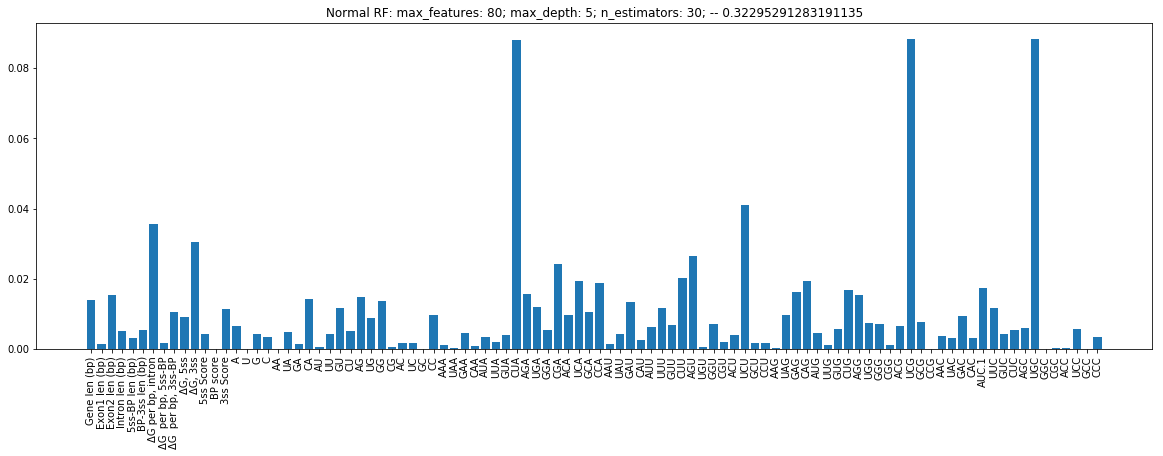

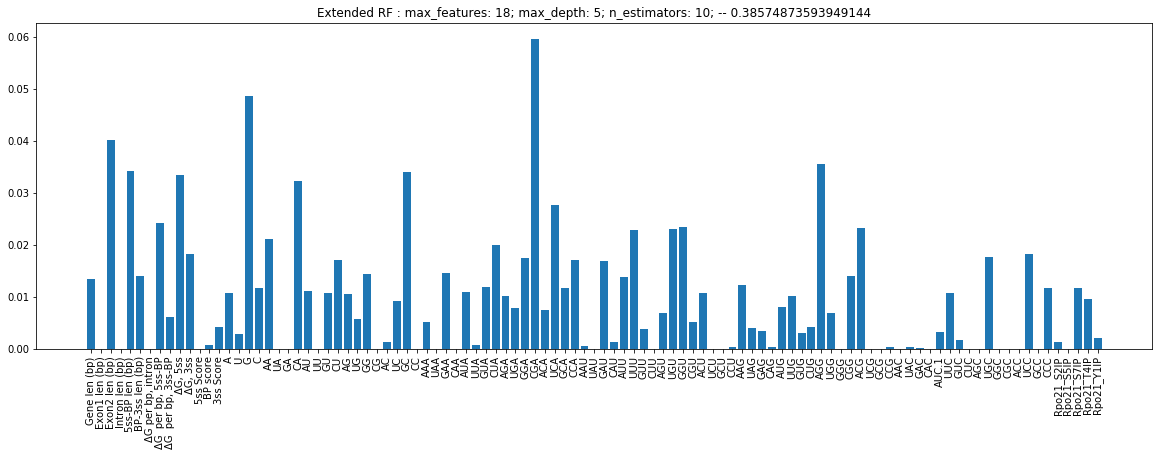

In [22]:
best_RFs(results_1_nrp,results_2_nrp,'nrp')

In [23]:
Normal best: 0.2969901764177368 | max_features: 25; max_depth: 5; n_estimators: 10;
Extended best: 0.40630448232918154 | max_features: 30; max_depth: 7; n_estimators: 20;
Best difference: 0.2582434619528223 | max_features: 30; max_depth: 7; n_estimators: 20;
Normal feature space
Coefficient of determination R^2: 0.2360352774266372
Mean squared error:               0.03984437679487179
Mean absolute error:              0.1488410256410256
Root mean squared error:          0.19961056283391365
Correlation Coefficient:          0.48848065665874996


Extended feature space
Coefficient of determination R^2: 0.38909635792549957
Mean squared error:               0.031861516874999996
Mean absolute error:              0.13109380341880345
Root mean squared error:          0.1784979464167585
Correlation Coefficient:          0.6250700537546936

SyntaxError: invalid syntax (<ipython-input-23-6872f7d45784>, line 1)